# Semi-conductor dataset
The semi-conductor dataset is a large dataset composed of nearly 600 features for testing semi-conductors. For detailed information consult the README.md

#### Objective and tasks
Our objective is to use the features to predict whether a semi-conductor has passed a validation test. In order to do so we need:
1. To reduces the number of features in the dataset either by dimension reduction techniques or by feature selection or by both. 
2. Predict whether a conductor passed or failed the test
3. Validate our predictions. 
4. Implement a ready to use .py file with the chosen techniques      

#### Plan
"I have a plan, its a crazy plan, but a plan nonetheless" Angus from the Spy-dog animation

Our predictions will be effected essentially by to main decisions: 1. How to reduce the dataset and select the features and 2. What model to use. So our plan might be drawn like this:
1. Clean the data
2. Apply several dimension reduction or feature selection techniques: 
    - PCA and used the components as features
    - Singular Value Decomposition
    - Select the best features via correlations metrics
    - Select features via LASSO Regularization
    - Select features via Random Forest Importance
    
3. Use the end features or components to predict via several models:
    - Logistic regression
    - Random forest
    - Gradient boosting machine
4. From step 4 we will have 12 combinations of reduction techniques and models, we may chose the top 3 or 4 of them and fine tune the model via hyperparameter tunning.
5. Validate the model

Note that there are many dimension reduction techniques and model types out there so my choices here are to some extent arbitrary derived only from my previous experience and current knowledge. So by all means any suggestions to improve this are welcomed.   


### Import libraries and data

In [623]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean, stdev
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import f1_score, matthews_corrcoef, RocCurveDisplay 
from yellowbrick.classifier import ClassPredictionError, ConfusionMatrix
import pickle
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [624]:
df = pd.read_csv("uci-secom.csv")

In [625]:
df.head()

Time        0        1          2          3       4      5  \
0  2008-07-19 11:55:00  3030.93  2564.00  2187.7333  1411.1265  1.3602  100.0   
1  2008-07-19 12:32:00  3095.78  2465.14  2230.4222  1463.6606  0.8294  100.0   
2  2008-07-19 13:17:00  2932.61  2559.94  2186.4111  1698.0172  1.5102  100.0   
3  2008-07-19 14:43:00  2988.72  2479.90  2199.0333   909.7926  1.3204  100.0   
4  2008-07-19 15:22:00  3032.24  2502.87  2233.3667  1326.5200  1.5334  100.0   

          6       7       8  ...       581     582     583     584      585  \
0   97.6133  0.1242  1.5005  ...       NaN  0.5005  0.0118  0.0035   2.3630   
1  102.3433  0.1247  1.4966  ...  208.2045  0.5019  0.0223  0.0055   4.4447   
2   95.4878  0.1241  1.4436  ...   82.8602  0.4958  0.0157  0.0039   3.1745   
3  104.2367  0.1217  1.4882  ...   73.8432  0.4990  0.0103  0.0025   2.0544   
4  100.3967  0.1235  1.5031  ...       NaN  0.4800  0.4766  0.1045  99.3032   

      586     587     588       589  Pass/Fail  
0     NaN     NaN     NaN       NaN         -1  
1  0.0096  0.0201  0.0060  208.2045         -1  
2  0.0584  0.0484  0.0148   82.8602          1  
3  0.0202  0.0149  0.0044   73.8432         -1  
4  0.0202  0.0149  0.0044   73.8432         -1  

[5 rows x 592 columns]

### Data cleaning

Let us first relabel the target column so that the test fail = 1 and the pass = 0 

In [626]:
df['Pass/Fail'] = df['Pass/Fail'].replace(to_replace=[-1,1], value=[0,1])

In [627]:
df = df.drop('Time', axis=1)

Let us look at its distribution too.  

Text(0.5, 0, '1: Fail, 0: Pass')

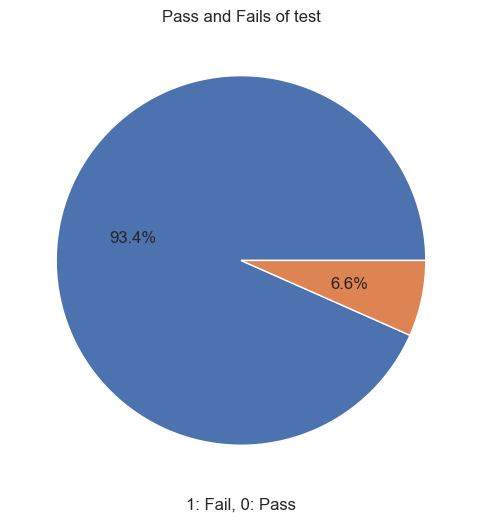

In [628]:
plt.figure(figsize=(10,6))
plt.pie(df['Pass/Fail'].value_counts(),autopct='%1.1f%%')
plt.title("Pass and Fails of test")
plt.xlabel('1: Fail, 0: Pass')

Our dataset is imbalanced so we need to bear this in mind when modeling

##### NaN handling
We were warned in the documentation that there are a lot of NaNs in this dataset, let us have a look 

In [629]:
np.count_nonzero(df.isna().sum())

538

Nearly all the columns have some missing values. 

In [630]:
df.isna().sum().sort_values(ascending=False).head(20)

157    1429
292    1429
293    1429
158    1429
492    1341
358    1341
85     1341
220    1341
246    1018
109    1018
110    1018
111    1018
518    1018
516    1018
245    1018
244    1018
382    1018
383    1018
384    1018
517    1018
dtype: int64

We see that there are columns with more NaNs than values, which won't help us in the prediction task, so let us remove all columns where there are more then 40% missing values 

In [631]:
def percentna(dataframe, threshold):
    '''Get a list of column names where the number of NaNs is above a % threshold'''
    columns = dataframe.columns[(dataframe.isna().sum()/dataframe.shape[1])>threshold]
    return columns.tolist()

In [632]:
na_columns = percentna(df, 0.4)

In [633]:
len(na_columns)

52

There are 52 features where the number of NaNs is above teh threshold, which is less then 10% of all the features, so let us remove these.

In [634]:
df = df.drop(na_columns, axis = 1)

In [635]:
len(df.columns)

539

There is the timestamp column, which does not really give us any value in terms of prediction, so let us drop it as well.

##### Outliers

Before imputing the missing values in the rest of the columns it is a good idea to check for outliers, because when imputing we rely on the existing data points and an outlier can potentially compromise the imputation. So let us apply the common rule of thumb which is that a data point, which is 3*SD away from the mean is considered an outlier.

The awkward moment here is that there are to much features for us to manually visualize them or checkout their descriptive statistics one by one. Let us start by exploring the number of outliers for each feature.

In [636]:
def outlier_explorer(df, columns, n_std, target):
    '''Explore the number of outliers for each column'''
    outlier_df = pd.DataFrame()
    outlier_count = []
    nan_count = []
    columns = list(columns)
    columns.remove(target)

    for column in columns:
        mean = df[column].mean()
        sd = df[column].std()
        n_outleirs = sum((df[column] > mean+(n_std*sd)))
        n_nan = df[column].isna().sum()
        outlier_count.append(n_outleirs)
        nan_count.append(n_nan)

    outlier_df['Name'] = columns
    outlier_df['Outliers'] = outlier_count
    outlier_df['NaNs'] = nan_count

    return outlier_df

In [637]:
x = outlier_explorer(df, df.columns, 3, 'Pass/Fail')
x.sort_values(by = 'Outliers', ascending=False)

Name  Outliers  NaNs
528  576        70     0
526  574        68     0
38    38        64     1
529  577        62     0
524  572        60     0
..   ...       ...   ...
42    42         0     1
250  264         0     9
249  263         0     9
248  262         0     9
125  132         0     8

[538 rows x 3 columns]

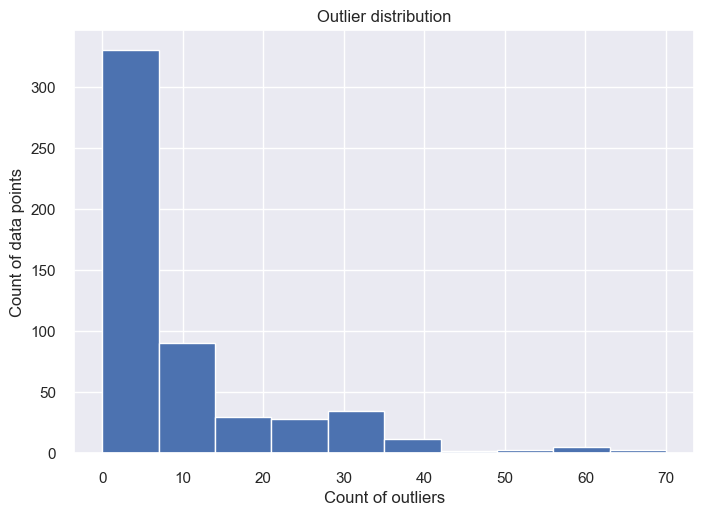

In [638]:
plt.hist(x['Outliers'])
plt.title('Outlier distribution')
plt.xlabel('Count of outliers')
plt.ylabel('Count of data points')
plt.show()

In [639]:
len(x[x['Outliers'] > 40])

13

Most have 0 to 5 outliers, while a very small portion of the features (13 to be exact) have over 40 outliers. These are suspicious and show an obvious visual separation from the other features. Let us look at them more closely.

In [640]:
z = x[x['Outliers'] > 40]
df[(z['Name'])].describe()

38          139          160          274          295  \
count  1566.000000  1553.000000  1565.000000  1553.000000  1565.000000   
mean     86.836577   416.766964   555.346326   136.292426   252.999118   
std       0.446756   263.300614   574.808588    85.607784   283.530702   
min      84.732700     0.000000     0.000000     0.000000     0.000000   
25%      86.578300   243.786000   295.000000    81.215600   130.220300   
50%      86.820700   339.561000   438.000000   110.601400   195.825600   
75%      87.002400   502.205900   625.000000   162.038200   273.952600   
max      88.418800  1770.690900  4170.000000   659.169600  2005.874400   

               558          572          573          574          575  \
count  1566.000000  1567.000000  1567.000000  1567.000000  1567.000000   
mean      0.995009    28.450165     0.345636     9.162315     0.104729   
std       0.083860    86.304681     0.248478    26.920150     0.067791   
min       0.891900     3.540000     0.066700     1.039500     0.023000   
25%       0.955200     7.500000     0.242250     2.567850     0.075100   
50%       0.972700     8.650000     0.293400     2.975800     0.089500   
75%       1.000800    10.130000     0.366900     3.492500     0.112150   
max       1.512100   454.560000     2.196700   170.020400     0.550200   

               576          577          589  
count  1567.000000  1567.000000  1566.000000  
mean      5.563747    16.642363    99.670066  
std      16.921369    12.485267    93.891919  
min       0.663600     4.582000     0.000000  
25%       1.408450    11.501550    44.368600  
50%       1.624500    13.817900    71.900500  
75%       1.902000    17.080900   114.749700  
max      90.423500    96.960100   737.304800

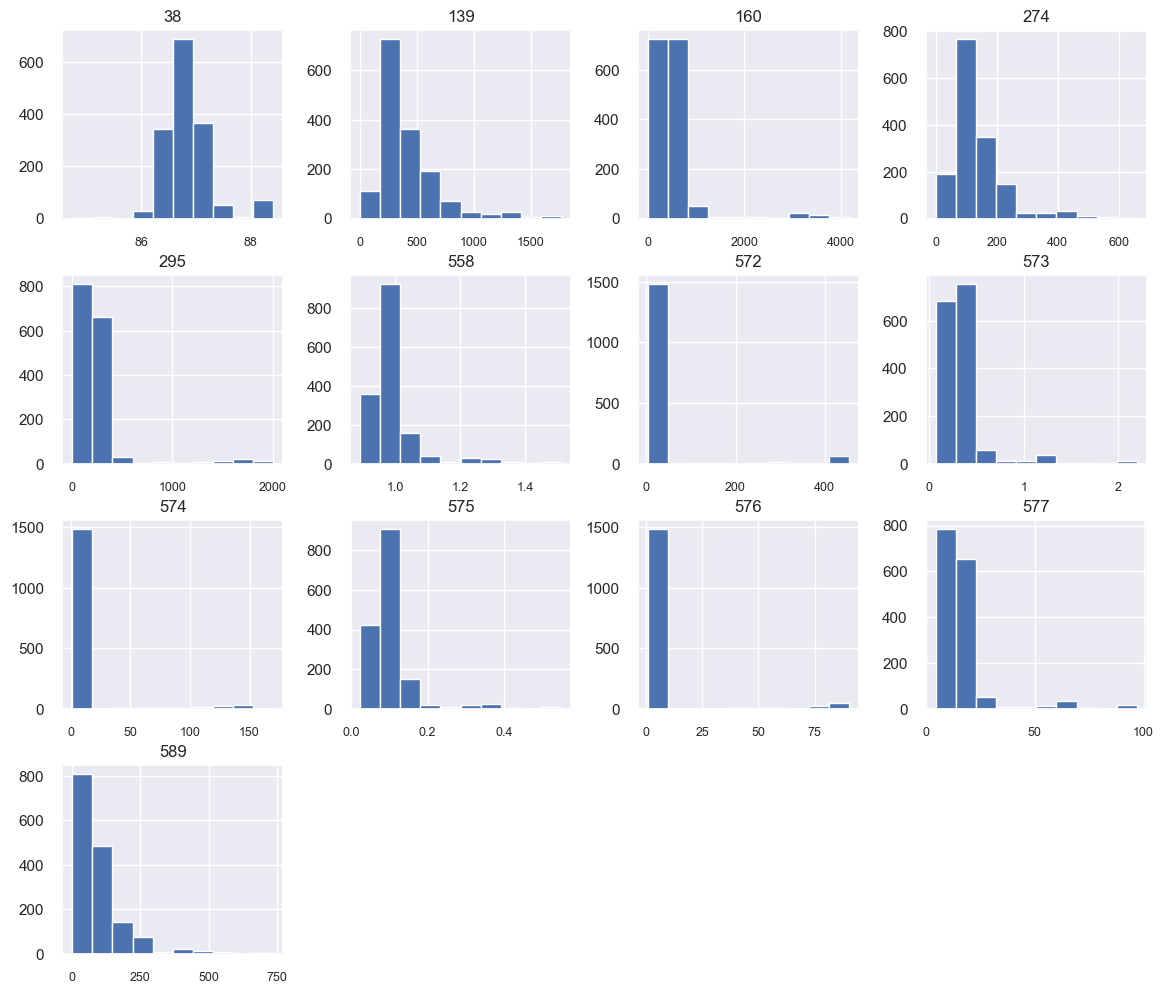

In [641]:
histograms = df[(z['Name'])].hist(figsize=(14,12), xlabelsize = 9)

Looking at these plots visually "I do not like" 160, 295, 572, 573, 574, 575, 576, 577, in fact 6 of these fall in to sequence and it is quite possible that they are connected. In a dataset with fewer features I would not remove such only because of their distribution graph, but here we have no context for each feature, we do not know what feature 160 is or how is it measured. Since here our objective is to reduce the dimensionality of the dataset first we may comfortably remove some of these.

In [642]:
df = df.drop(['160', '295', '572', '573', '574', '575', '576', '577'], axis=1)

I also want to check the relation between number of outliers and number of NaNs (which we still have not imputed). There might be a feature with both a high number of NaNs and outliers. In fact let us sum up the two columns to make a Bad data point column

In [643]:
x['Bad data point'] = x['NaNs'] + x['Outliers']
n = x.sort_values(by = 'Bad data point', ascending=False)
n.head(20)

Name  Outliers  NaNs  Bad data point
472  496        39    51              90
214  224        25    51              76
343  362        25    51              76
528  576        70     0              70
215  225        18    51              69
526  574        68     0              68
473  497        16    51              67
344  363        15    51              66
38    38        64     1              65
260  274        51    14              65
460  483        39    24              63
529  577        62     0              62
525  573        60     0              60
524  572        60     0              60
132  139        46    14              60
87    90         9    51              60
527  575        57     0              57
518  558        56     1              57
86    89         6    51              57
279  295        54     2              56

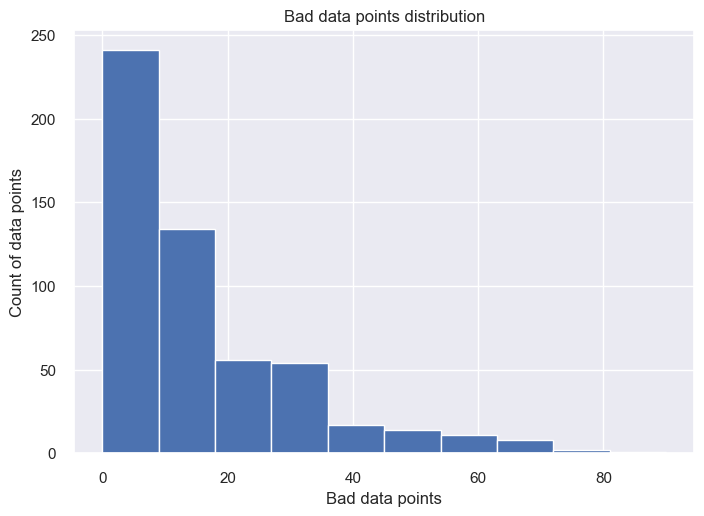

In [644]:
plt.hist(x['Bad data point'])
plt.title('Bad data points distribution')
plt.xlabel('Bad data points')
plt.ylabel('Count of data points')
plt.show()

Sixteen features have >= 60 Bad data points. We already removed 5 of these features in the last step. Currently our dataset has 1567 observations so for such features about 3.8% of the data is either Nan or an outlier. That is ok as a whole, just out of curiosity let us explore there 11 features further.

In [645]:
g = x[~x['Name'].isin(['160', '295', '572', '573', '574', '575', '576', '577'])]
h = g[g['Bad data point'] >= 60]
df[(h['Name'])].describe()

38            90          139          224          225  \
count  1566.000000   1516.000000  1553.000000  1516.000000  1516.000000   
mean     86.836577   8827.536865   416.766964     0.059370  1041.056588   
std       0.446756    396.313662   263.300614     0.071211   433.170076   
min      84.732700   7397.310000     0.000000     0.009300   168.799800   
25%      86.578300   8564.689975   243.786000     0.029775   718.725350   
50%      86.820700   8825.435100   339.561000     0.039800   967.299800   
75%      87.002400   9065.432400   502.205900     0.061300  1261.299800   
max      88.418800  10746.600000  1770.690900     1.436100  3601.299800   

               274          362          363          483          496  \
count  1553.000000  1516.000000  1516.000000  1543.000000  1516.000000   
mean    136.292426     0.018383   333.319601   206.564196    29.865896   
std      85.607784     0.021644   138.801928   192.864413    24.621586   
min       0.000000     0.002800    60.988200     0.000000     4.813500   
25%      81.215600     0.009500   228.682525    81.316150    16.342300   
50%     110.601400     0.012500   309.831650   148.317500    22.039100   
75%     162.038200     0.018600   412.329775   262.865250    32.438475   
max     659.169600     0.416300  1072.203100   989.473700   219.643600   

               497  
count  1516.000000  
mean     11.821030  
std       4.956647  
min       1.949600  
25%       8.150350  
50%      10.906550  
75%      14.469050  
max      40.281800

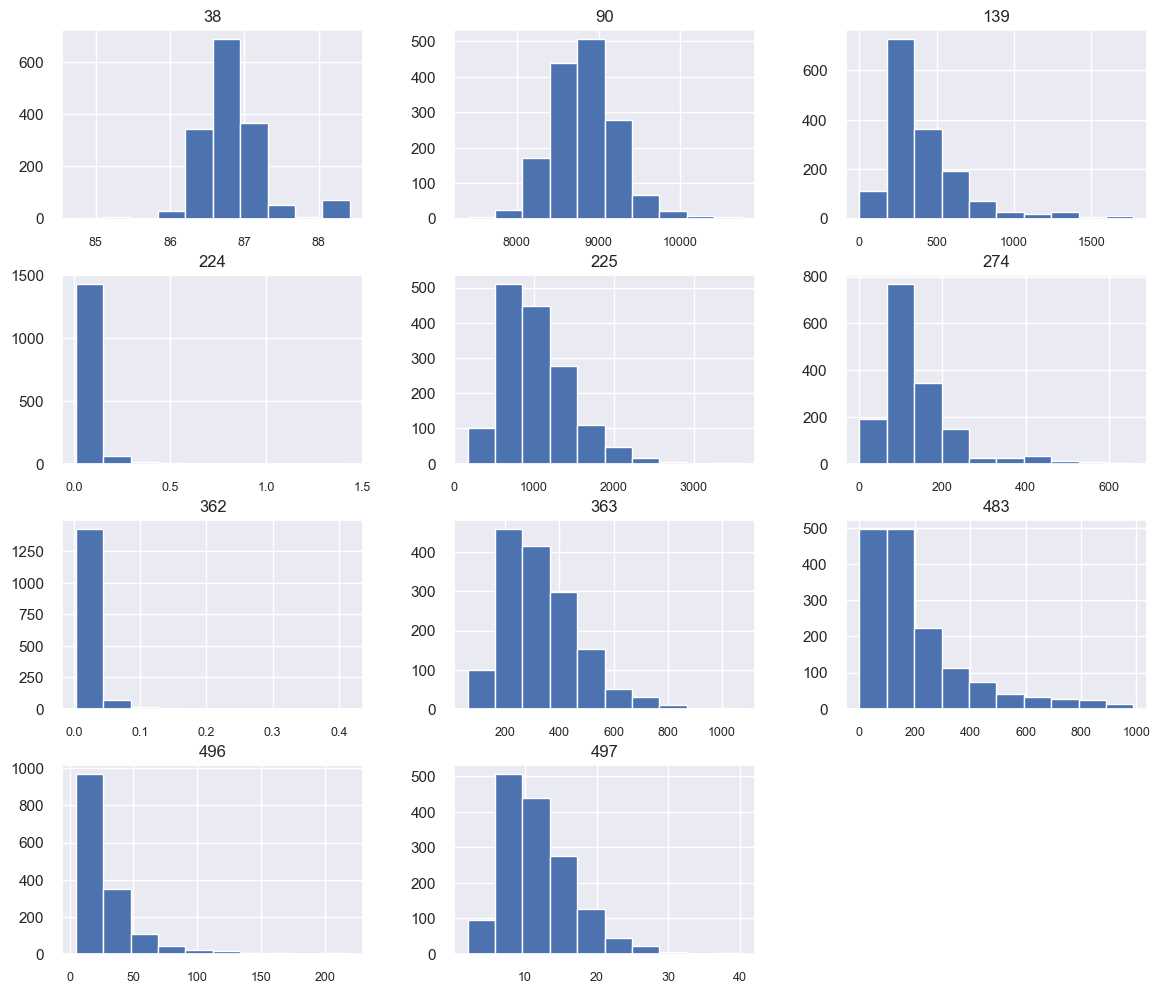

In [646]:
histograms = df[(h['Name'])].hist(figsize=(14,12), xlabelsize = 9)

I believe that the imputation of NaNs and Outliers should suffice for these 11, no need to remove the whole features

#### Train/Test split and impute NaNs and Outliers
Now that we have removed unnecessary features we are left with the imputation of the outliers and NaNs. Notice that we defined the outlier based on the whole dataset, which is better then doing is separately on the train and test dataset. However the imputation of these values should be done separately for the train and test datasets in order to avoid data leakage from one to the other.

The steps I will apply are as followed:

Impute outliers with the mean separately for the train and test datasets
Fit and apply a `KNNImputer` separately for the train and test datasets
This way the transformations are independent for the two datasets.

In [647]:
X = df.drop('Pass/Fail', axis=1)
y = df['Pass/Fail']

In [648]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=67, stratify=y)

Text(0.5, 0, '1: Fail, 0: Pass')

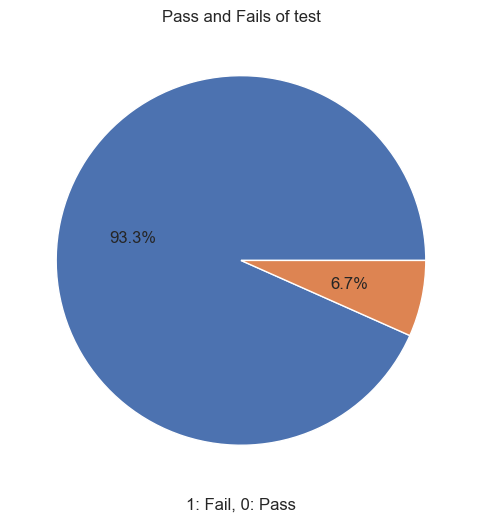

In [649]:
plt.figure(figsize=(10,6))
plt.pie(y_train.value_counts(),autopct='%1.1f%%')
plt.title("Pass and Fails of test")
plt.xlabel('1: Fail, 0: Pass')

Text(0.5, 0, '1: Fail, 0: Pass')

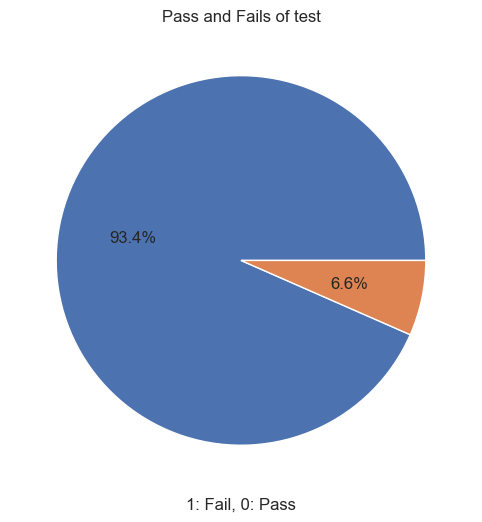

In [650]:
plt.figure(figsize=(10,6))
plt.pie(y_test.value_counts(),autopct='%1.1f%%')
plt.title("Pass and Fails of test")
plt.xlabel('1: Fail, 0: Pass')

In [651]:
def outlier_imputer(df_whole, df_impute, columns, n_std):
    '''Impute outliers with the mean for all columns in a dataset, which keeping NaN values'''
    for column in columns:
        '''Mean and SD are defined by the whole dataset'''
        mean = df_whole[column].mean()
        sd = df_whole[column].std()
    
        '''Outliers are replaced with the mean for the fit dataset train or test respectively'''
        df_impute[column] = np.where(df_impute[column] > mean+(n_std*sd), df_impute[column].mean(), df_impute[column])

    return df_impute

In [652]:
X_train = outlier_imputer(df, X_train, X_train.columns, 3)
X_test = outlier_imputer(df, X_test, X_test.columns, 3)

In [653]:
def nan_imputer(df):
    '''Impute NaNs on the whole dataset using KNNImputer'''
    imputer = KNNImputer()
    imputer.fit(df)

    df = pd.DataFrame(imputer.transform(df), columns=df.columns)

    return df
    

In [654]:
X_train = nan_imputer(X_train)
X_test = nan_imputer(X_test)

In [655]:
np.count_nonzero(X_train.isna().sum())

0

In [656]:
np.count_nonzero(X_test.isna().sum())

0

In [657]:
method = SMOTE()
X_train_balanced, y_train_balanced = method.fit_resample(X_train, y_train)

### Dimension reduction
#### Principle Component Analysis (PCA)  

No let us apply the principle component analysis to the dataset. Since PCA is affected by scale, so you need to scale the features in the data before applying PCA. We can transform the data onto unit scale (`mean = 0` and `SD = 1`), which is a requirement for the optimal performance of many machine learning algorithms. `StandardScaler` helps standardize the data set’s features. You fit on the training set and transform on the training and test set.

In [400]:
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(X_train_balanced)

# Apply transform to both the training set and the test set.
X_train_scaled = scaler.transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

Let us have a look at the result of the scaling

In [401]:
pd.DataFrame(X_train_scaled).describe()

0             1             2             3             4    \
count  2.046000e+03  2.046000e+03  2.046000e+03  2.046000e+03  2.046000e+03   
mean  -1.861441e-15 -1.357880e-15  1.308566e-14 -1.562777e-16  5.938554e-16   
std    1.000244e+00  1.000244e+00  1.000244e+00  1.000244e+00  1.000244e+00   
min   -3.735635e+00 -4.930683e+00 -5.401089e+00 -1.995630e+00 -1.784273e+00   
25%   -6.761649e-01 -5.330718e-01 -6.876288e-01 -8.040868e-01 -6.658576e-01   
50%   -1.160718e-01  8.419093e-02 -5.225643e-02 -1.451968e-01 -1.722266e-02   
75%    5.924959e-01  5.816340e-01  6.143279e-01  6.174408e-01  4.697885e-01   
max    3.241591e+00  3.468469e+00  3.145651e+00  4.074687e+00  8.517865e+00   

          5             6             7             8             9    ...  \
count  2046.0  2.046000e+03  2.046000e+03  2.046000e+03  2.046000e+03  ...   
mean      0.0 -8.751553e-16 -4.063221e-16  2.153160e-15  2.778271e-17  ...   
std       0.0  1.000244e+00  1.000244e+00  1.000244e+00  1.000244e+00  ...   
min       0.0 -3.654704e+00 -1.780285e+01 -4.278264e+00 -3.956077e+00  ...   
25%       0.0 -4.715216e-01 -1.279183e-01 -6.682071e-01 -5.843116e-01  ...   
50%       0.0  4.960108e-02  4.534495e-02  6.335573e-03 -3.592541e-02  ...   
75%       0.0  5.391104e-01  2.435091e-01  6.938613e-01  5.021908e-01  ...   
max       0.0  3.419296e+00  8.160696e-01  3.013455e+00  3.438498e+00  ...   

                520           521           522           523           524  \
count  2.046000e+03  2.046000e+03  2.046000e+03  2.046000e+03  2.046000e+03   
mean  -5.070344e-16  1.736419e-16  9.758676e-16 -1.007123e-16 -1.458592e-16   
std    1.000244e+00  1.000244e+00  1.000244e+00  1.000244e+00  1.000244e+00   
min   -9.870021e+00 -3.784060e+00 -6.897926e+00 -1.817183e+00 -1.995445e+00   
25%    7.297003e-02 -4.004214e-01 -6.461916e-01 -6.580076e-01 -6.843903e-01   
50%    1.377675e-01  1.194598e-01  1.328685e-02 -1.983348e-01 -1.595581e-01   
75%    2.326957e-01  7.030934e-01  6.248986e-01  3.612670e-01  3.602667e-01   
max    1.935694e+00  2.287736e+00  2.887862e+00  6.396972e+00  5.870884e+00   

                525           526           527           528           529  
count  2.046000e+03  2.046000e+03  2.046000e+03  2.046000e+03  2.046000e+03  
mean   2.396258e-16  2.361530e-16 -1.389135e-16  1.805876e-16 -6.077467e-17  
std    1.000244e+00  1.000244e+00  1.000244e+00  1.000244e+00  1.000244e+00  
min   -1.819521e+00 -3.664408e+00 -1.948072e+00 -1.893000e+00 -1.474789e+00  
25%   -6.556337e-01 -7.089837e-01 -7.481923e-01 -7.562984e-01 -6.841778e-01  
50%   -2.037062e-01 -1.810035e-02 -1.282775e-01 -1.763816e-01 -2.739104e-01  
75%    3.501838e-01  5.896242e-01  5.978613e-01  5.193950e-01  3.590484e-01  
max    6.285164e+00  3.537646e+00  3.611631e+00  3.646574e+00  4.702326e+00  

[8 rows x 530 columns]

In [402]:
pca_095 = PCA(0.95)
pca_095 = pca_095.fit(X_train_scaled)
pca_095.n_components_

156

We see that when we set the variance explained to be 95% of the datasets initial variance we see that the 530 features are compressed in 151 components, which means that we have reduced the dimensionality about 3 times. But are all these components meaningful? Lets look at the variance explained per feature.  

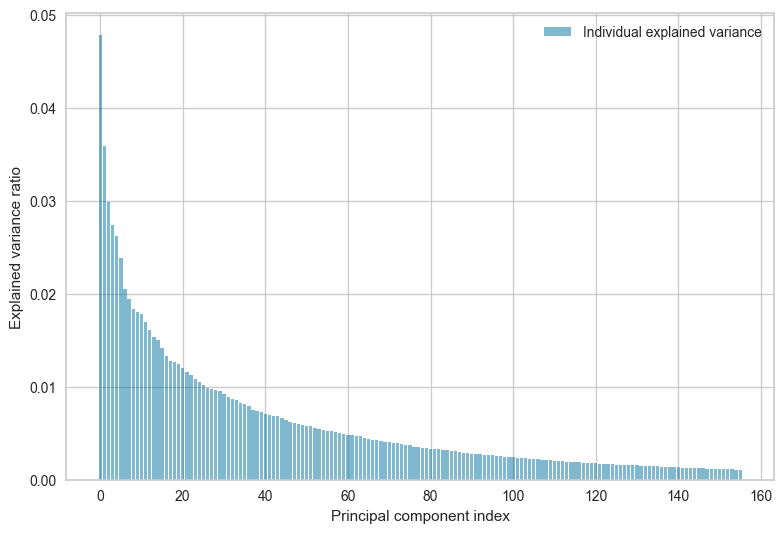

In [403]:
exp_var_pca = pca_095.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

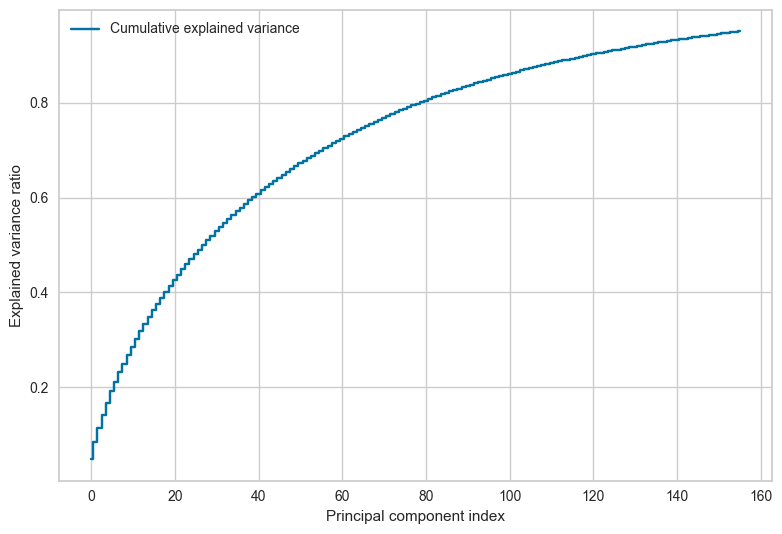

In [404]:
exp_var_pca = pca_095.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

We see from the two graphs that even though the first 3 components are strong predictors (they explain more variance the the succeeding), as percentages this is between 4 and 2%, which is not much. The components gradually decrees in explainability, which is to be expected, but there is no visually distinguishable threshold, after which we may disregard some of the components.       

So lets `fit_transform` the dataset using the 95% PCA

In [405]:
X_train_pca_095 = pca_095.fit_transform(X_train_scaled)
X_train_pca_095 = principalDF=pd.DataFrame(data=X_train_pca_095)

Just for arbitrary testing let us state that components with variance explained below 0.5% are to be ignored. Visually this coincides with the 75th component. So let us apply the `PCA(n_components = 75) ` and save it separately.

In [406]:
pca_75 = PCA(n_components=75)
X_train_pca_75 = pca_75.fit_transform(X_train_scaled)
X_train_pca_75 = principalDF=pd.DataFrame(data=X_train_pca_75)
X_test_pca_75 = pca_75.fit_transform(X_test_scaled)
X_test_pca_75 = principalDF=pd.DataFrame(data=X_test_pca_75)

##### Modeling PCA data
Now let us get to the gist of things, which is to model the dimensionally reduced data. As mentioned we will try three classifiers (LogReg, RF, GBM and AdaBoost) and as estimator we need a metric that works well on an imbalanced dataset as we saw earlier. I will use the `f1_score` and `matthews_corrcoef`.   

In [465]:
def evaluate(train_df, test_df, train_target, test_target, estimator):
    
    # first, we should scale our data so logistic regression works better
    
    # training the model
    start_time = time.time()
    method = SMOTE()
    train_df, train_target = method.fit_resample(train_df, train_target)
    estimator.fit(train_df, train_target)
    runtime = time.time() - start_time
    
    # evaluation and scoring
    y_pred = estimator.predict(test_df)
    y_true = test_target
    f1score = f1_score(y_true, y_pred, average='micro')
    mccscore=matthews_corrcoef(y_true, y_pred)
    
    # visualizations
    cre = ClassPredictionError(estimator, classes=['pass','fail'])
    cre.score(test_df, y_true)
    cre.show()
    cm = ConfusionMatrix(estimator, classes=['pass','fail'])
    cm.score(test_df, y_true)
    cm.show()
    rocauc = RocCurveDisplay.from_estimator(estimator, test_df, y_true)
    plt.show()
    
    return f'Run time: {runtime}, F1-score: {f1score}, MCC: {mccscore}' 

Just to have a benchmark let us look at the results for the dataset without any prior transformation. 

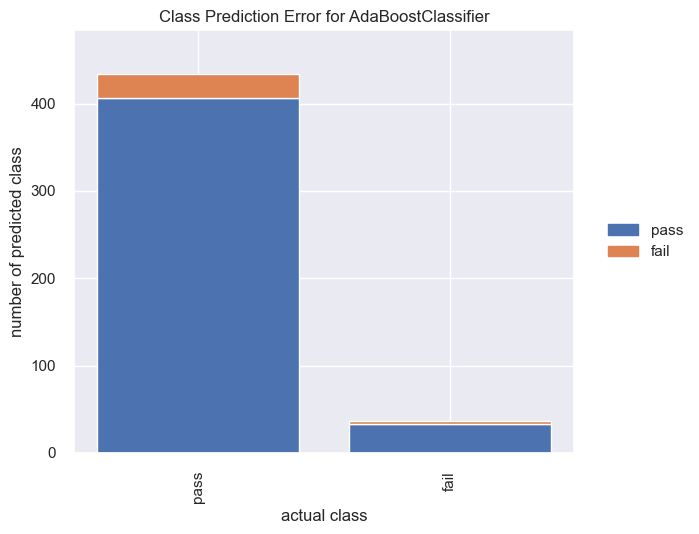

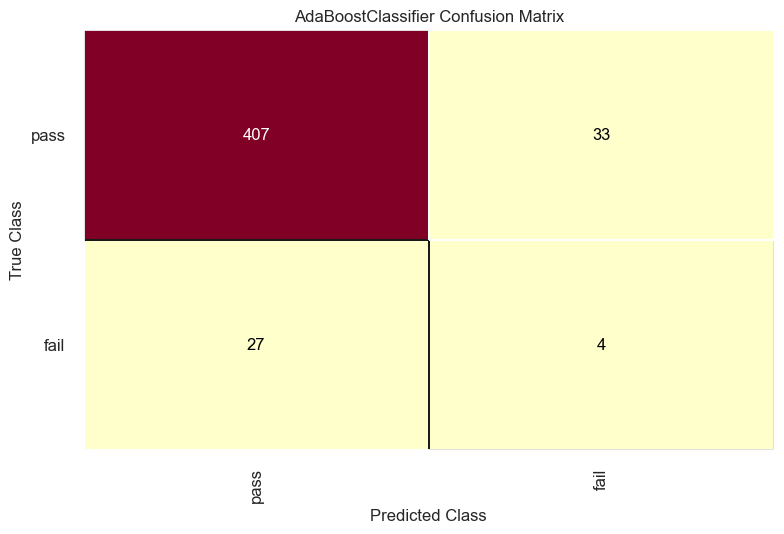

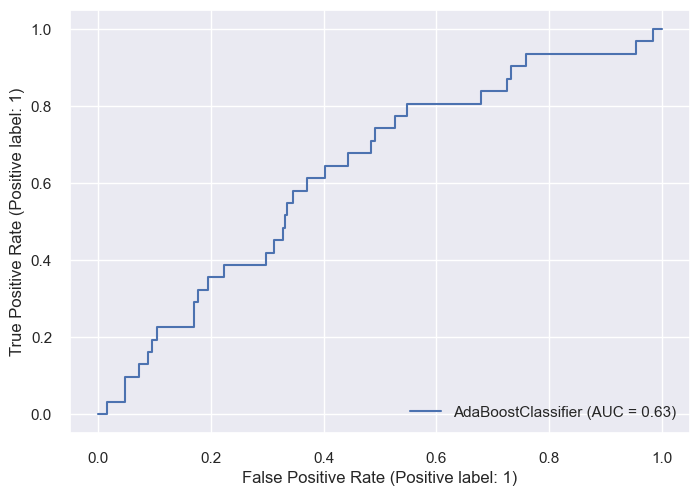

'Run time: 16.961081504821777, F1-score: 0.8726114649681529, MCC: 0.04979830673266464'

In [480]:
evaluate(X_train, X_test, y_train, y_test, AdaBoostClassifier(random_state=34))

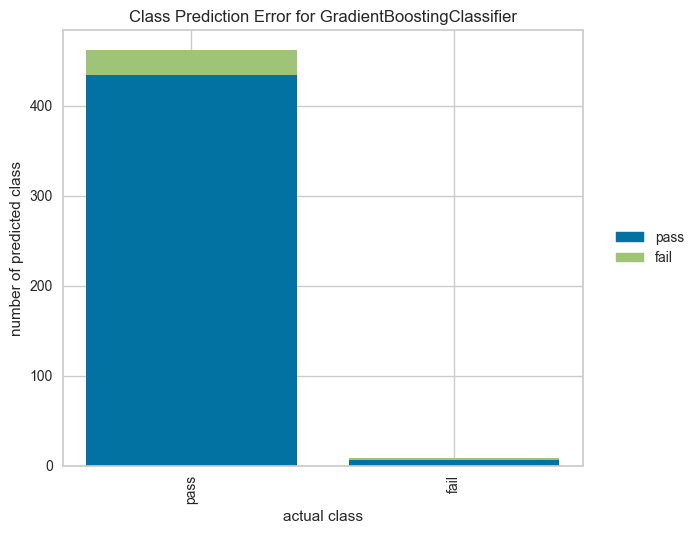

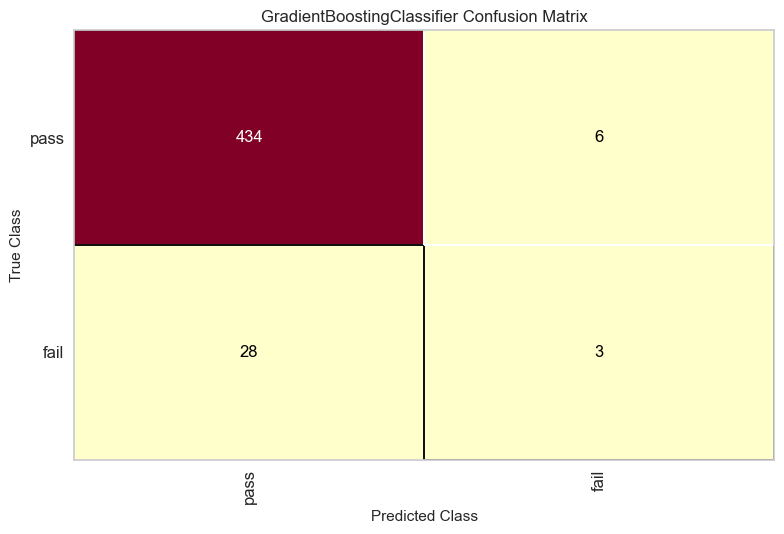

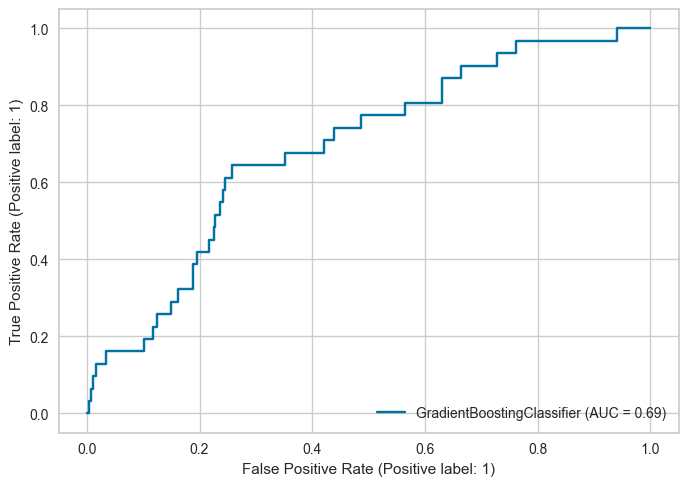

'Run time: 88.01283645629883, F1-score: 0.9278131634819533, MCC: 0.15057872895057267'

In [409]:
evaluate(X_train, X_test, y_train, y_test, GradientBoostingClassifier(random_state=34))

In [410]:
pca_95_for_test = PCA(n_components=156)
X_test_pca_095 = pca_95_for_test.fit_transform(X_test_scaled)

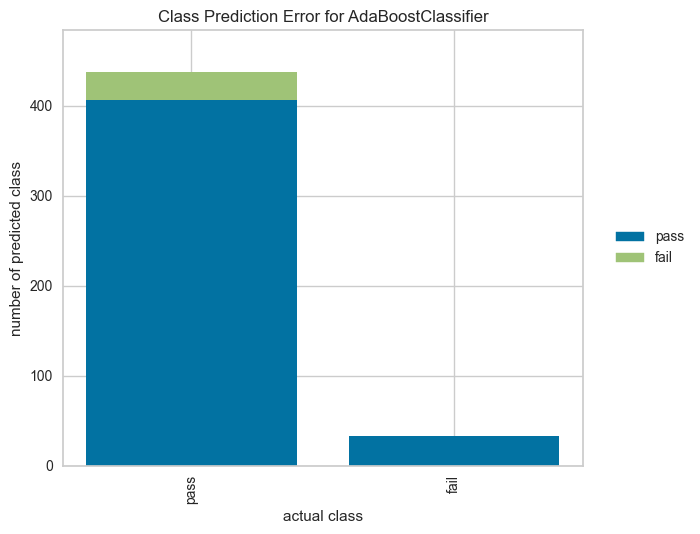

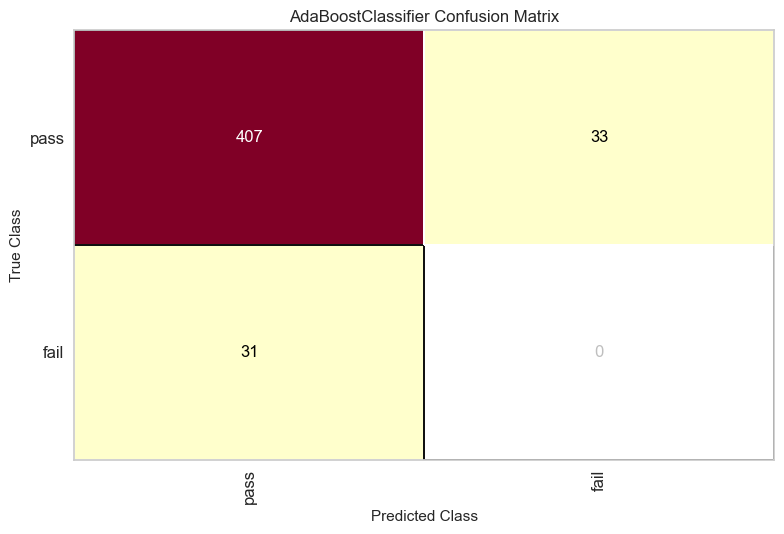

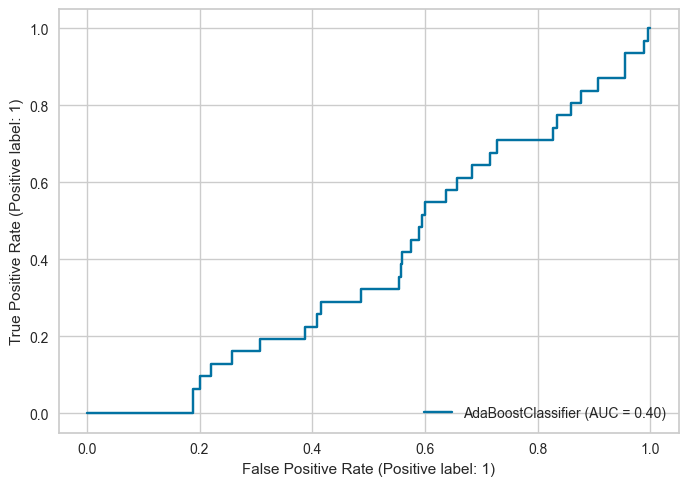

'Run time: 7.76689600944519, F1-score: 0.8641188959660298, MCC: -0.0728575265712623'

In [411]:
evaluate(X_train_pca_095, X_test_pca_095, y_train_balanced, y_test, AdaBoostClassifier(random_state=34))

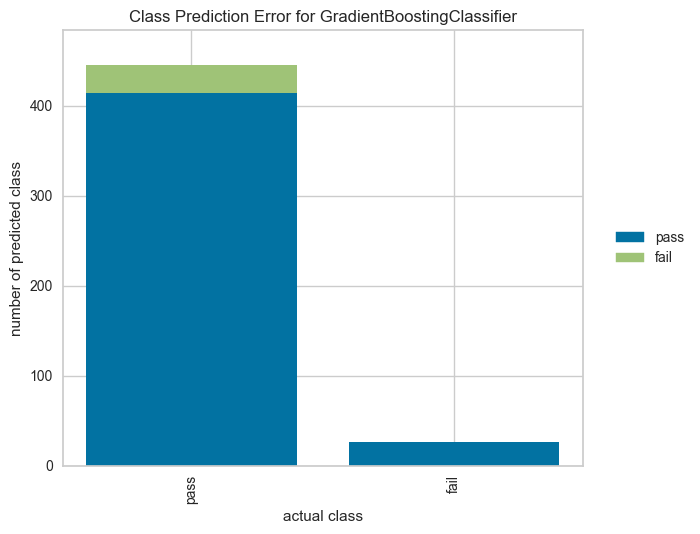

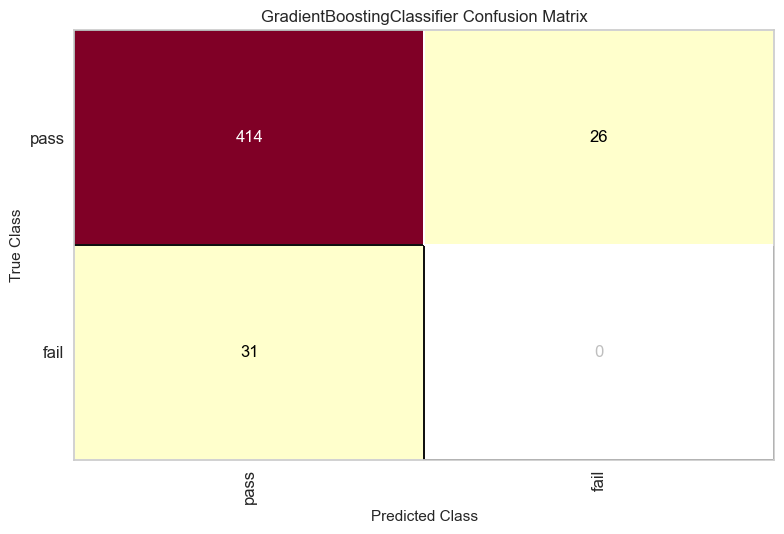

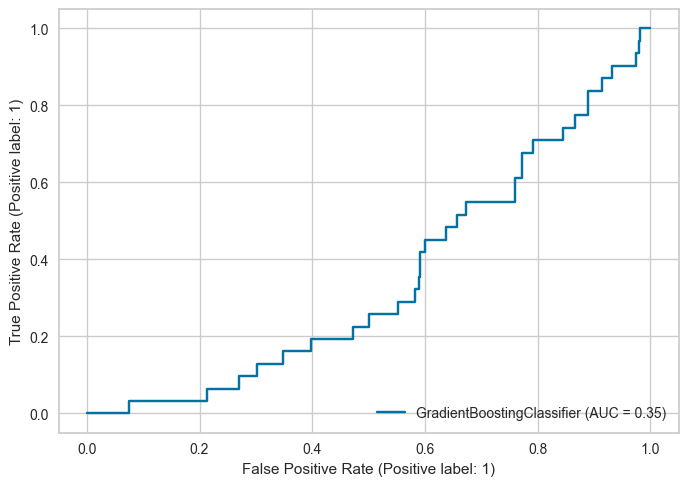

'Run time: 41.74858117103577, F1-score: 0.8789808917197452, MCC: -0.06415953048768677'

In [412]:
evaluate(X_train_pca_095, X_test_pca_095, y_train_balanced, y_test, GradientBoostingClassifier(random_state=34))

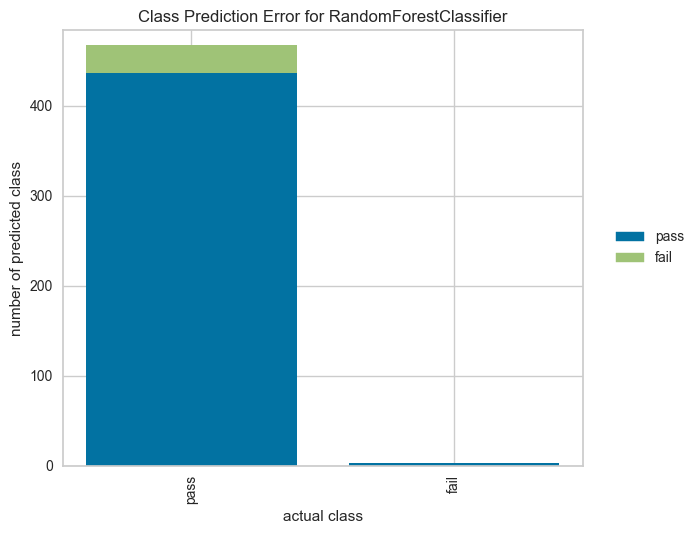

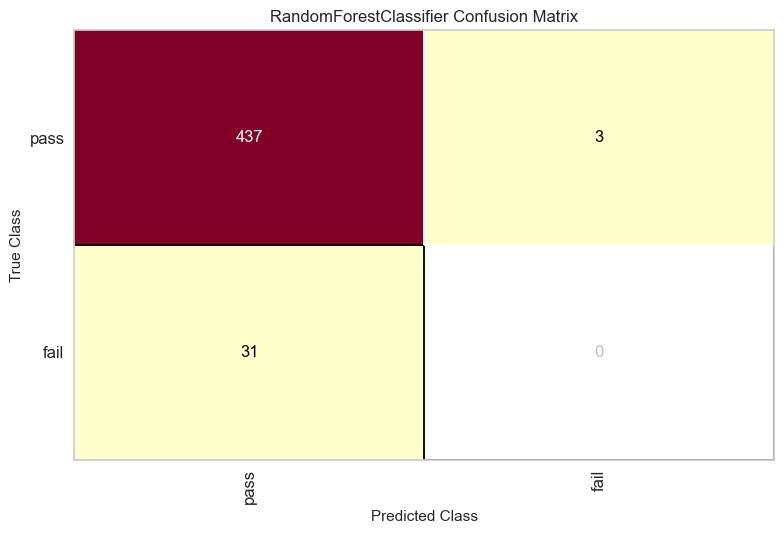

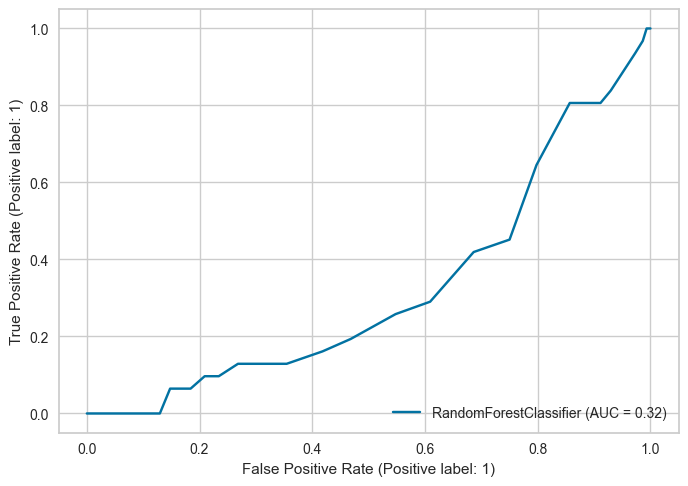

'Run time: 8.599264860153198, F1-score: 0.9278131634819533, MCC: -0.02125162821130893'

In [413]:
evaluate(X_train_pca_095, X_test_pca_095, y_train_balanced, y_test, RandomForestClassifier(random_state=34))

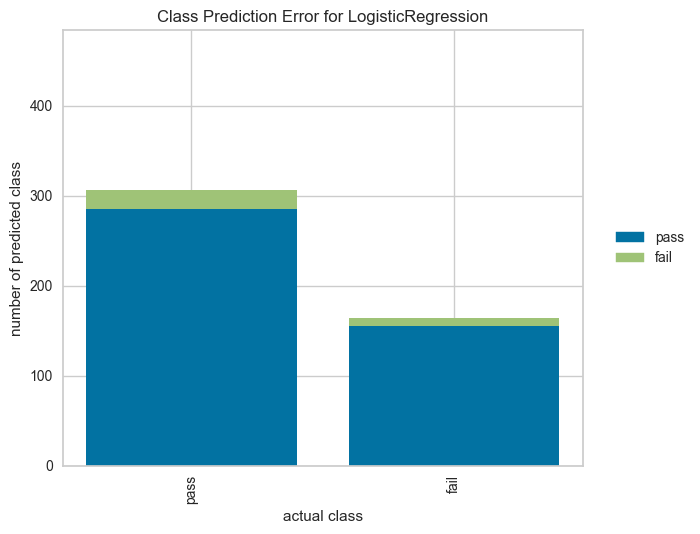

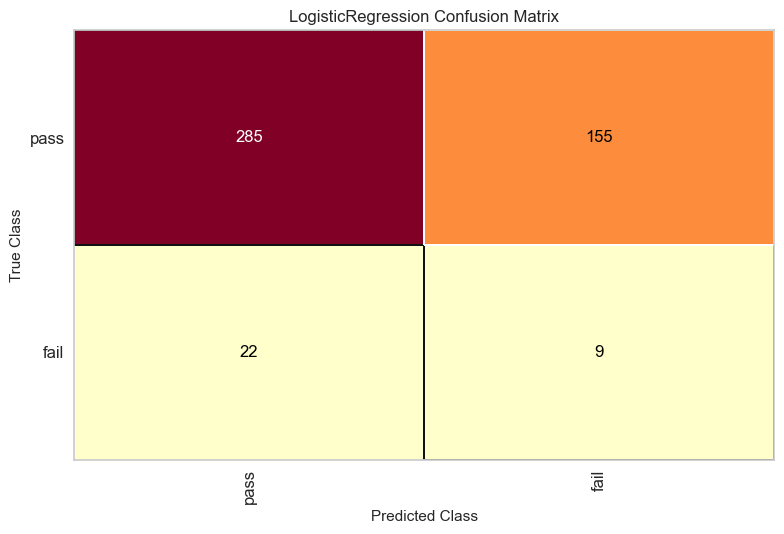

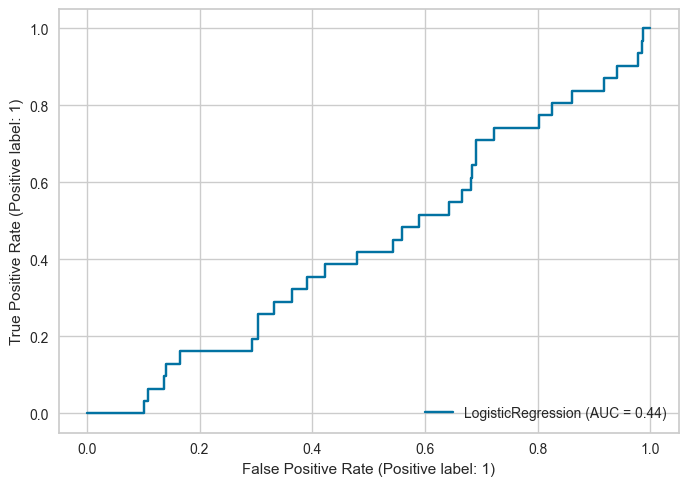

'Run time: 0.13543224334716797, F1-score: 0.6242038216560509, MCC: -0.03224470529728397'

In [414]:
evaluate(X_train_pca_095, X_test_pca_095, y_train_balanced, y_test, LogisticRegression())

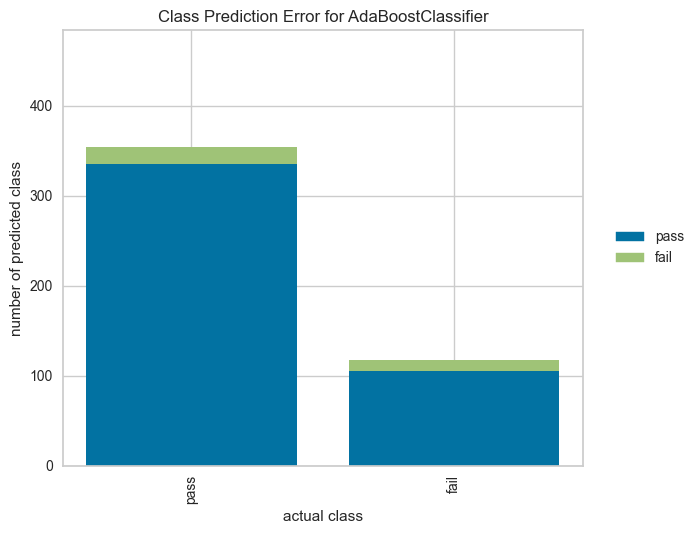

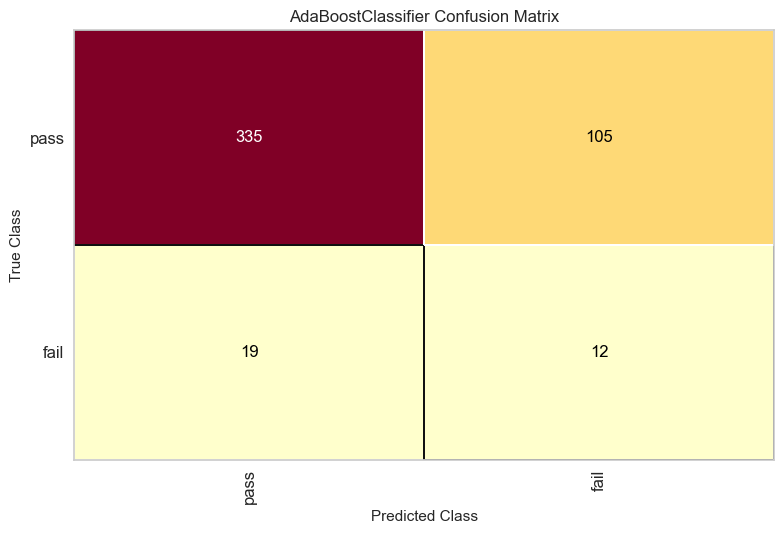

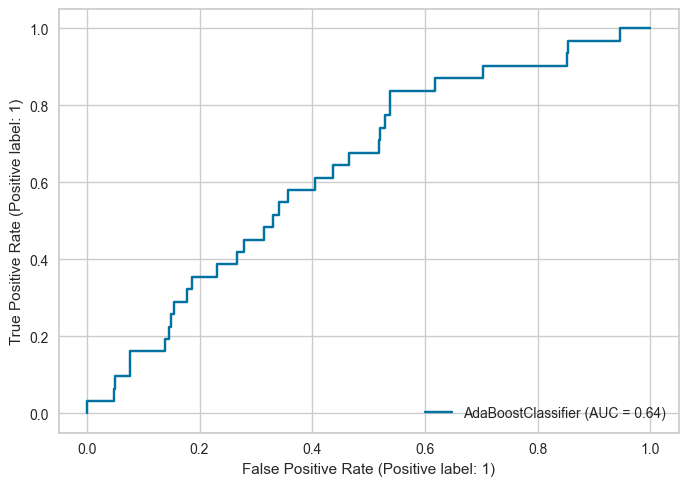

'Run time: 3.797494411468506, F1-score: 0.7367303609341825, MCC: 0.08519679952407413'

In [415]:
evaluate(X_train_pca_75, X_test_pca_75, y_train_balanced, y_test, AdaBoostClassifier(random_state=34))

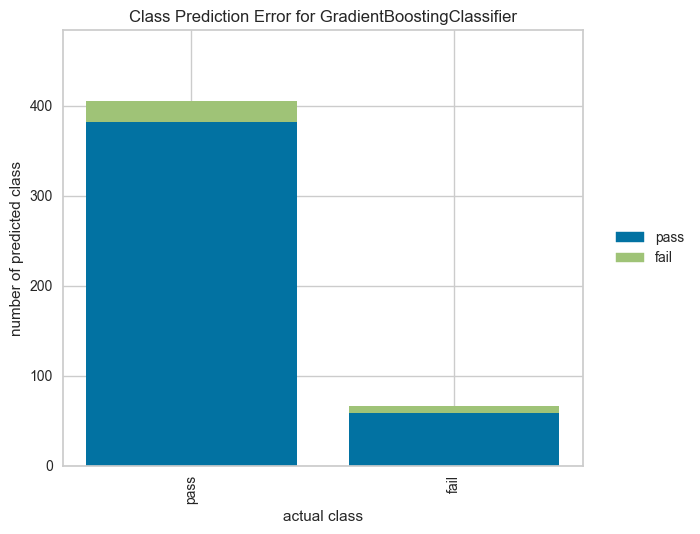

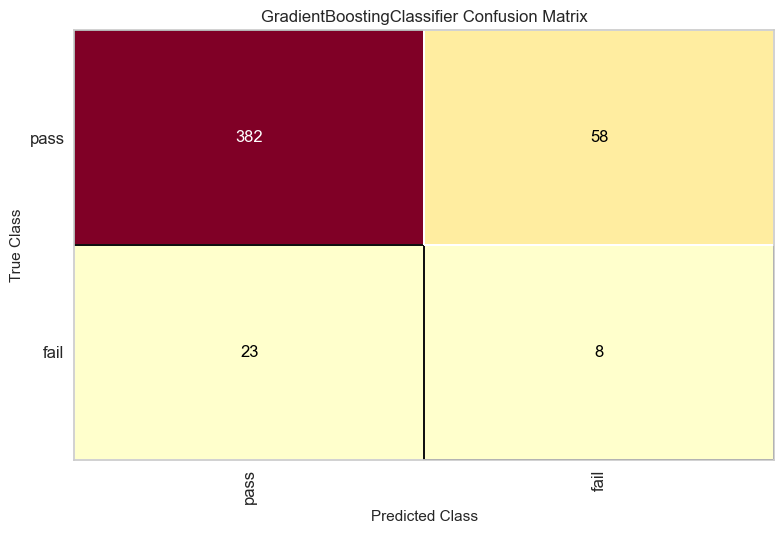

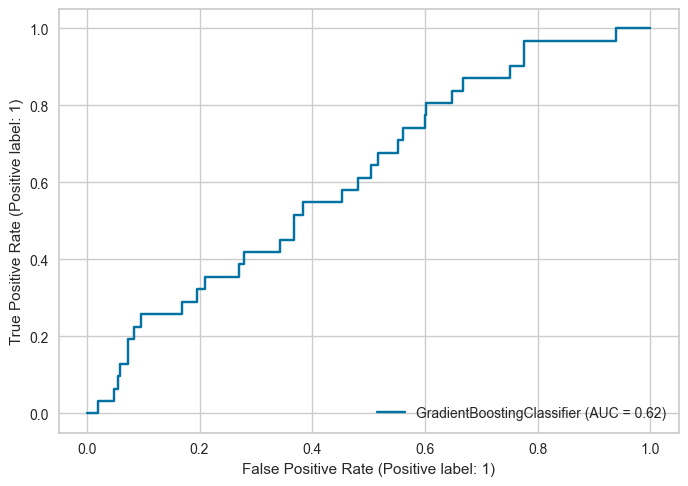

'Run time: 19.982797145843506, F1-score: 0.8280254777070064, MCC: 0.09018337466291881'

In [416]:
evaluate(X_train_pca_75, X_test_pca_75, y_train_balanced, y_test, GradientBoostingClassifier(random_state=34))

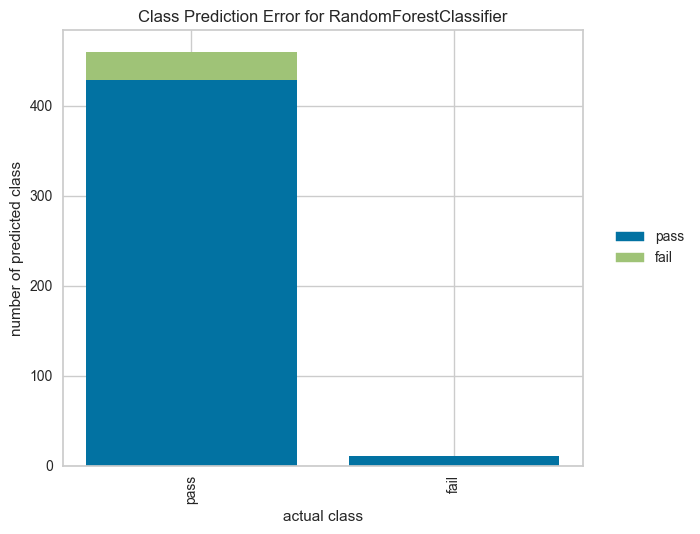

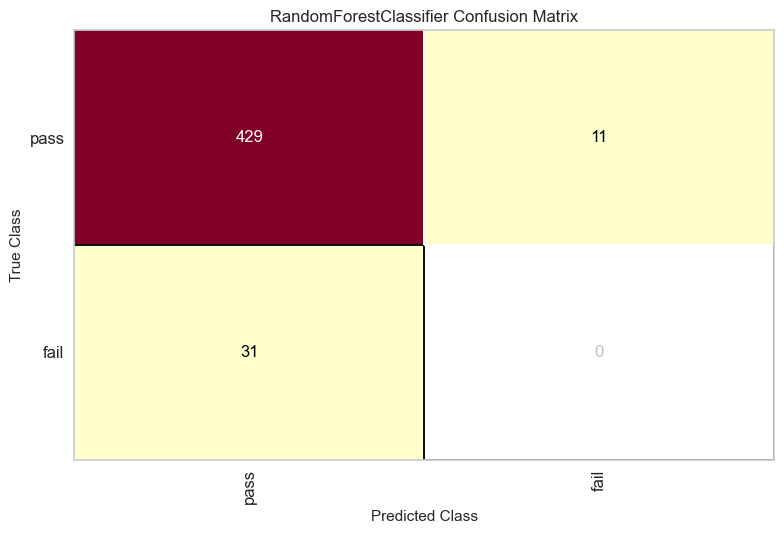

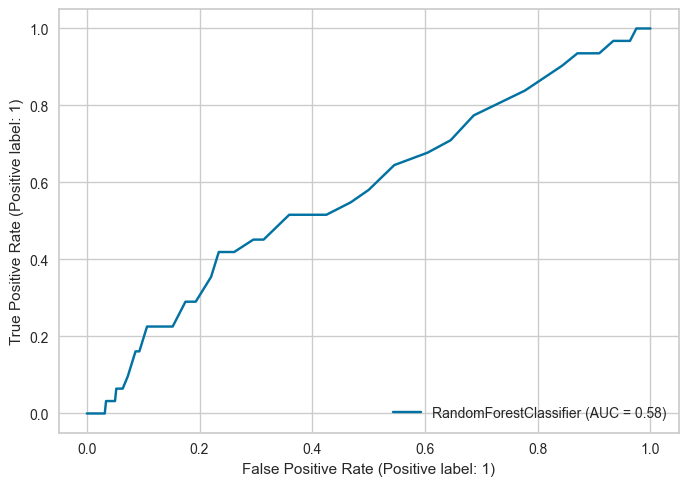

'Run time: 6.381171464920044, F1-score: 0.910828025477707, MCC: -0.04104610345325914'

In [417]:
evaluate(X_train_pca_75, X_test_pca_75, y_train_balanced, y_test, RandomForestClassifier(random_state=34))

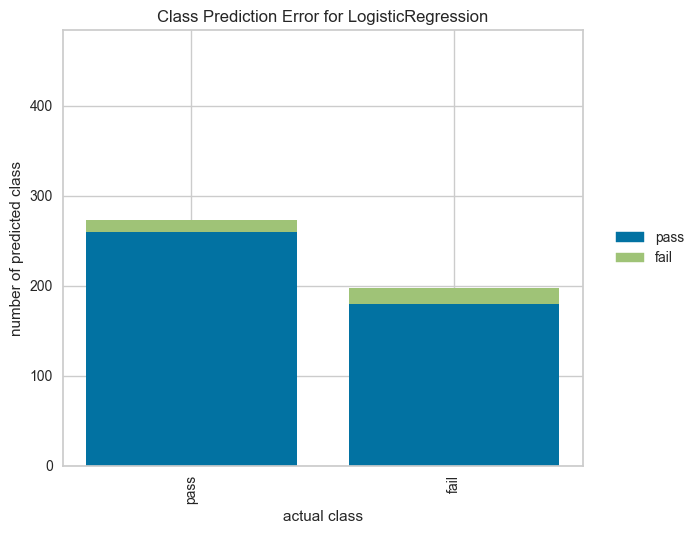

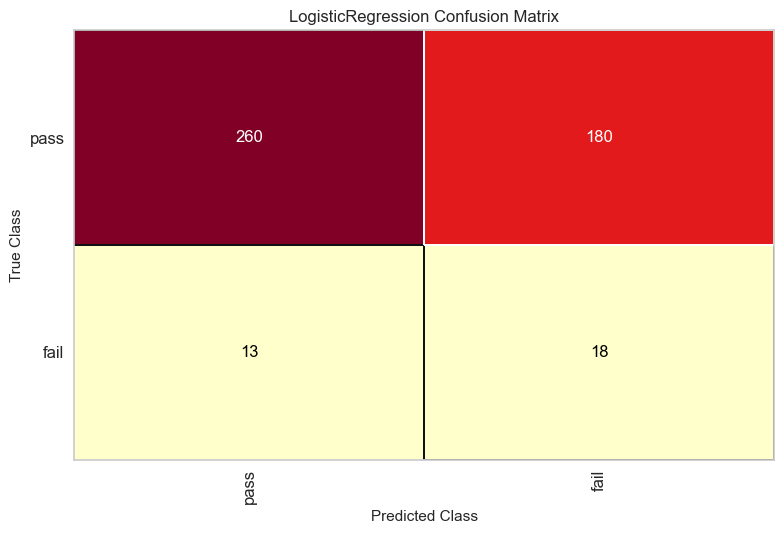

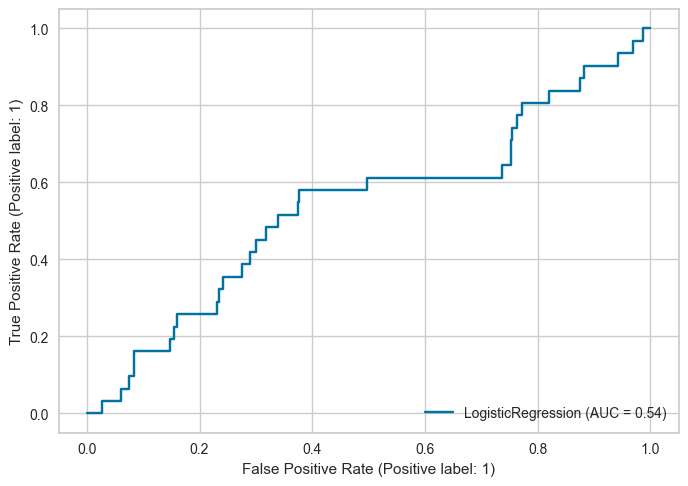

'Run time: 0.05553841590881348, F1-score: 0.5902335456475584, MCC: 0.08617767114690217'

In [418]:
evaluate(X_train_pca_75, X_test_pca_75, y_train_balanced, y_test, LogisticRegression())

Not off to a great start, all models performed poorly.

#### Singular vector decomposition (SVD)

This method is quite similar to the PCA, it even has similar attributes and parameters. Again let us first scale the dataset.

In [419]:
svd = TruncatedSVD(algorithm='arpack', random_state=23)
svd.fit_transform(X_train_scaled)
svd.explained_variance_ratio_.sum()

0.0837184142911939

Be default the SVD generates 2 components and we see that gives us an explained variance of 10%, which is close to the PCA, remember that the first two components of the PCA had a variance explained ration of 4 and 3.5%. Gradually increasing the `n_components` I decided to stop at 120. 

In [420]:
svd = TruncatedSVD(n_components=107, algorithm='arpack', random_state=23)
svd.fit_transform(X_train_scaled)
svd.explained_variance_ratio_.sum()

0.8748707915142435

Let us go ahead and use a svd with 107 components, since it explains more then 90% of the variance

In [421]:
svd = TruncatedSVD(n_components=120, algorithm='arpack', random_state=23)
X_train_svd = svd.fit_transform(X_train_scaled)
X_test_svd = svd.fit_transform(X_test_scaled)

##### Modeling the SVD data

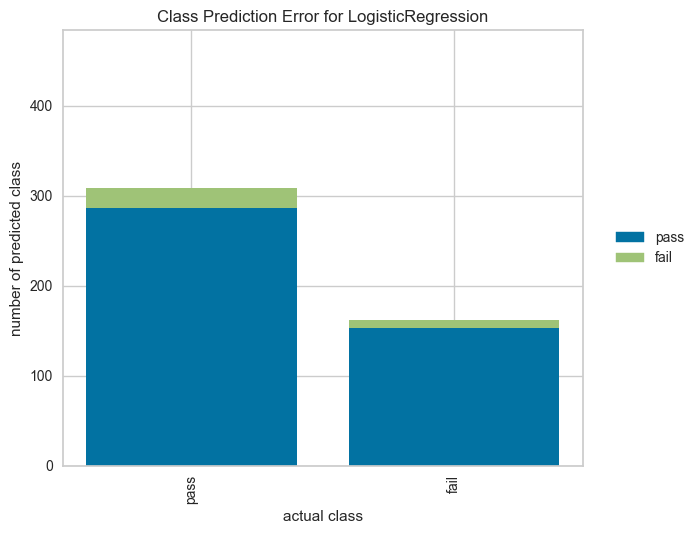

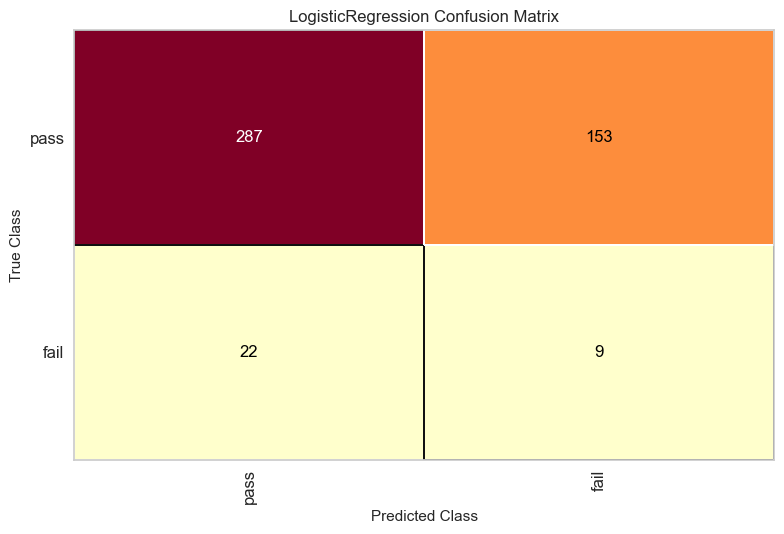

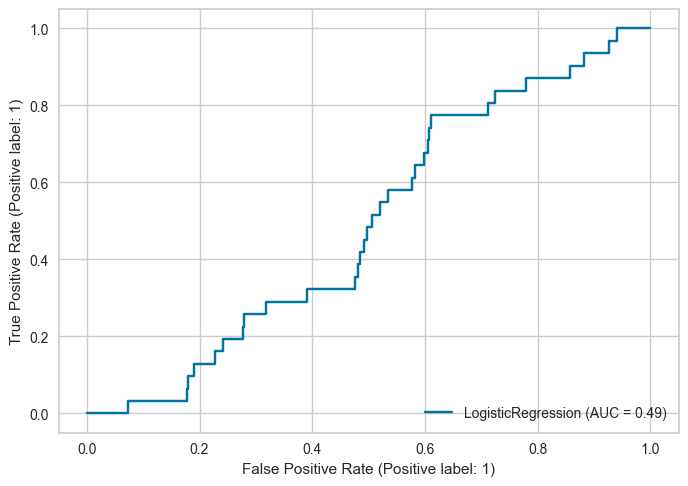

'Run time: 0.08979487419128418, F1-score: 0.6284501061571125, MCC: -0.02996524479404444'

In [422]:
evaluate(X_train_svd, X_test_svd, y_train_balanced, y_test, LogisticRegression())

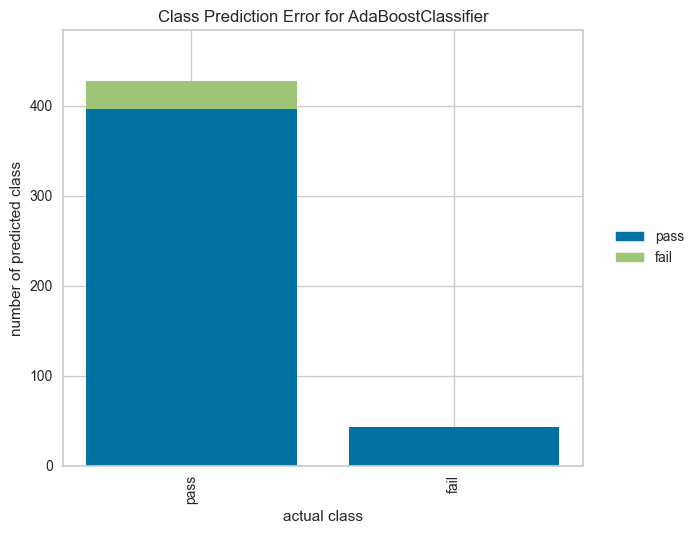

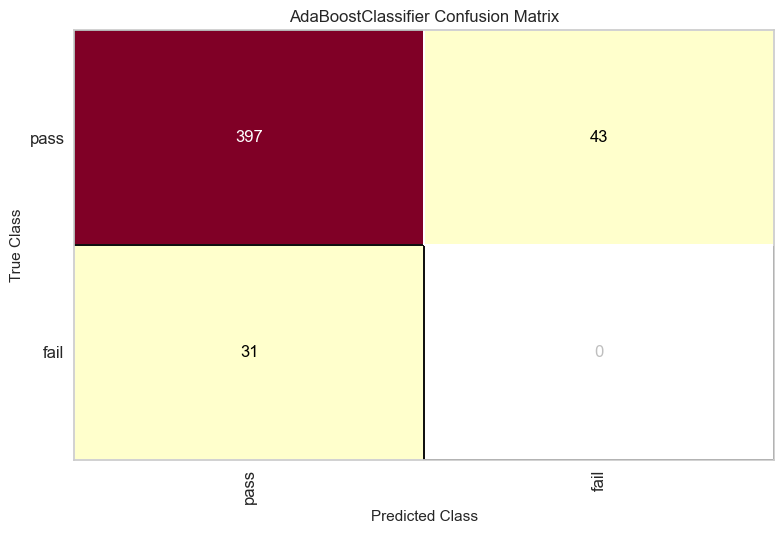

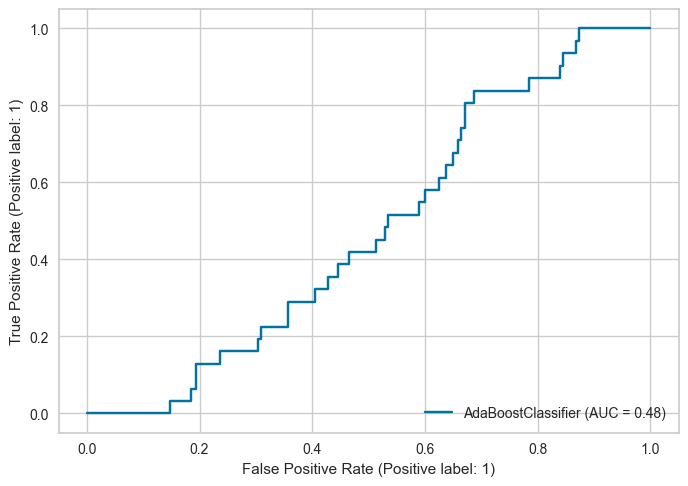

'Run time: 5.953826189041138, F1-score: 0.8428874734607219, MCC: -0.08413309236112974'

In [423]:
evaluate(X_train_svd, X_test_svd, y_train_balanced, y_test, AdaBoostClassifier())

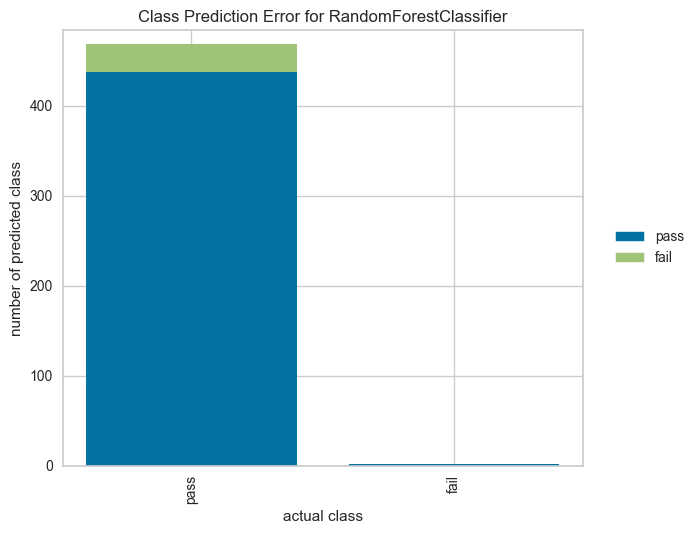

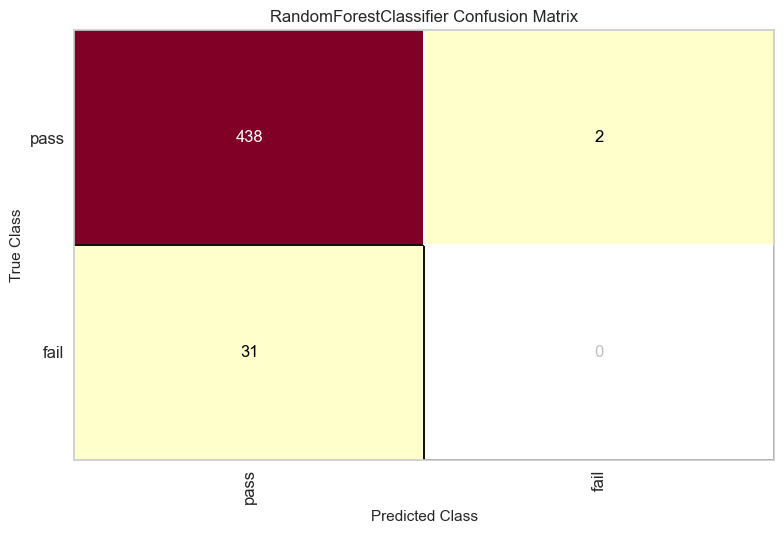

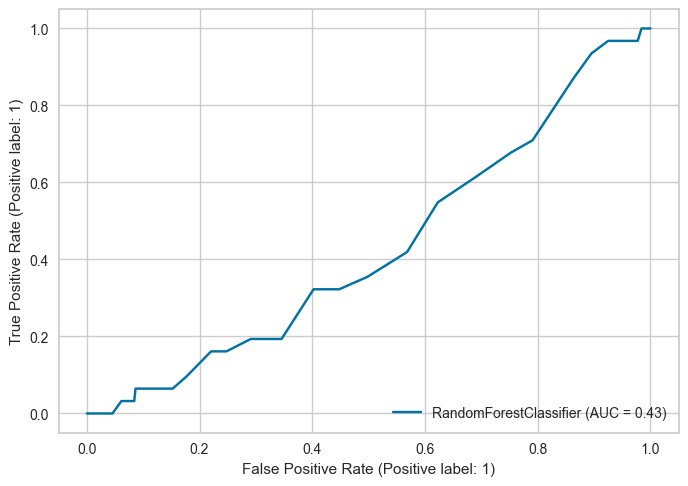

'Run time: 7.9827094078063965, F1-score: 0.9299363057324841, MCC: -0.017333373094521518'

In [424]:
evaluate(X_train_svd, X_test_svd, y_train_balanced, y_test, RandomForestClassifier())

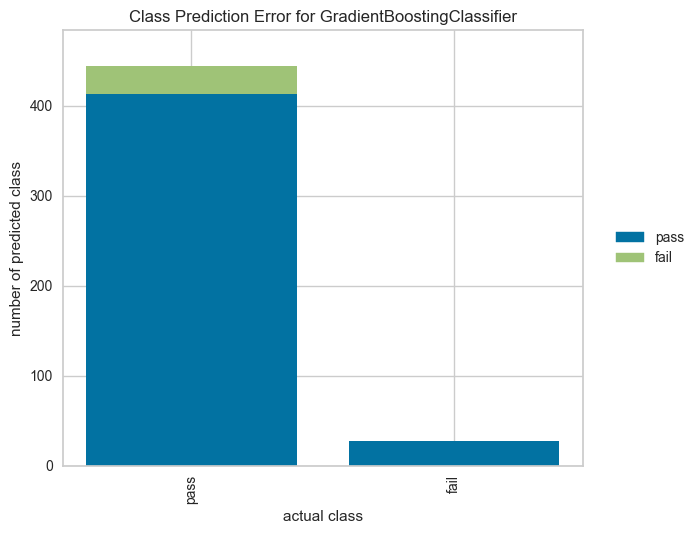

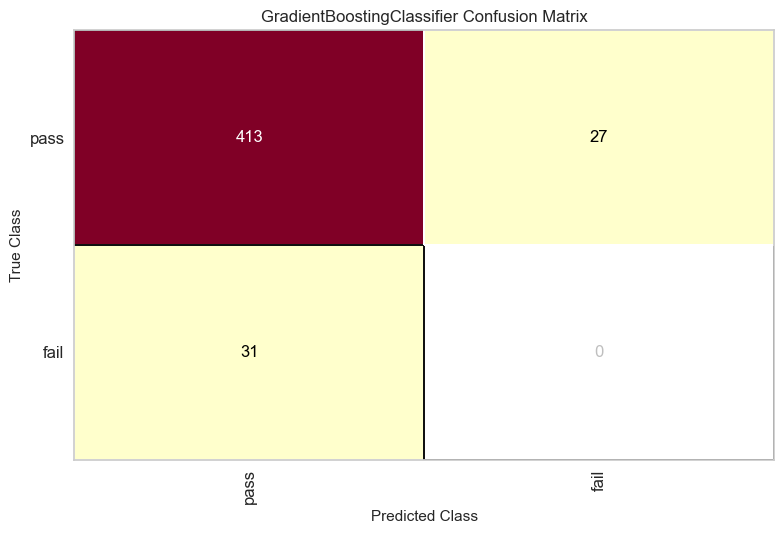

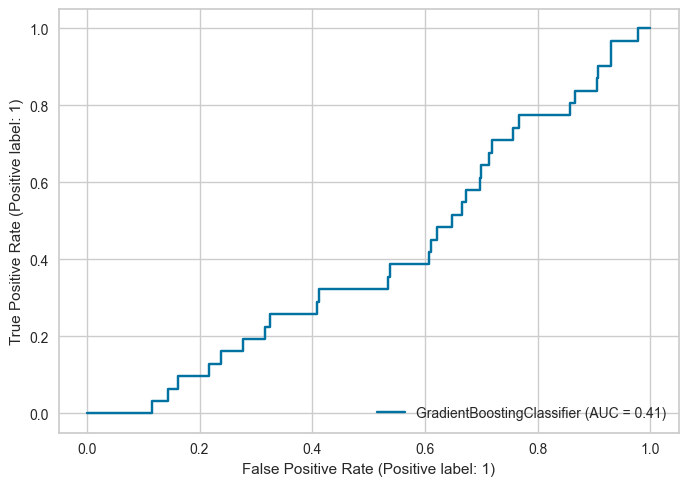

'Run time: 31.970594882965088, F1-score: 0.8768577494692144, MCC: -0.06545531326330992'

In [425]:
evaluate(X_train_svd, X_test_svd, y_train_balanced, y_test, GradientBoostingClassifier())

Interestingly enough the Logistic regression gained about 0.03 in the F1 when applying either a PCA or SVD, while the tree based algorithms (RF and GBM) don't care that much in terms of F1 score. However, there is still utility in applying dimension reduction for the RF and GBM, because this reduced the computation time by at least  

### Feature selection 

We used two dimension reduction techniques, which compressed the many features we have into components, which we use for modeling. F1 scores were high and with parameter tuning we can achieve even better results, although the final call will be on the test dataset, which we haven't used yet. However we have a serious drawback here, we don't know, which features work best at predicting a pass or fail.

We could gauge, which component is the best feature in our model, but a component is composed of several features (and not in a straight forward manner). If our goal is to know, which are the best features so we can exclude the rest, the dimension reduction via PCA or SVD are not appropriate. What we need to do is to reduced the dimension directly by selecting only the best features or by features selection.

#### Manual feature selection

The approach here will be to manually apply three principles basically and the approach is inspired by [Matt Namvarpour's Notebook](https://www.kaggle.com/code/halflingwizard/feature-selection-from-600-to-17-features) on the Semi-conductor's dataset. These include:
1. Exclude features with zero or close to zero variance
2. Exclude features with high pairwise correlation
3. Exclude features with a low correlation with our target   

##### Remove low variance features

For the removal of features with low variance we will used the `VarianceThreshold` from `sklearn`

In [426]:
selector = VarianceThreshold()
selector.fit(X_train_scaled)

VarianceThreshold()

In [427]:
mask = selector.get_support()
columns = X_train.columns
selected_cols = columns[mask]
n_features = len(selected_cols)
print(f'remaining features: {n_features}')

remaining features: 414


In [428]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns = columns)
X_train_scaled_df = X_train_scaled_df[selected_cols]
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns = columns)
X_test_scaled_df = X_test_scaled_df[selected_cols]
X_train_scaled_df.shape

(2046, 414)

##### Remove high pairwise variance

Let us define a helpful function to remove highly correlated features. Here I will be applying a general rule of thumb that correlation of 0.5 between features is undesirable.

In [429]:
def correlation(dataset, threshold):
    '''Get list of pairwise correlated features that surpass a given threshold'''
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [430]:
corr_features = correlation(X_train_scaled_df, 0.5)
X_train_corr = X_train_scaled_df.drop(corr_features, axis=1)
X_test_corr = X_test_scaled_df.drop(corr_features, axis=1)
n_features3 = X_train_corr.shape[1]
print(f'After removing {len(corr_features)} features, there are {n_features3} features left.')

After removing 238 features, there are 176 features left.


#### Remove features that are weakly correlated with the target

In [431]:
def corrwith_target(dataframe, target, threshold):
    '''Get list of features correlated with the target that are below a given threshold'''
    cor = dataframe.corr()
    #Correlation with output variable
    cor_target = abs(cor[target])
    #Selecting non correlated features
    relevant_features = cor_target[cor_target<threshold]
    return relevant_features.index.tolist()[:-1]

In [432]:
# in order to find the correlation with target, I have to add target as a column to X_train_corr
dummy_train = X_train_corr.copy()
dummy_train['target'] = y_train

In [433]:
corrwith_cols = corrwith_target(dummy_train, 'target', 0.025)
X_train_corw = X_train_corr.drop(corrwith_cols, axis=1)
X_test_corw = X_test_corr.drop(corrwith_cols, axis=1)
n_features4 = X_train_corw.shape[1]
print(f'After removing {len(corrwith_cols)} features, there are {n_features4} features left.')

After removing 105 features, there are 71 features left.


Well this is a significant drop from 530 features to 56. Lets see if the remaining 56 features are sufficient for predicting the target.

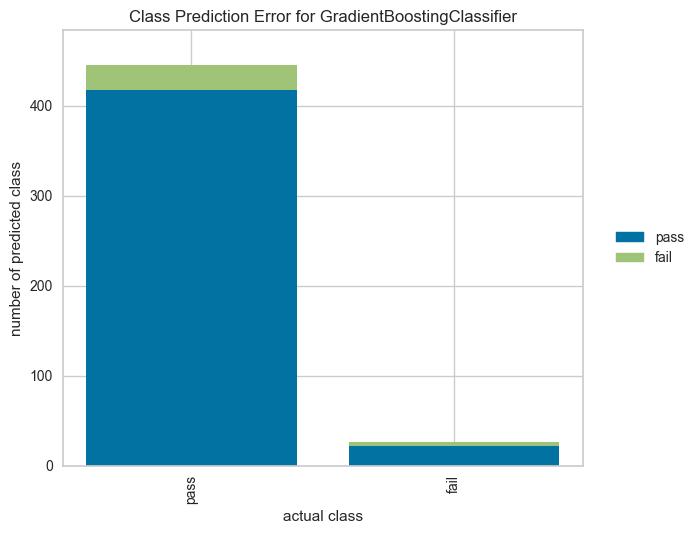

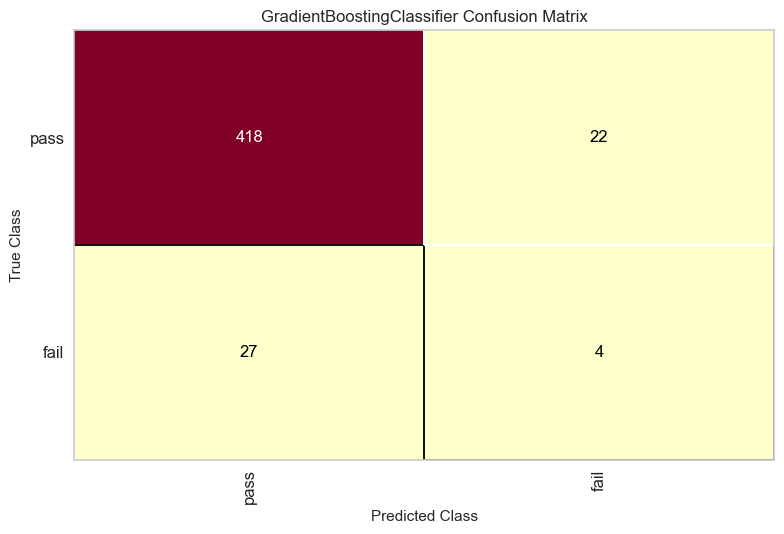

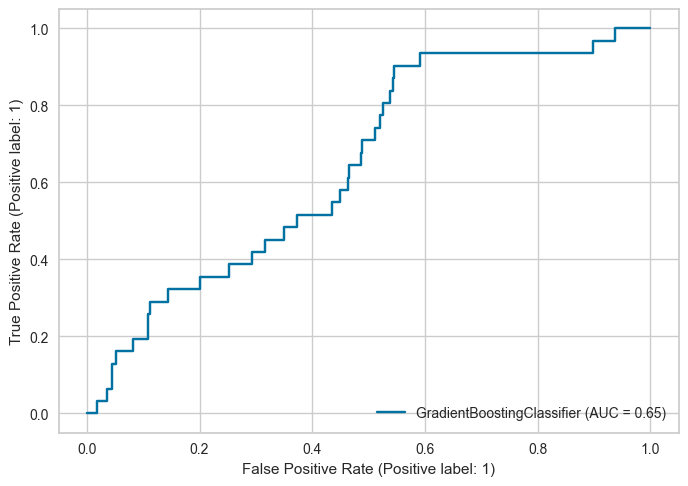

'Run time: 14.897005319595337, F1-score: 0.8959660297239915, MCC: 0.0858113819674024'

In [434]:
evaluate(X_train_corw, X_test_corw, y_train_balanced, y_test, GradientBoostingClassifier())

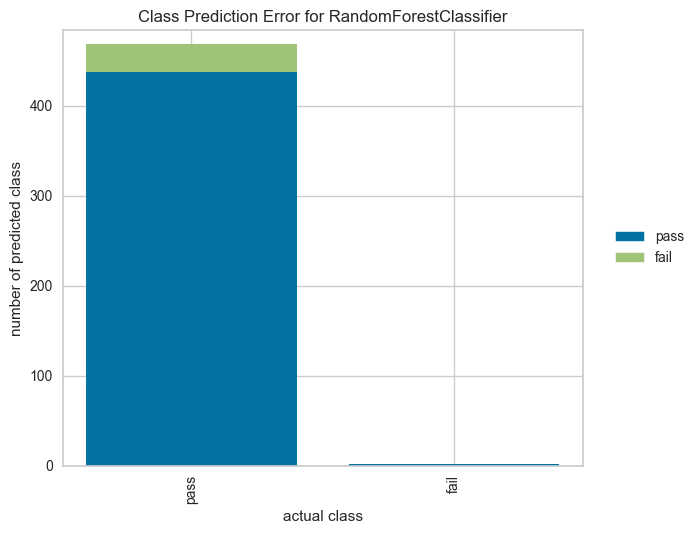

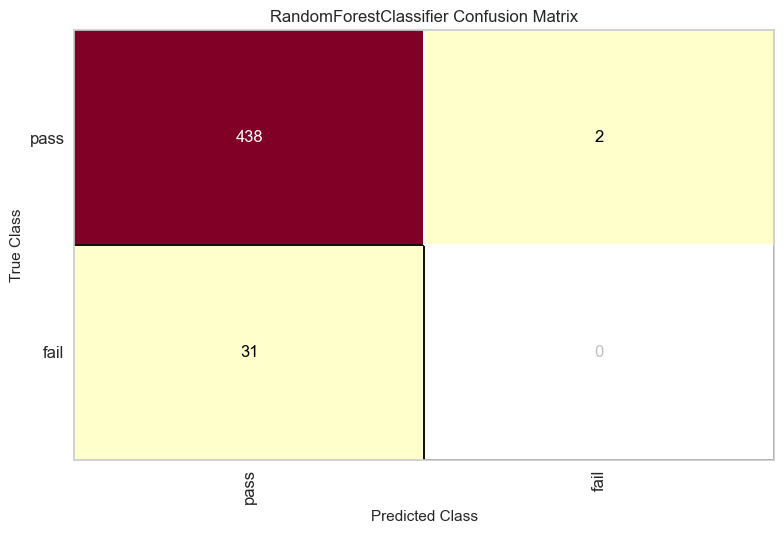

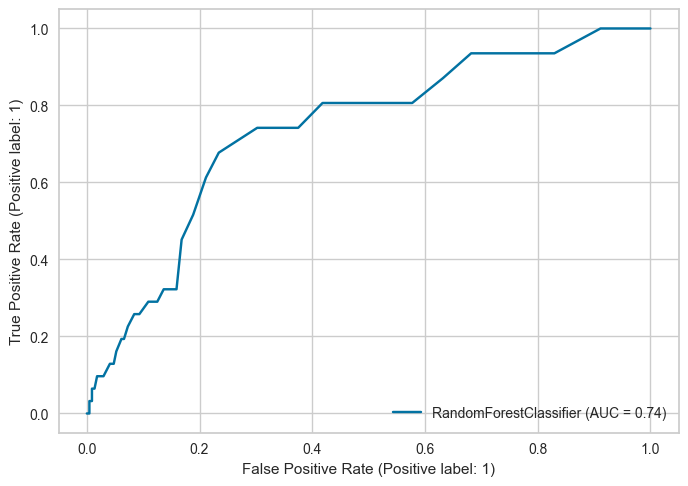

'Run time: 5.642891883850098, F1-score: 0.9299363057324841, MCC: -0.017333373094521518'

In [435]:
evaluate(X_train_corw, X_test_corw, y_train_balanced, y_test, RandomForestClassifier())

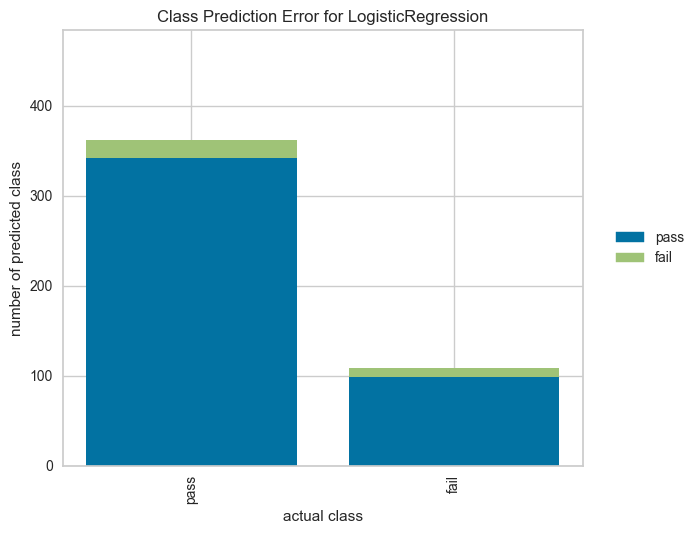

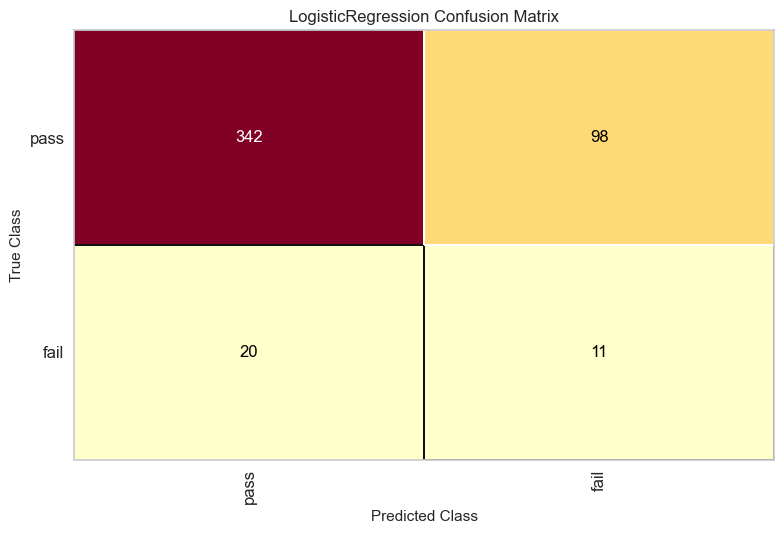

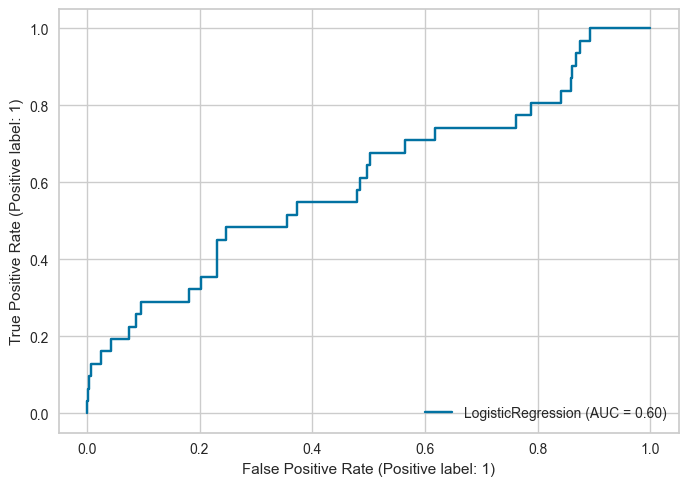

'Run time: 0.03125405311584473, F1-score: 0.7494692144373672, MCC: 0.07767478632764149'

In [436]:
evaluate(X_train_corw, X_test_corw, y_train_balanced, y_test, LogisticRegression())

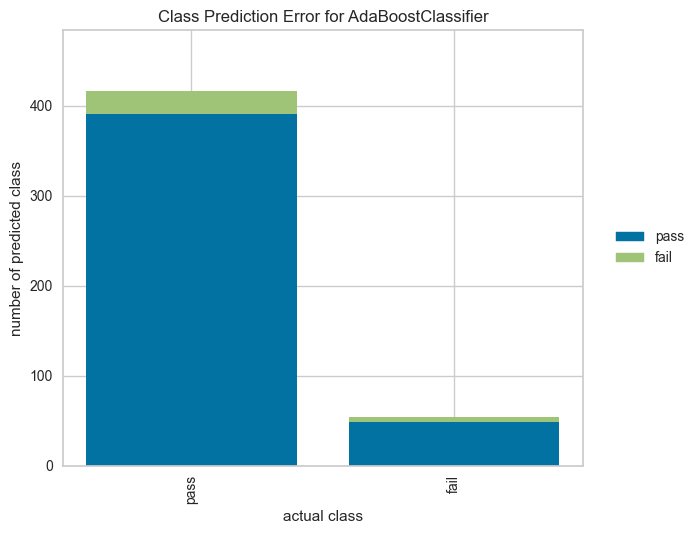

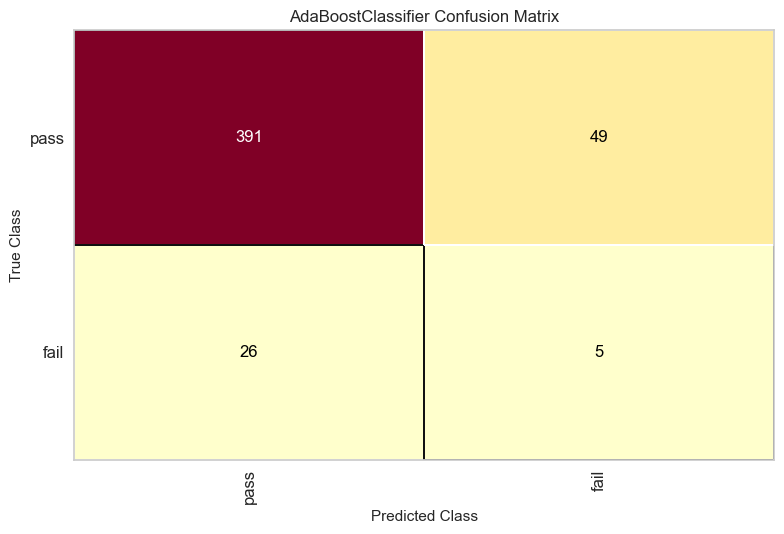

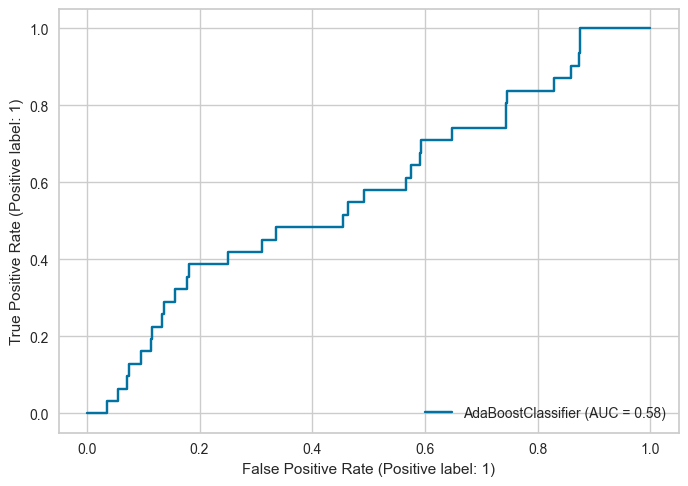

'Run time: 2.6430678367614746, F1-score: 0.8407643312101911, MCC: 0.03885751464448015'

In [437]:
evaluate(X_train_corw, X_test_corw, y_train_balanced, y_test, AdaBoostClassifier())

#### LASSO Regularization feature selection 

Regularization consists of adding a penalty to the different parameters of the machine learning model to reduce the freedom of the model, i.e., to avoid over-fitting. In linear model regularization, the penalty is applied over the coefficients that multiply each predictor. From the different types of regularization, Lasso or L1 has the property that can shrink some of the coefficients to zero. Therefore, that feature can be removed from the model.

In [438]:
logistic = LogisticRegression(C=1, penalty='l1', solver='liblinear', random_state=7).fit(X_train_balanced, y_train_balanced)
model = SelectFromModel(logistic, prefit=True, )

X_train_new = model.fit_transform(X_train_balanced)
columns_lasso = model.get_feature_names_out()
X_train_lasso = pd.DataFrame(X_train_new, columns=columns_lasso)
X_test_lasso = pd.DataFrame(X_test, columns=columns_lasso)


In [439]:
X_train_lasso.shape

(2046, 196)

We see that LASSO reduced the features from 530 to 195. Lets test them out with the three models.

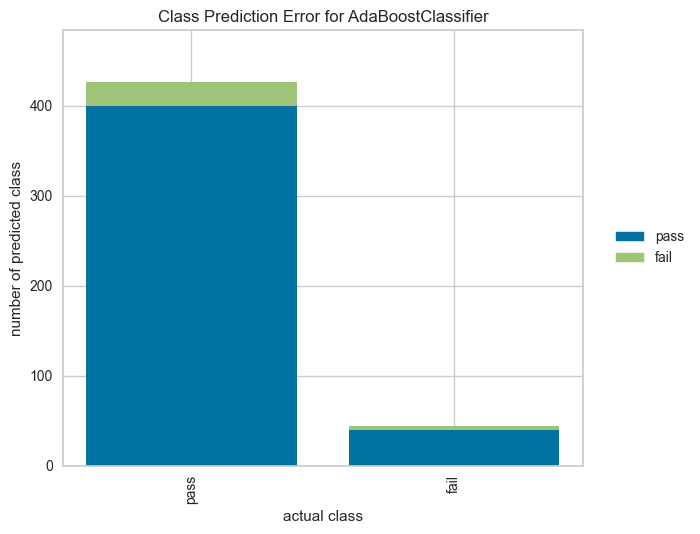

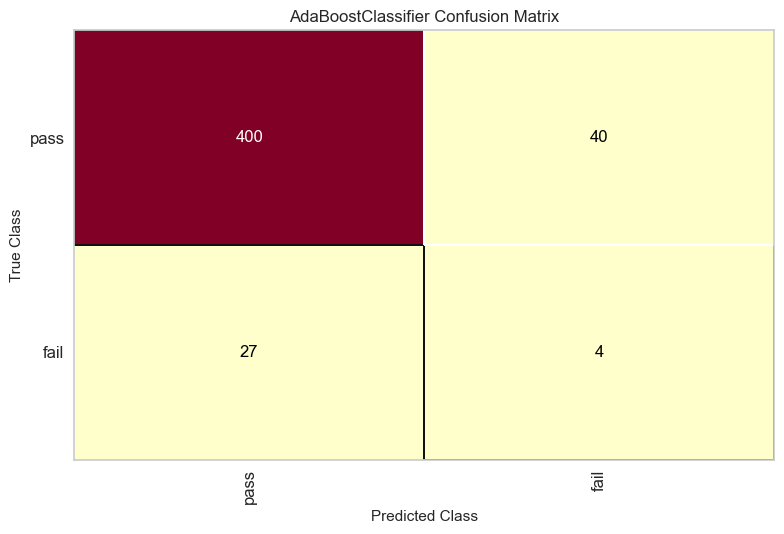

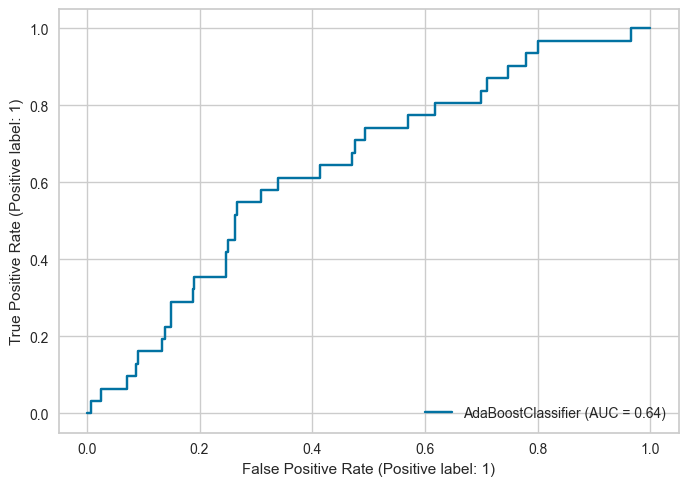

'Run time: 8.049582242965698, F1-score: 0.8577494692144374, MCC: 0.032482981345839775'

In [440]:
evaluate(X_train_lasso, X_test_lasso, y_train_balanced, y_test, AdaBoostClassifier())

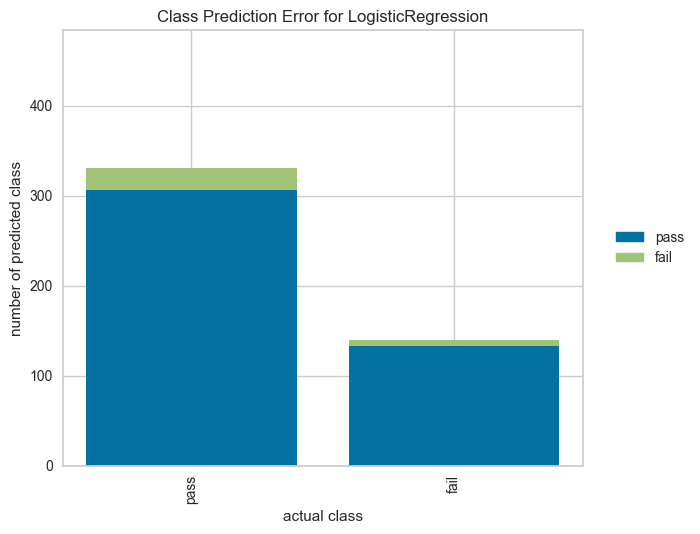

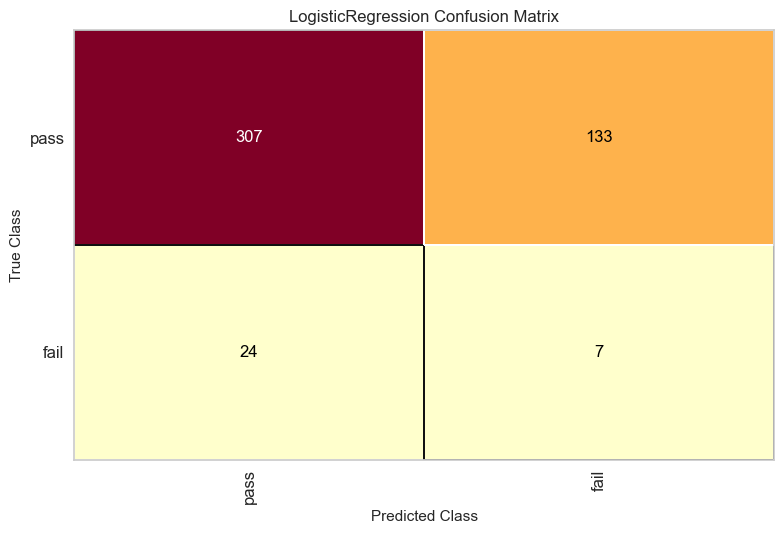

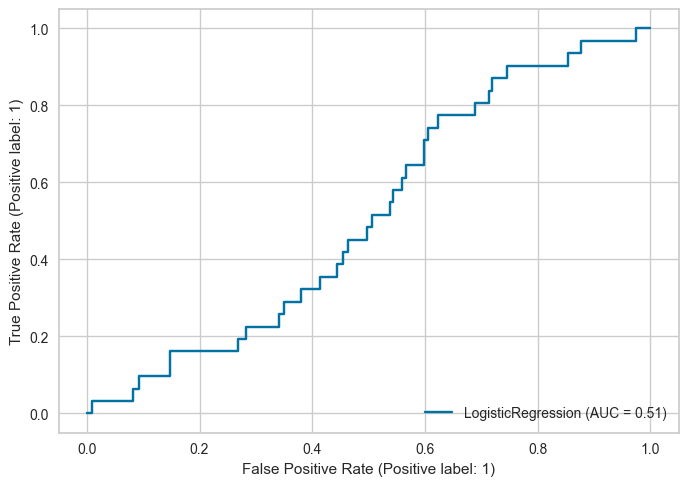

'Run time: 0.14307618141174316, F1-score: 0.6666666666666666, MCC: -0.041485765537017806'

In [441]:
evaluate(X_train_lasso, X_test_lasso, y_train_balanced, y_test, LogisticRegression())

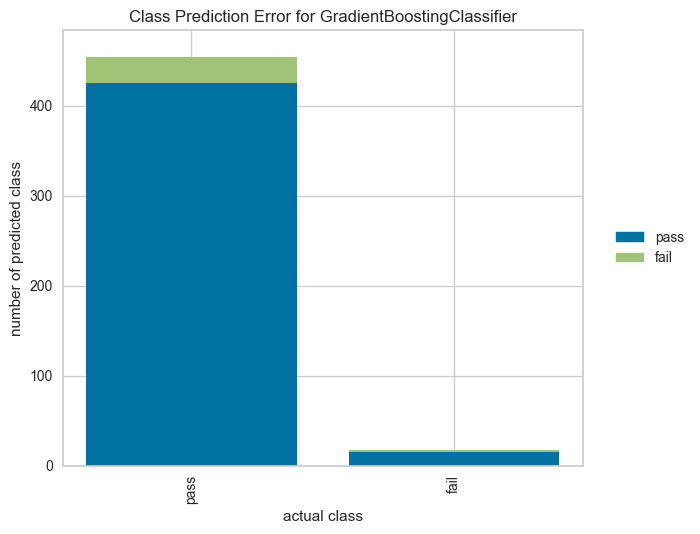

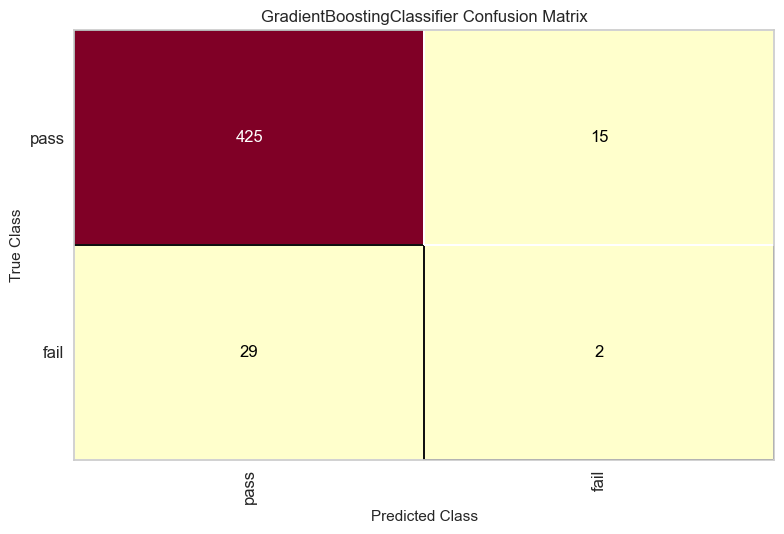

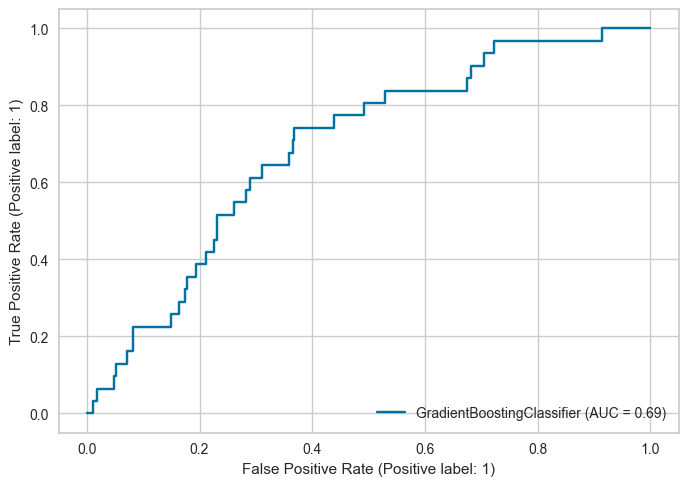

'Run time: 44.32334804534912, F1-score: 0.9065817409766455, MCC: 0.04044720576848073'

In [442]:
evaluate(X_train_lasso, X_test_lasso, y_train_balanced, y_test, GradientBoostingClassifier())

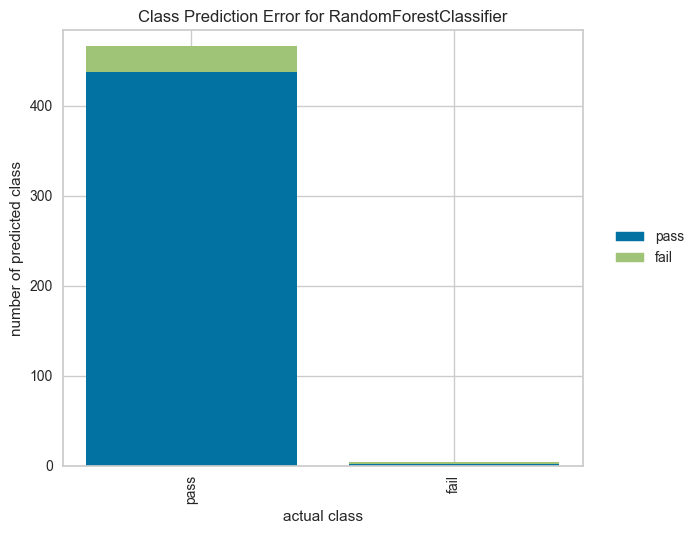

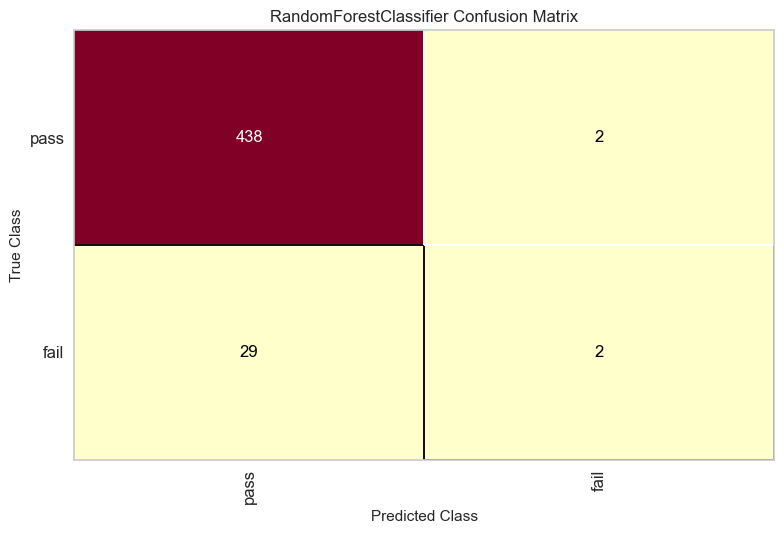

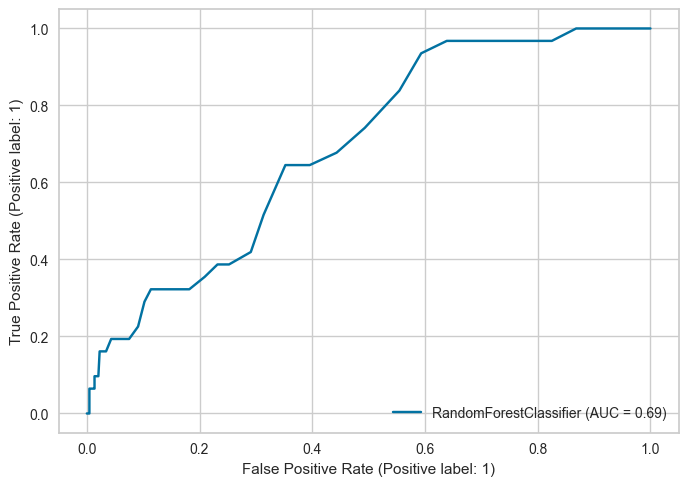

'Run time: 9.325851678848267, F1-score: 0.9341825902335457, MCC: 0.16205322659414886'

In [443]:
evaluate(X_train_lasso, X_test_lasso, y_train_balanced, y_test, RandomForestClassifier())

##### Random Forest Importance

In [444]:
model = RandomForestClassifier()
model.fit(X_train_balanced, y_train_balanced)

importance = model.feature_importances_

importance_df = pd.DataFrame({"Features" : X_train.columns,
                              "Importance" : importance})

importance_df = importance_df.sort_values('Importance')


<Axes: >

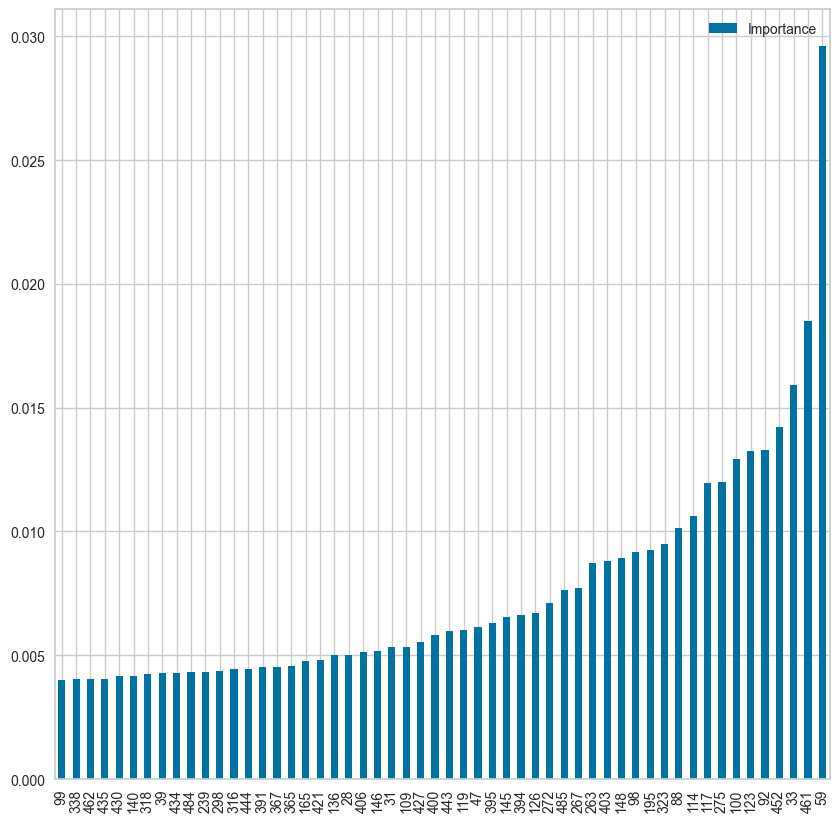

In [445]:
importance_df_filtered_1 = importance_df[importance_df['Importance']>0.004]
importance_df_filtered_1.plot.bar(figsize = (10,10))

There is something odd about feature 59. Lets take a step back a look at in in the whole dataset.

In [446]:
importance_df_filtered_1.shape

(54, 2)

<Axes: >

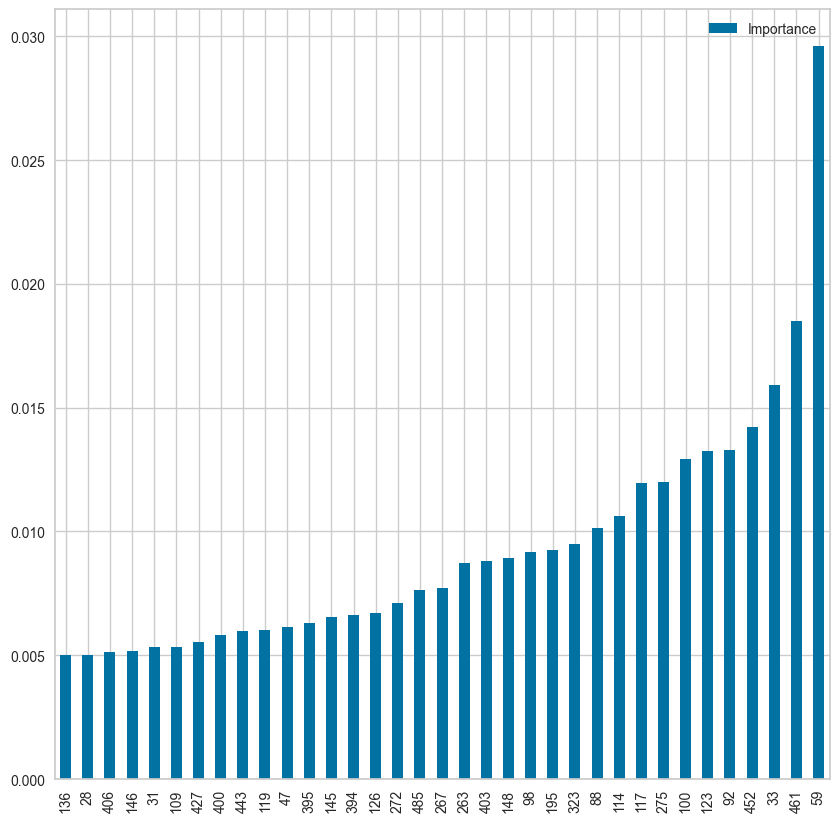

In [447]:
importance_df_filtered_2 = importance_df[importance_df['Importance']>0.005]
importance_df_filtered_2.plot.bar(figsize = (10,10))

In [448]:
importance_df_filtered_2.shape

(35, 2)

Initially the graph was hard to make out because it included all of the features but after applying a filter of > 0.04 importance we get 54 features and with > 0.05 we get 35. I am pretty sure that the RF will be our final model, but for the sake of consistency let us test out the 54 and 35 feature dataset on all try models. 

In [449]:
X_train_rf1 = X_train_balanced[(importance_df_filtered_1['Features'])]
X_test_rf1 = X_test[(importance_df_filtered_1['Features'])]
X_train_rf1.shape

(2046, 54)

In [450]:
X_train_rf2 = X_train_balanced[(importance_df_filtered_2['Features'])]
X_test_rf2 = X_test[(importance_df_filtered_2['Features'])]
X_train_rf2.shape

(2046, 35)

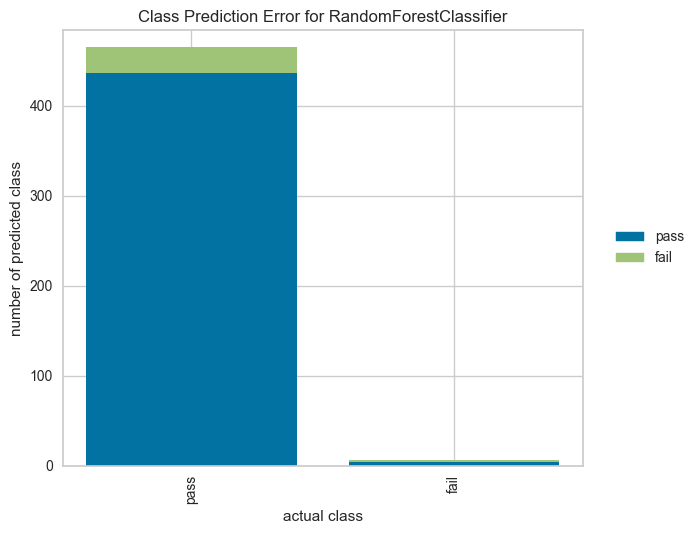

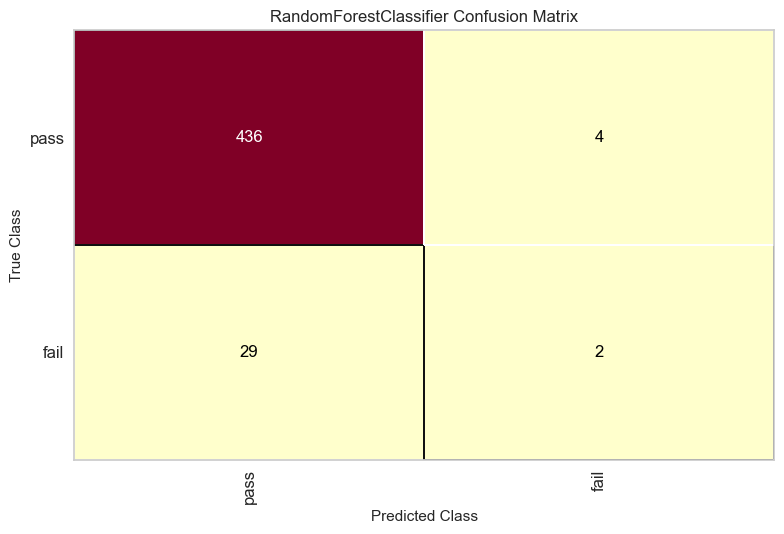

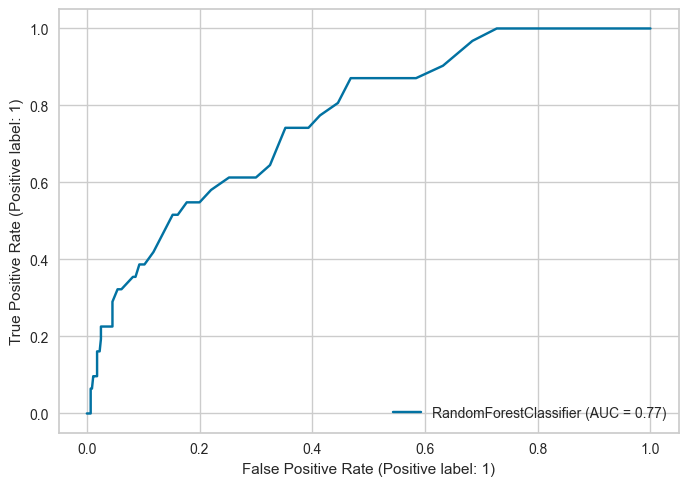

'Run time: 4.657764434814453, F1-score: 0.9299363057324841, MCC: 0.12254977231225231'

In [451]:
evaluate(X_train_rf1, X_test_rf1, y_train_balanced, y_test, RandomForestClassifier())

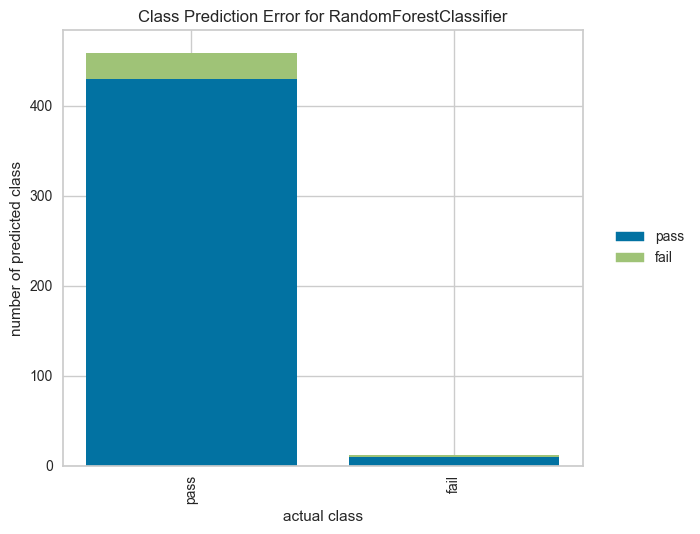

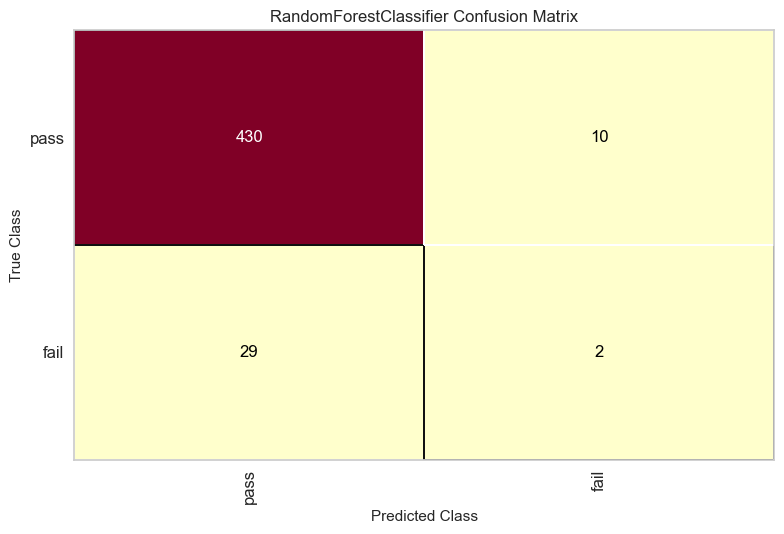

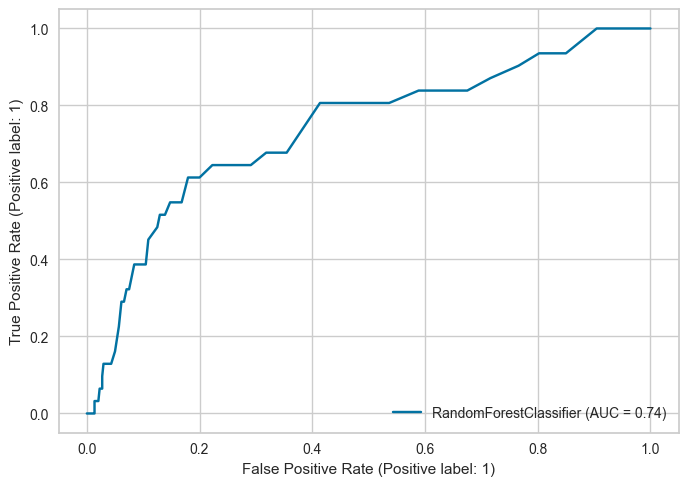

'Run time: 2.967491388320923, F1-score: 0.9171974522292994, MCC: 0.06576134766241092'

In [453]:
evaluate(X_train_rf2, X_test_rf2, y_train_balanced, y_test, RandomForestClassifier())

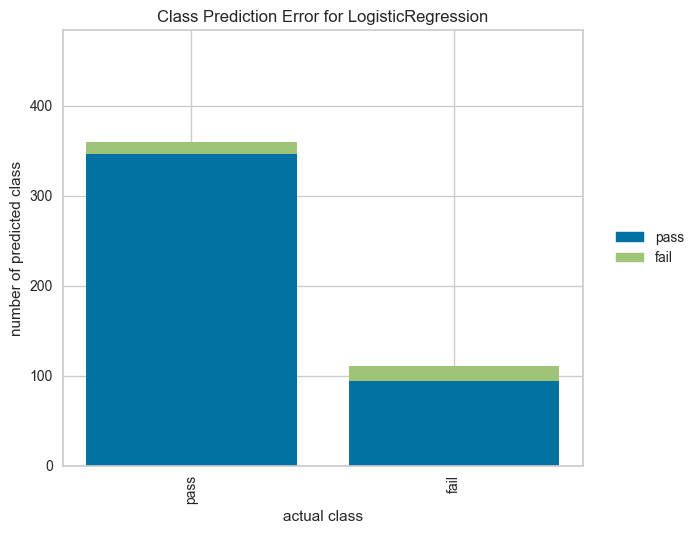

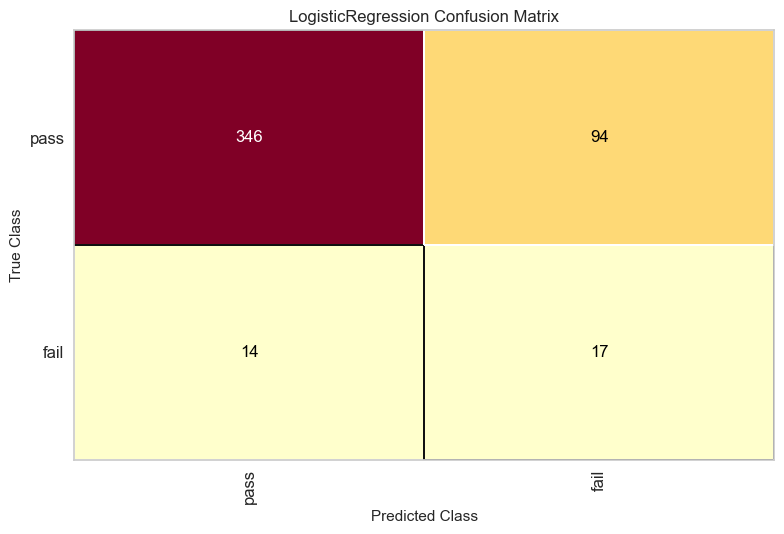

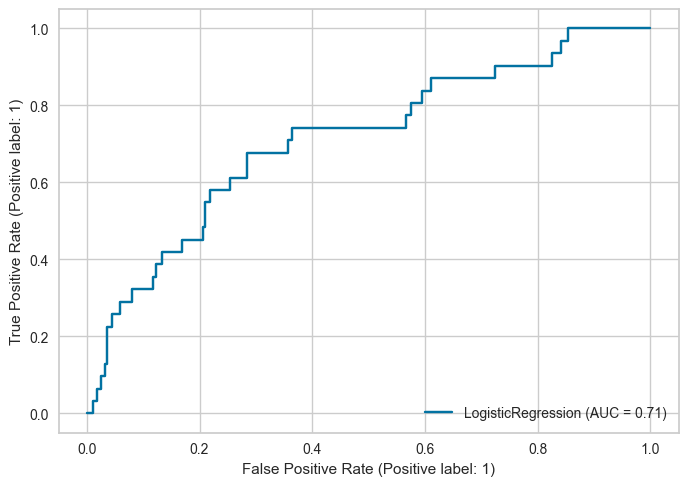

'Run time: 0.09713125228881836, F1-score: 0.7707006369426752, MCC: 0.19557619035536306'

In [452]:
evaluate(X_train_rf1, X_test_rf1, y_train_balanced, y_test, LogisticRegression())

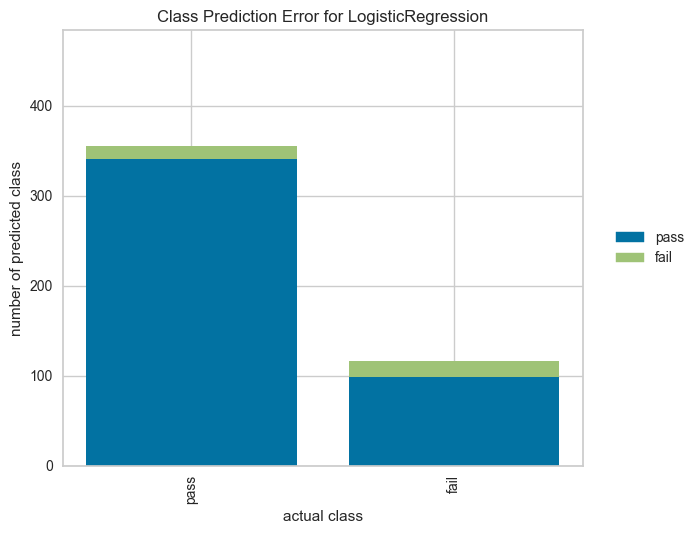

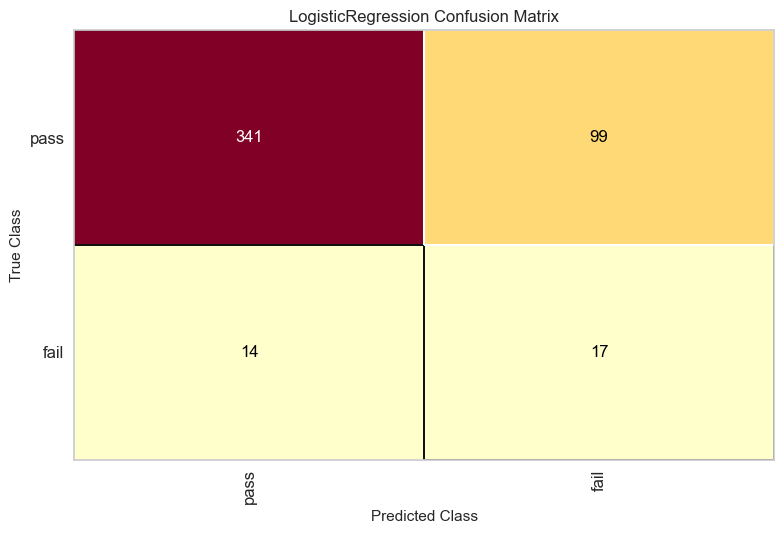

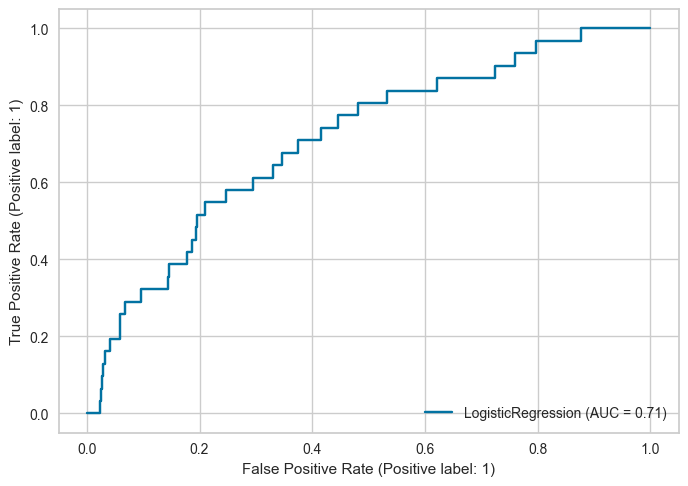

'Run time: 0.08399438858032227, F1-score: 0.7600849256900214, MCC: 0.18611728194588992'

In [454]:
evaluate(X_train_rf2, X_test_rf2, y_train_balanced, y_test, LogisticRegression())

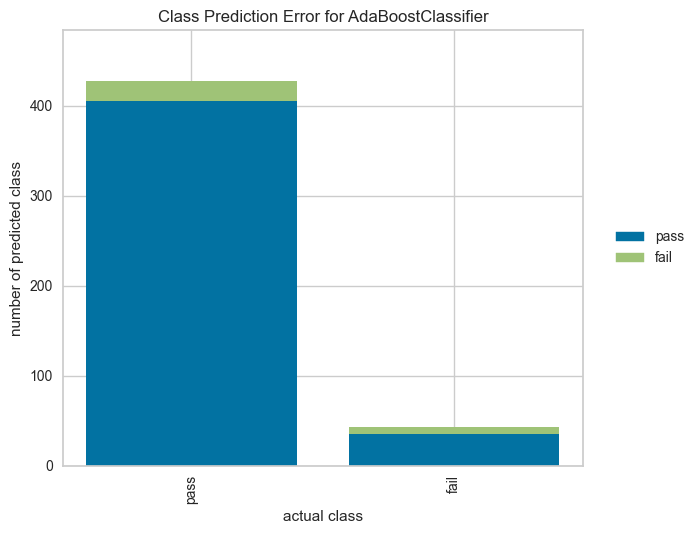

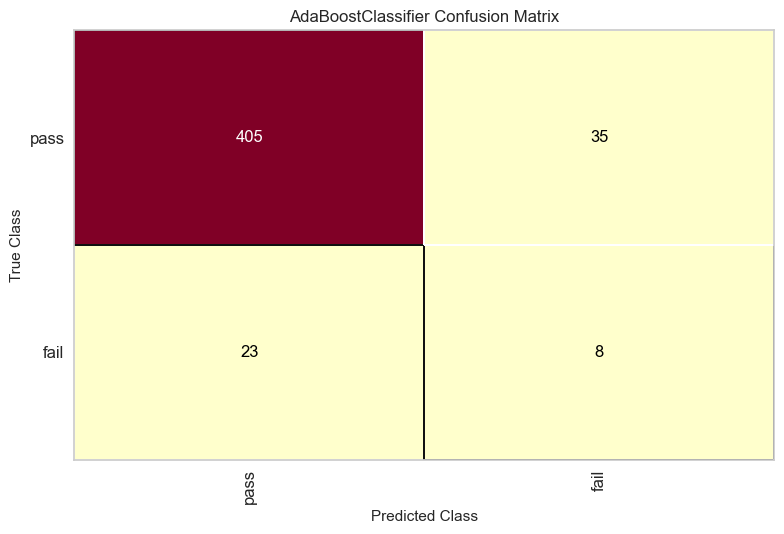

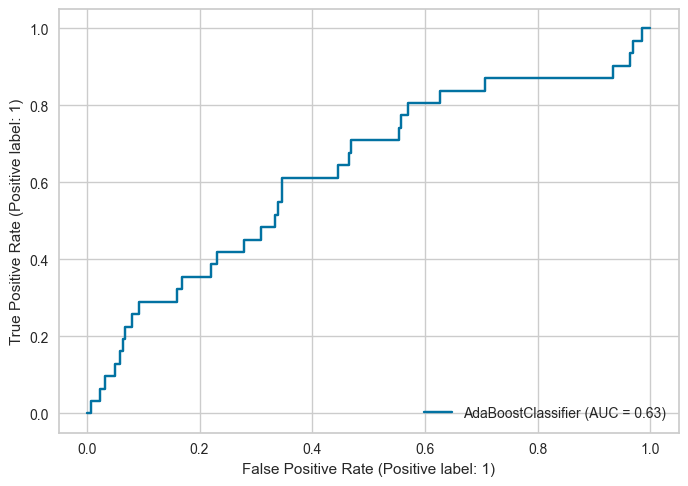

'Run time: 2.2239608764648438, F1-score: 0.8768577494692144, MCC: 0.15368648154489942'

In [455]:
evaluate(X_train_rf1, X_test_rf1, y_train_balanced, y_test, AdaBoostClassifier())

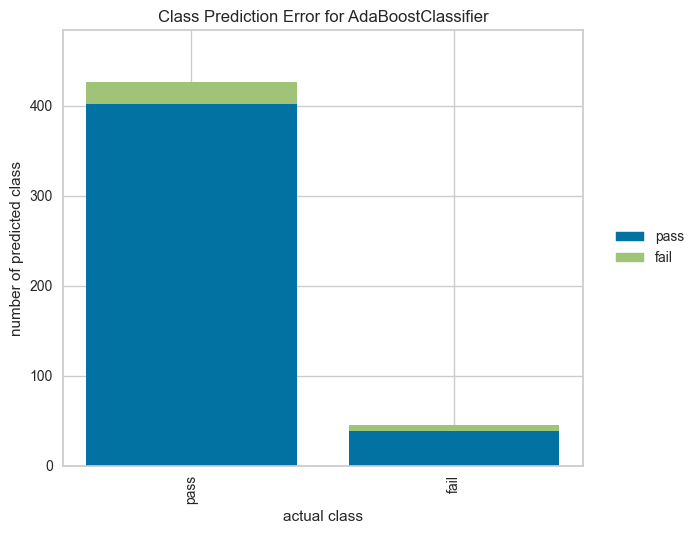

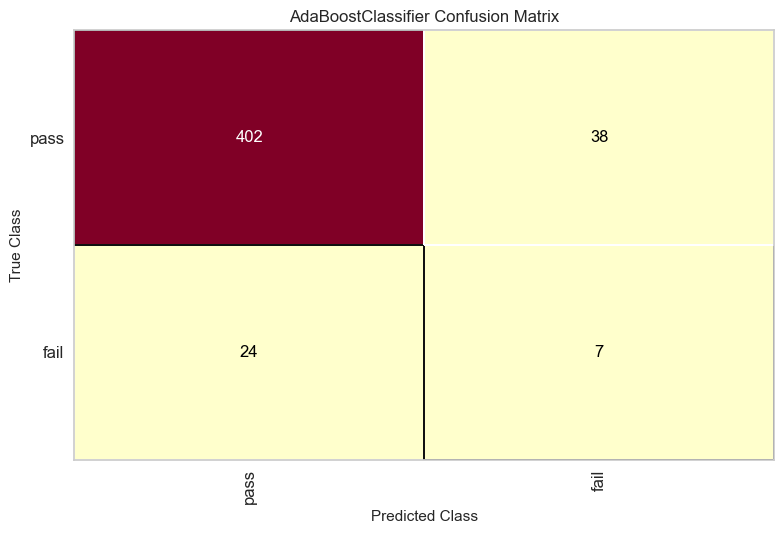

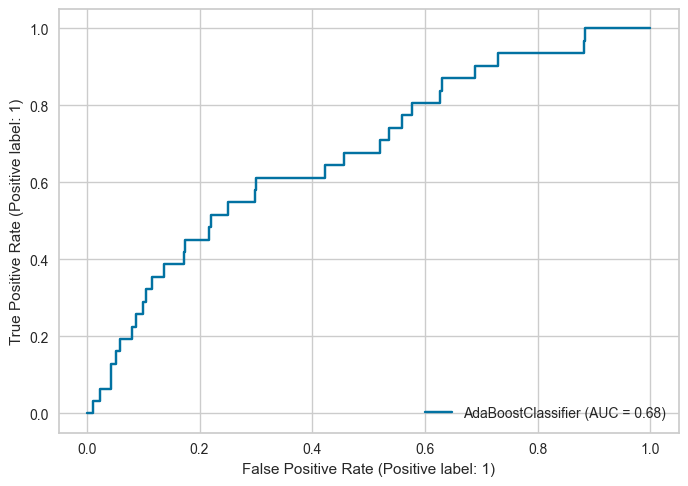

'Run time: 1.447190284729004, F1-score: 0.8683651804670913, MCC: 0.11762300515141831'

In [456]:
evaluate(X_train_rf2, X_test_rf2, y_train_balanced, y_test, AdaBoostClassifier())

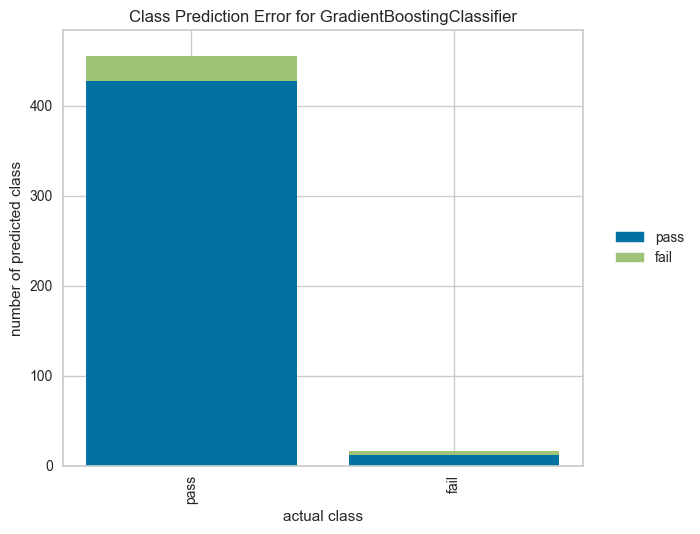

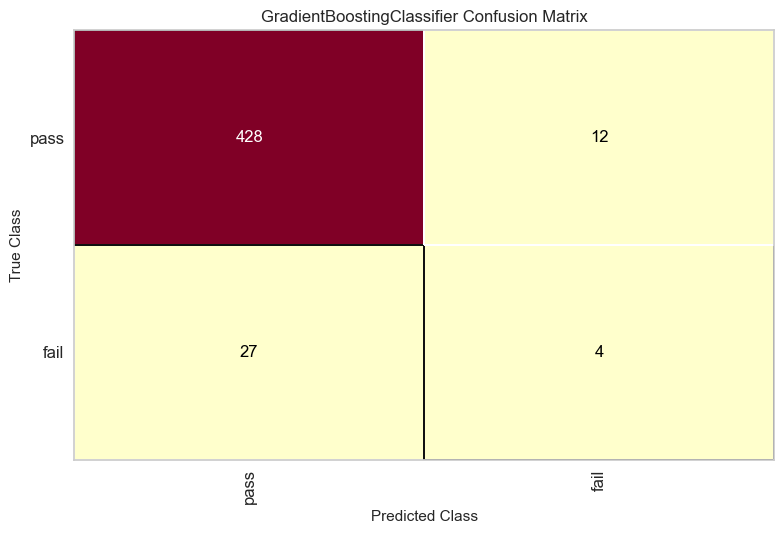

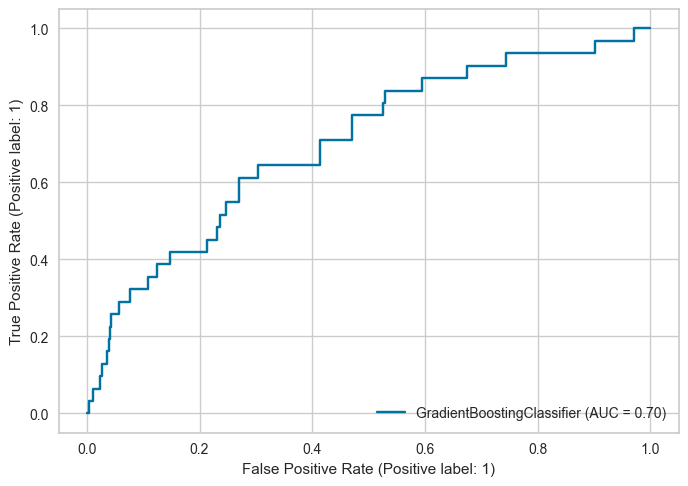

'Run time: 11.484697818756104, F1-score: 0.9171974522292994, MCC: 0.13928892650374738'

In [457]:
evaluate(X_train_rf1, X_test_rf1, y_train_balanced, y_test, GradientBoostingClassifier())

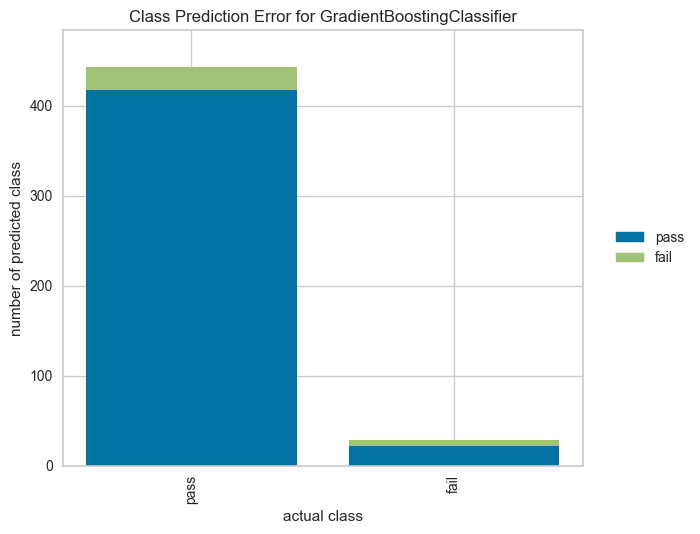

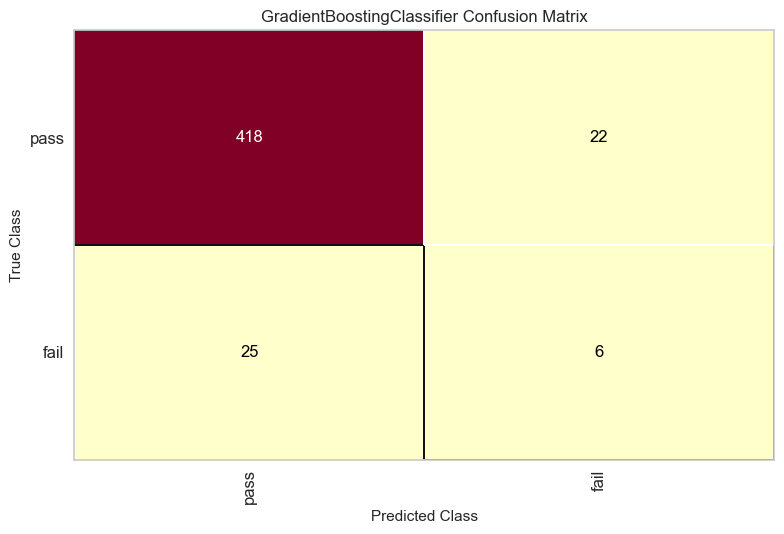

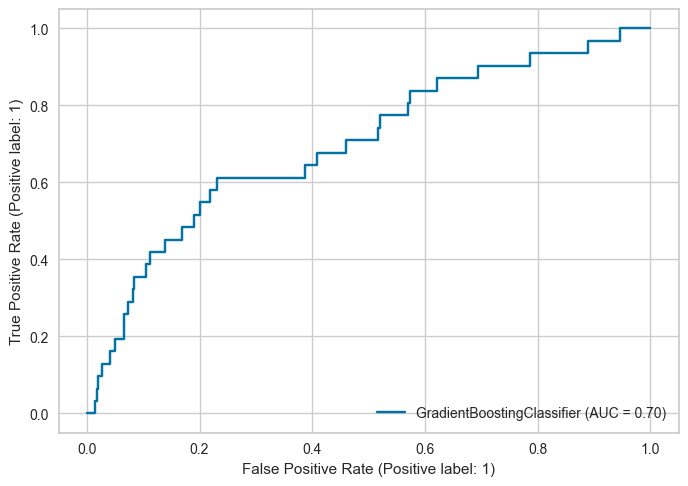

'Run time: 7.108341455459595, F1-score: 0.9002123142250531, MCC: 0.15053054136575342'

In [458]:
evaluate(X_train_rf2, X_test_rf2, y_train_balanced, y_test, GradientBoostingClassifier())

Let us check for high correlation between the features

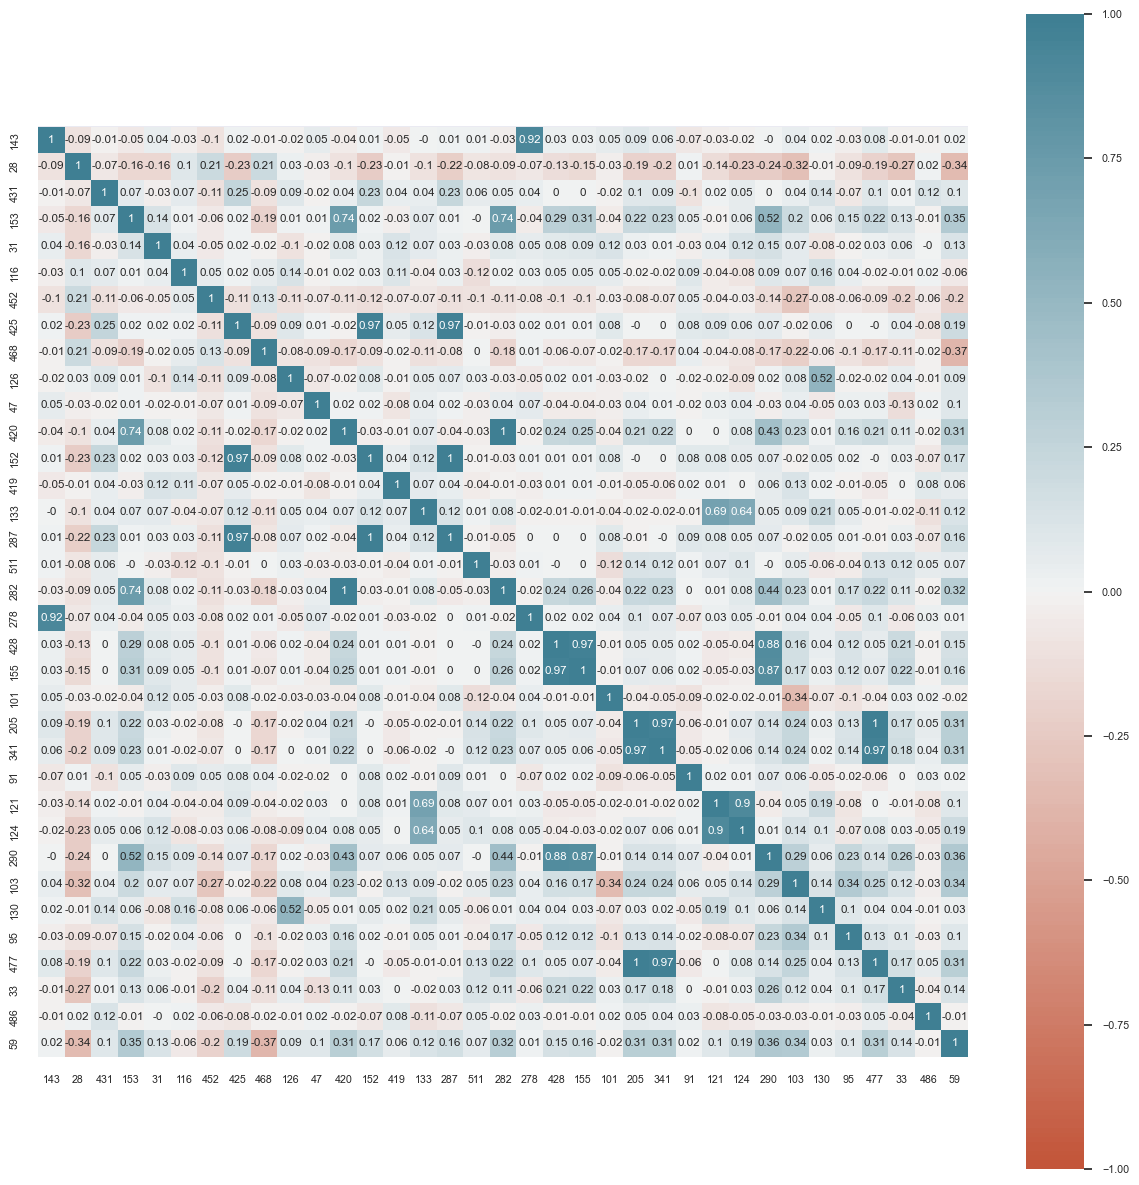

In [461]:
cormat = round(X_train_rf2.corr(),2)
fig, ax = plt.subplots(figsize=(15,15)) 

sns.set(font_scale=0.7) 
ax = sns.heatmap(
    cormat, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, annot=True
)


Now we see that we have highly correlated features, which is always bad regardless of the model type. In essence the modal will "act" like the pairwise correlated features are two times more important the features with no such correlation. Let us apply the function we used earlier for the 54 and 35 features dataset and apply the prediction once more.   

In [462]:
corr_features = correlation(X_train_rf1, 0.5)
X_train_rf1_cr = X_train_rf1.drop(corr_features, axis=1)
X_test_rf1_cr = X_test_rf1.drop(corr_features, axis=1)
n_features3 = X_train_rf1_cr.shape[1]
print(f'After removing {len(corr_features)} features, there are {n_features3} features left.')

After removing 21 features, there are 33 features left.


In [463]:
corr_features = correlation(X_train_rf2, 0.5)
X_train_rf2_cr = X_train_rf2.drop(corr_features, axis=1)
X_test_rf2_cr = X_test_rf2.drop(corr_features, axis=1)
n_features3 = X_train_rf2_cr.shape[1]
print(f'After removing {len(corr_features)} features, there are {n_features3} features left.')

After removing 12 features, there are 23 features left.


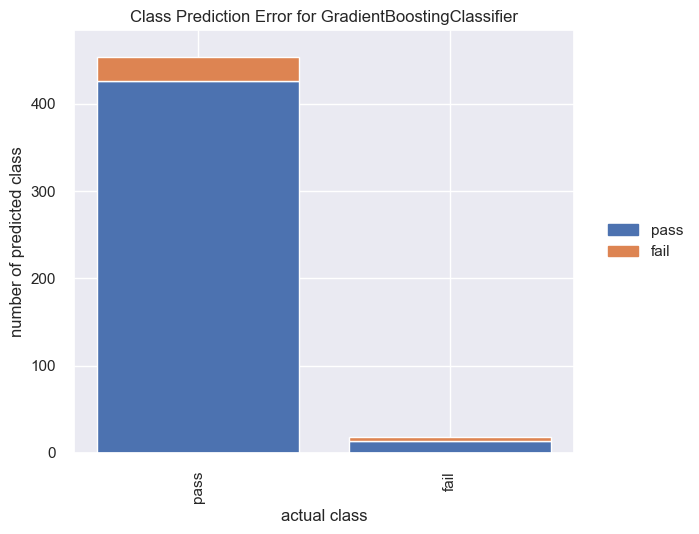

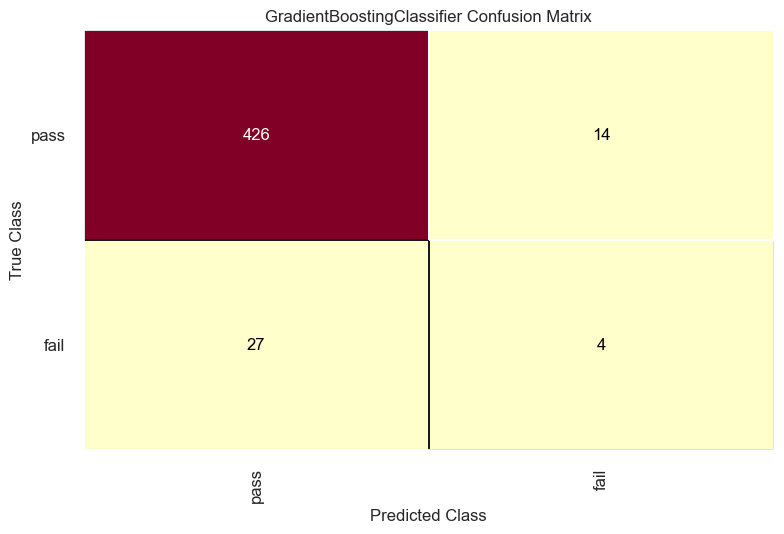

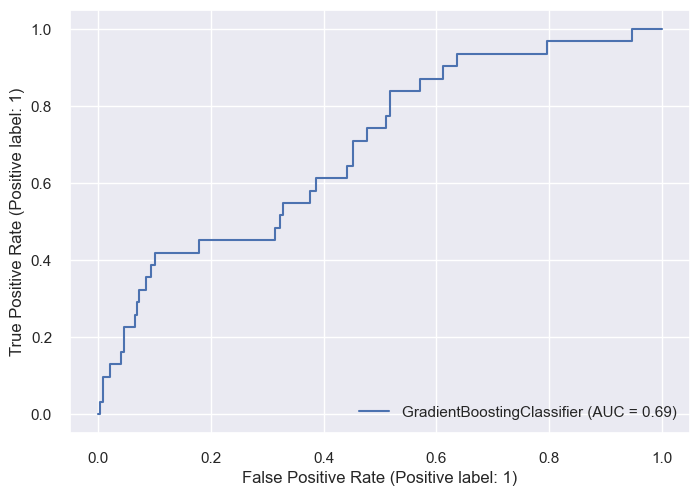

'Run time: 7.225101947784424, F1-score: 0.9129511677282378, MCC: 0.1257334943033385'

In [467]:
sns.set(font_scale=1)
evaluate(X_train_rf1_cr, X_test_rf1_cr, y_train_balanced, y_test, GradientBoostingClassifier())

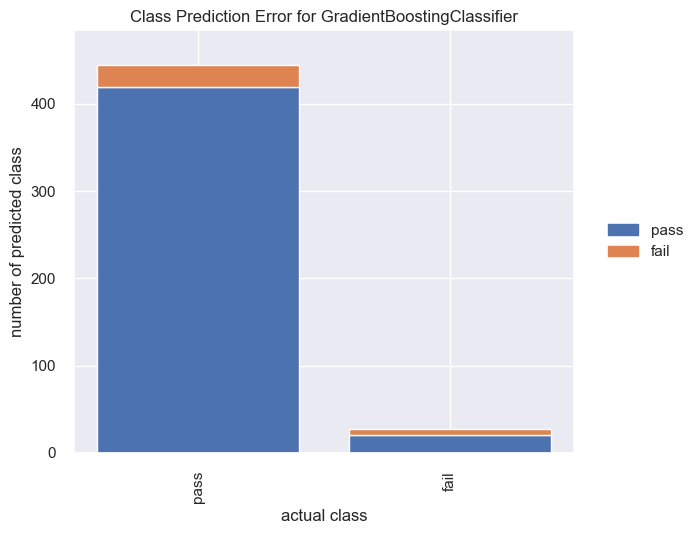

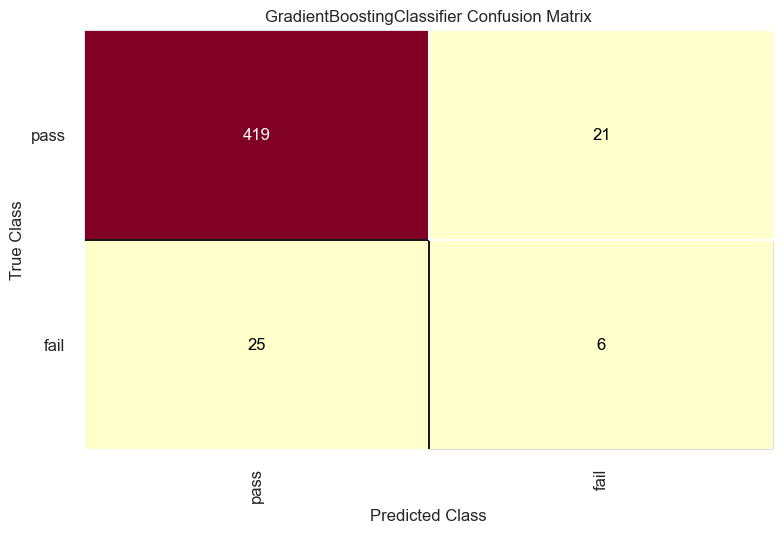

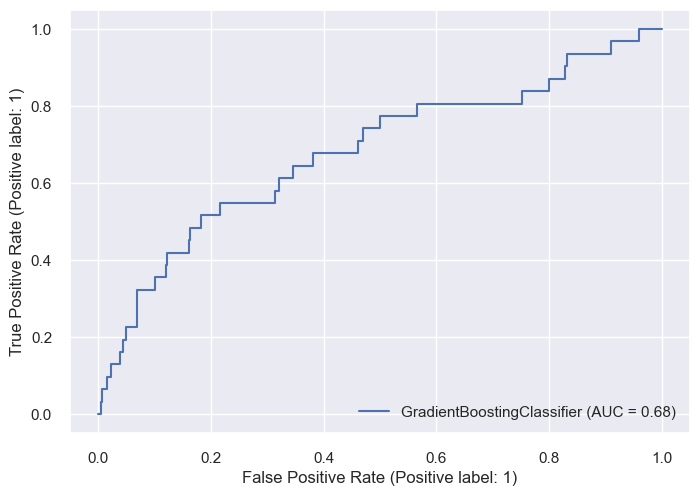

'Run time: 4.883912086486816, F1-score: 0.9023354564755839, MCC: 0.15554434657195151'

In [468]:
evaluate(X_train_rf2_cr, X_test_rf2_cr, y_train_balanced, y_test, GradientBoostingClassifier())

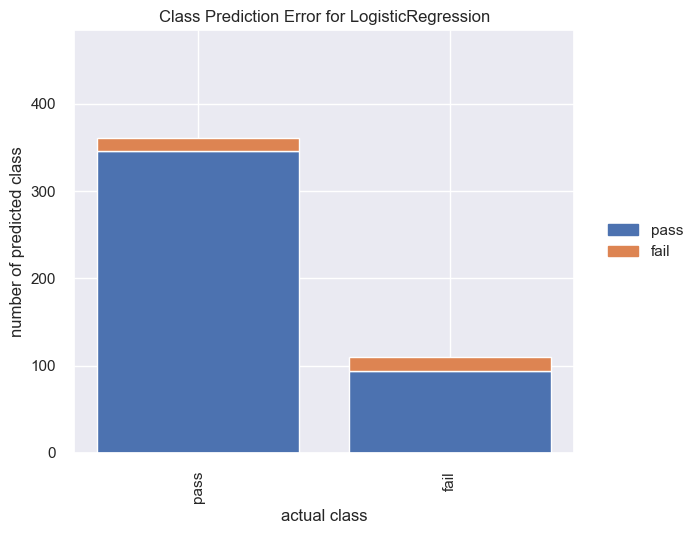

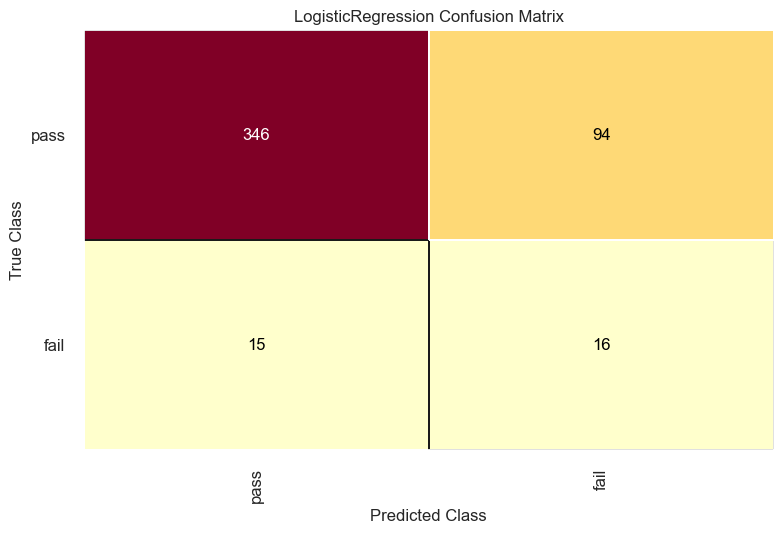

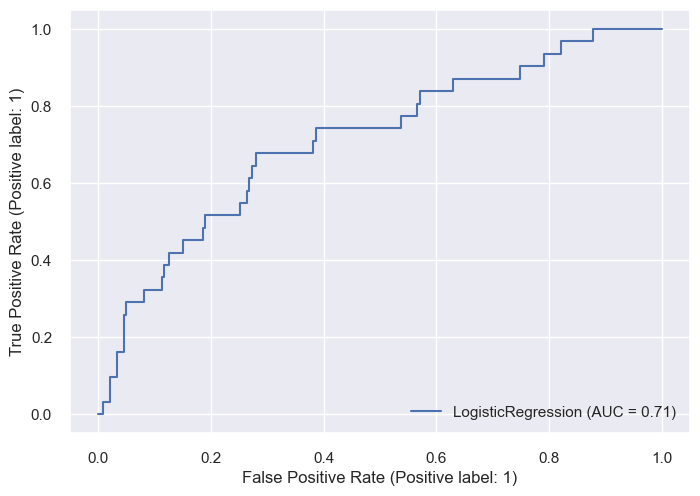

'Run time: 0.08740687370300293, F1-score: 0.7685774946921444, MCC: 0.17728504214413235'

In [469]:
evaluate(X_train_rf1_cr, X_test_rf1_cr, y_train_balanced, y_test, LogisticRegression())

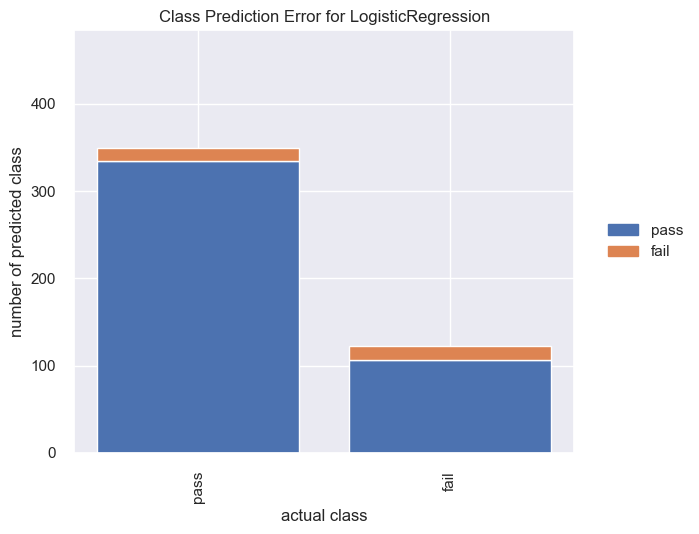

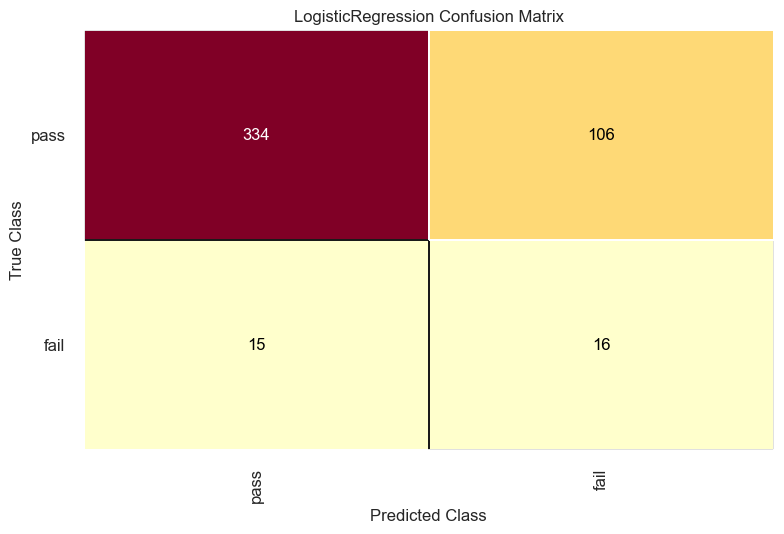

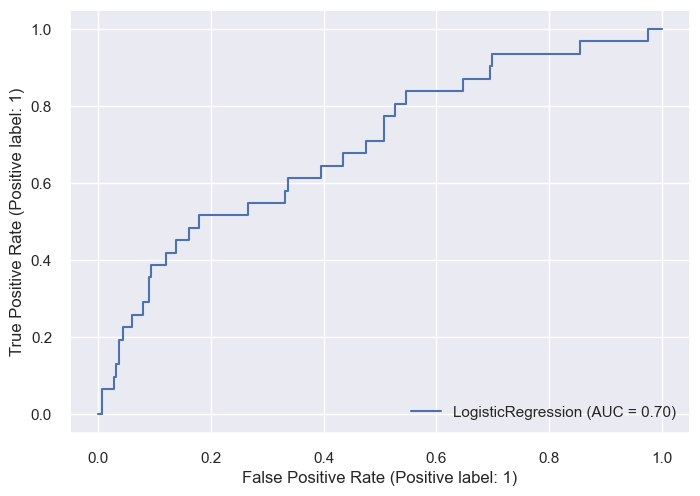

'Run time: 0.2165522575378418, F1-score: 0.7430997876857749, MCC: 0.15577381432804369'

In [470]:
evaluate(X_train_rf2_cr, X_test_rf2_cr, y_train_balanced, y_test, LogisticRegression())

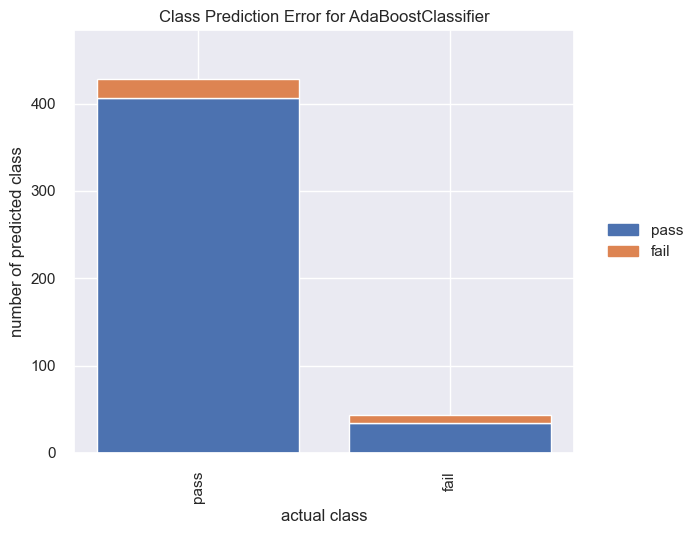

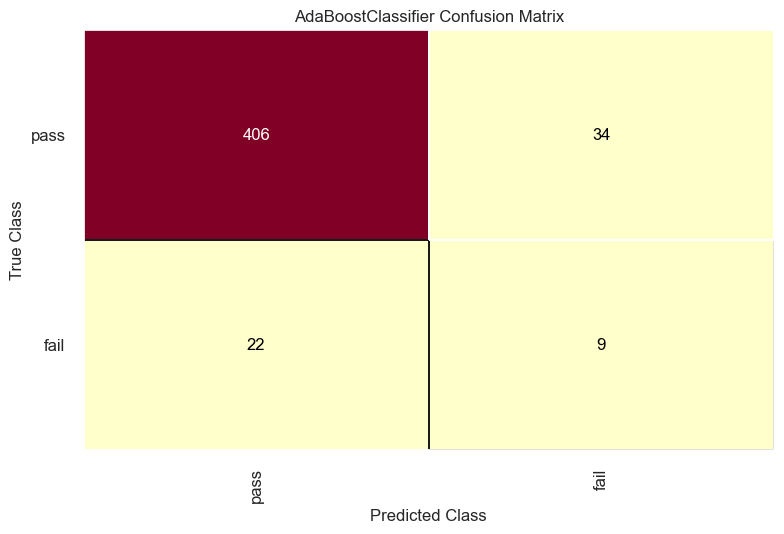

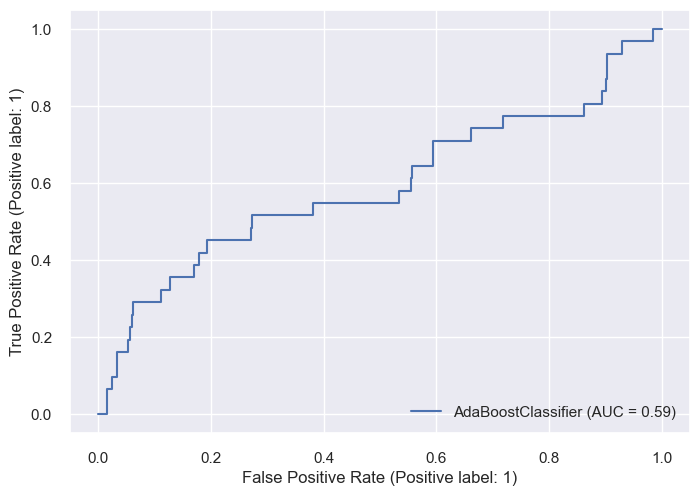

'Run time: 1.4247124195098877, F1-score: 0.881104033970276, MCC: 0.18341392828315306'

In [471]:
evaluate(X_train_rf1_cr, X_test_rf1_cr, y_train_balanced, y_test, AdaBoostClassifier())

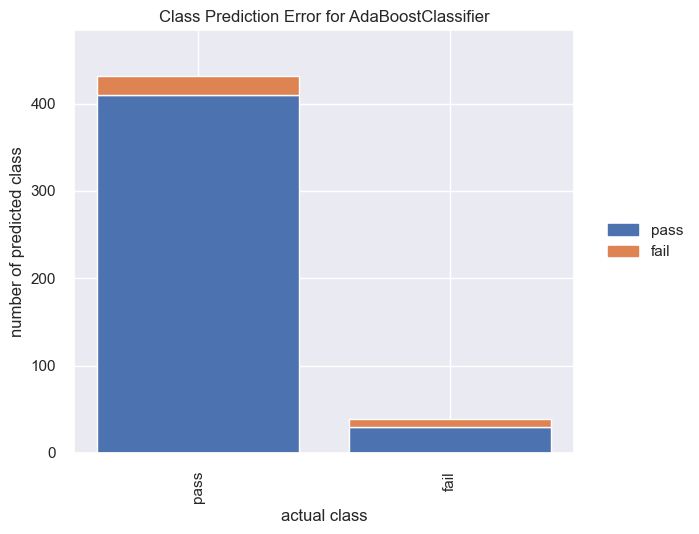

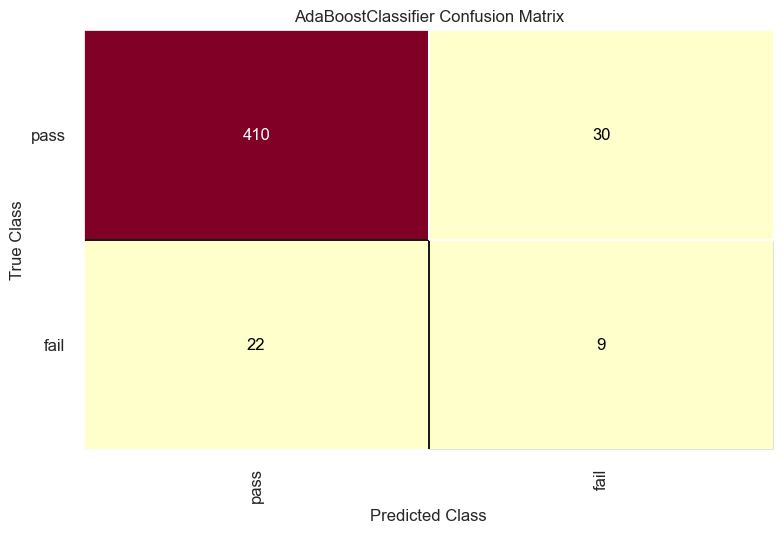

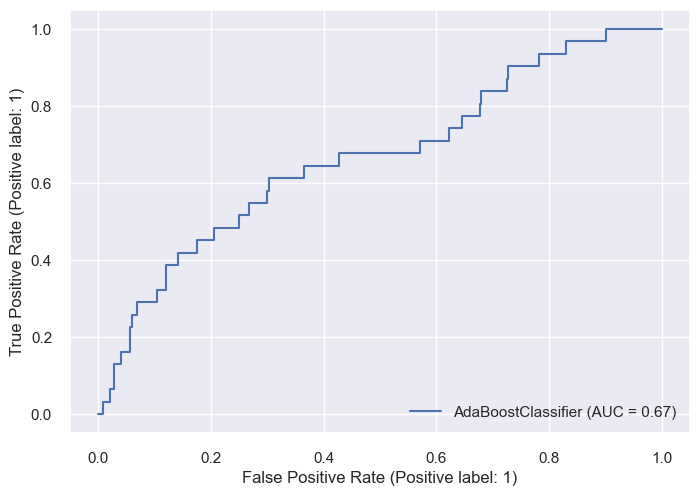

'Run time: 1.0422840118408203, F1-score: 0.8895966029723992, MCC: 0.1998762838903585'

In [472]:
evaluate(X_train_rf2_cr, X_test_rf2_cr, y_train_balanced, y_test, AdaBoostClassifier())

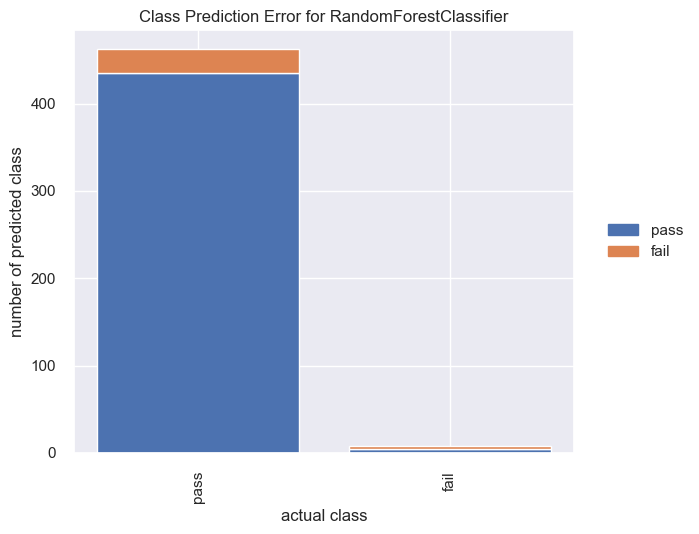

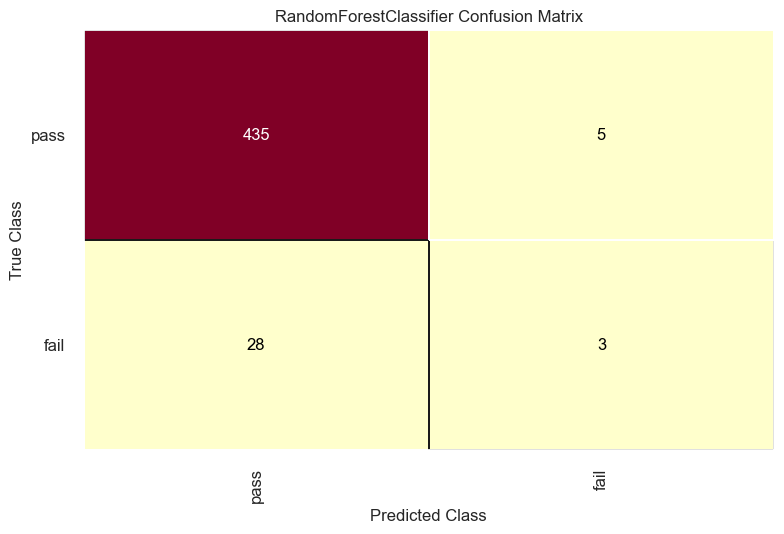

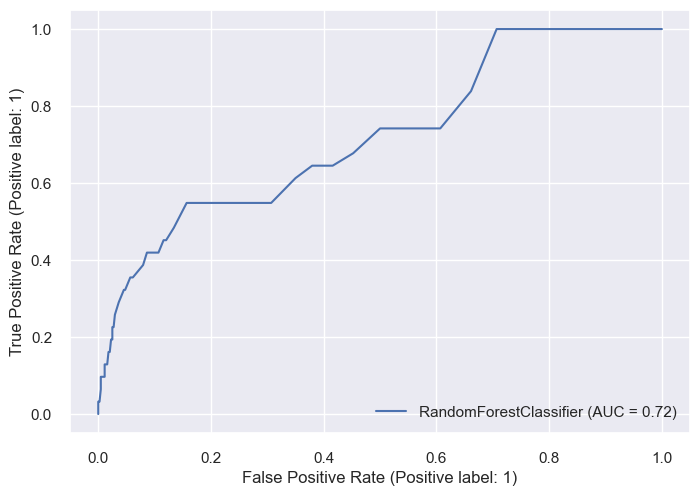

'Run time: 3.0992777347564697, F1-score: 0.9299363057324841, MCC: 0.1639016219051242'

In [473]:
evaluate(X_train_rf1_cr, X_test_rf1_cr, y_train_balanced, y_test, RandomForestClassifier())

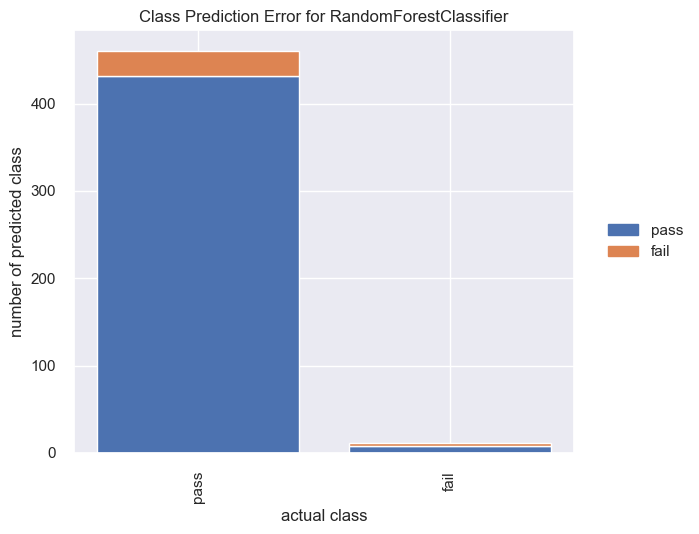

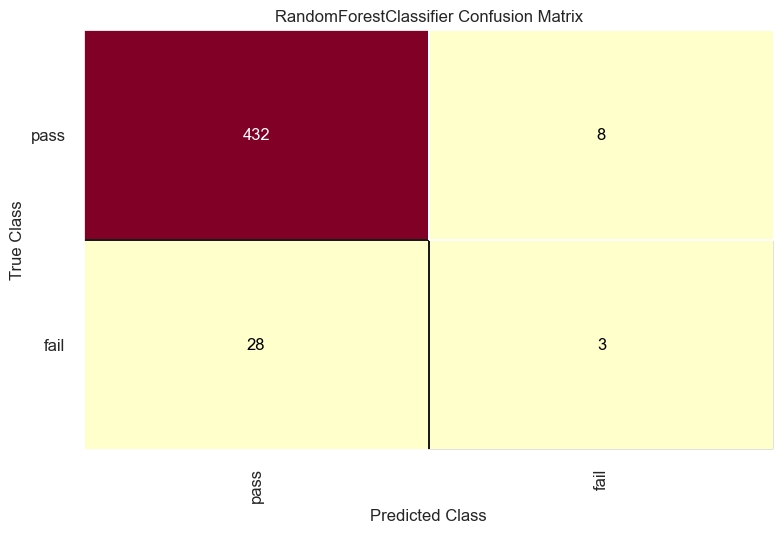

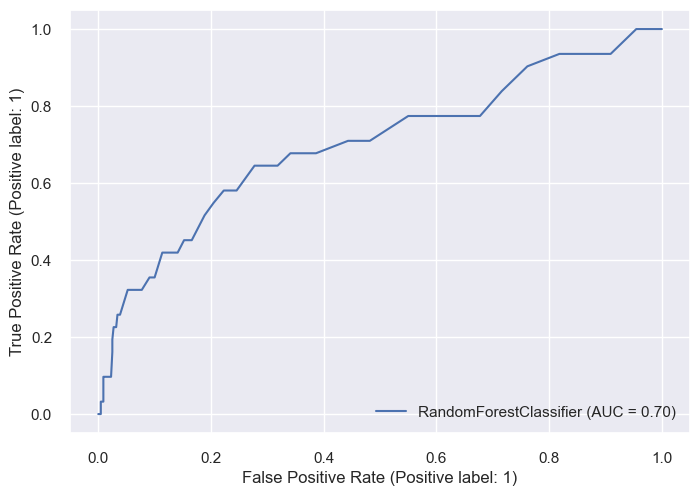

'Run time: 2.4215006828308105, F1-score: 0.9235668789808917, MCC: 0.1290364307973425'

In [474]:
evaluate(X_train_rf2_cr, X_test_rf2_cr, y_train_balanced, y_test, RandomForestClassifier())

Out of all the dimension reduction and feature selection methods and all the models applied the only significant results we get is when using the `LogisticRegression`, with the `RandomForestClassier` as a feature selection techniques. We tried several combinations of features and the `X_train_rf1` gave the best results, which is a 54 feature dataset with no exclusion of inter correlated features. Let us see if we can improve the LogisticRegression any further.   


#### Model tuning

##### Class weights
We can actually tell our model if the prediction of the classes in our problem are balanced or not. Let us assume that in our cases the prediction of failed tests (Target = 1) is more important then the prediction of passes (Target = 0).

After several trials I find that a 1:2 ration in `class_weight` works best for the `LogisticRegression`

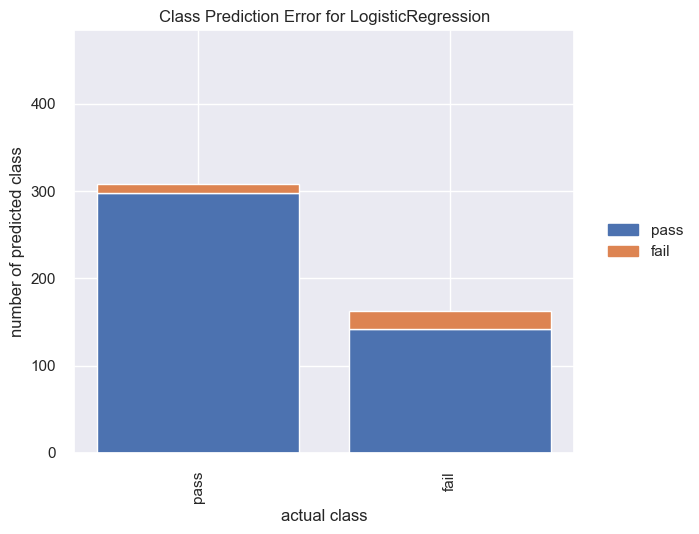

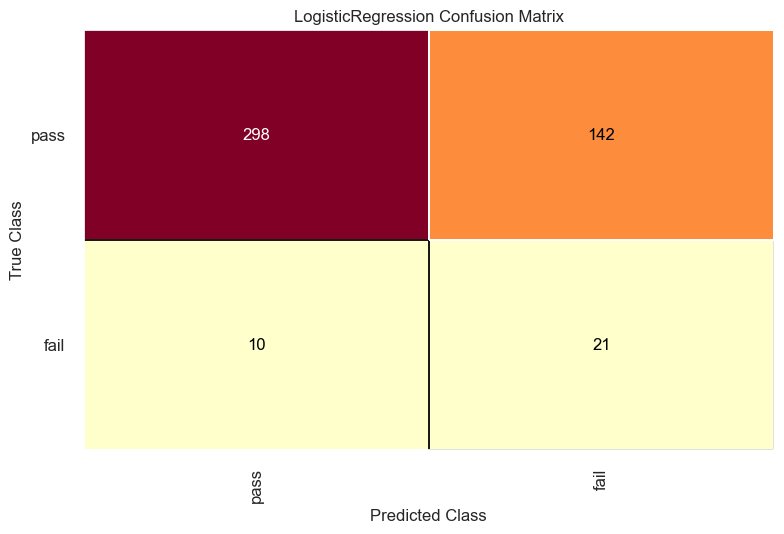

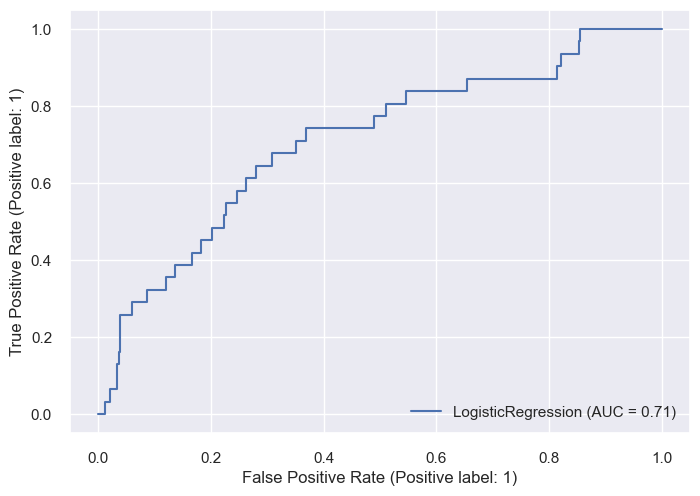

'Run time: 0.08827519416809082, F1-score: 0.6772823779193206, MCC: 0.1848798237349539'

In [481]:
evaluate(X_train_rf1, X_test_rf1, y_train_balanced, y_test, LogisticRegression(class_weight={0:1, 1:2}))

##### Random forest hyperparameters

We may do the same fro the `RandomForestClassifier`. Note that even very with high weights for the fails it is hard for the Random forest to predict the failures, while it excels at predicting the passes.

After many trails I chose several hyperparameters for the `RandomForestClassifier`, that give better predictions for the fails. Normally I would use a `GridSearchCV` for this but since I am most interested in the confusion matrix I did the hyperparameter tuning manually. 

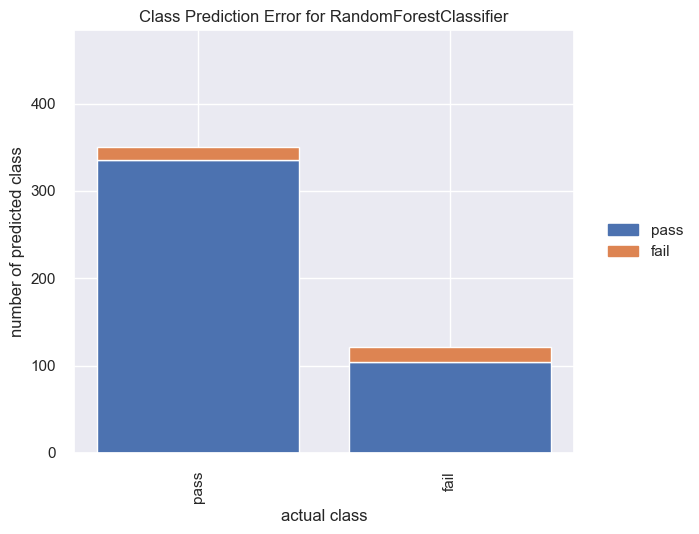

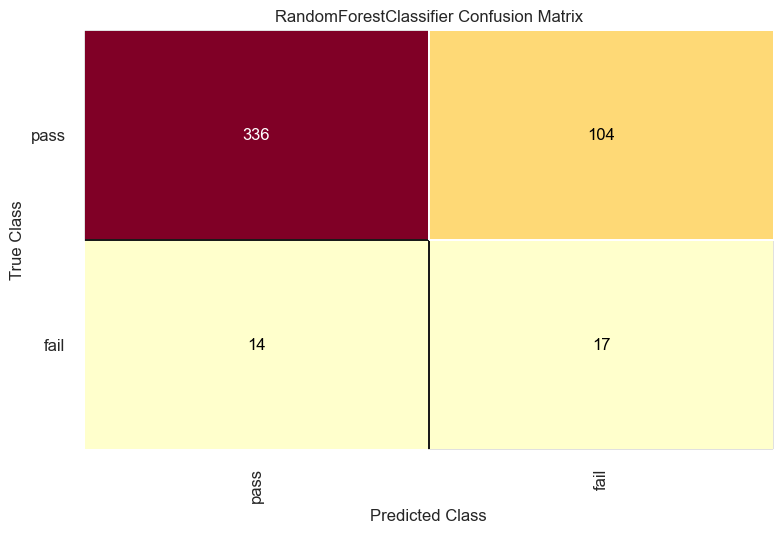

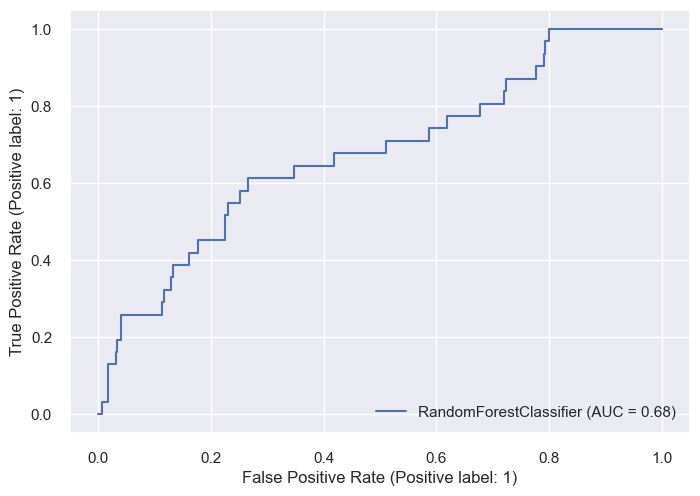

'Run time: 4.331394195556641, F1-score: 0.7494692144373672, MCC: 0.1770792715653608'

In [529]:
evaluate(X_train_rf1, X_test_rf1, y_train_balanced, y_test, 
         RandomForestClassifier(class_weight={0:1, 1:15}, random_state=12, 
                                n_estimators=100, min_samples_leaf = 10, max_depth=16))

GBM hyperparameters

Boosting algorithms do not have the `class_weight` option since the algorithm itself deals well with imbalanced data. Again after manual tests I chose the following hyperparameters. Note I am using a `max_dept` = 1, so the GBM has only stump trees. 

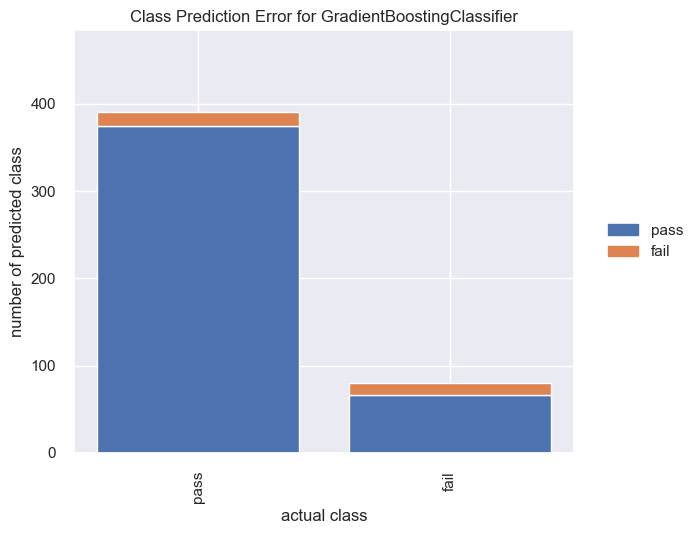

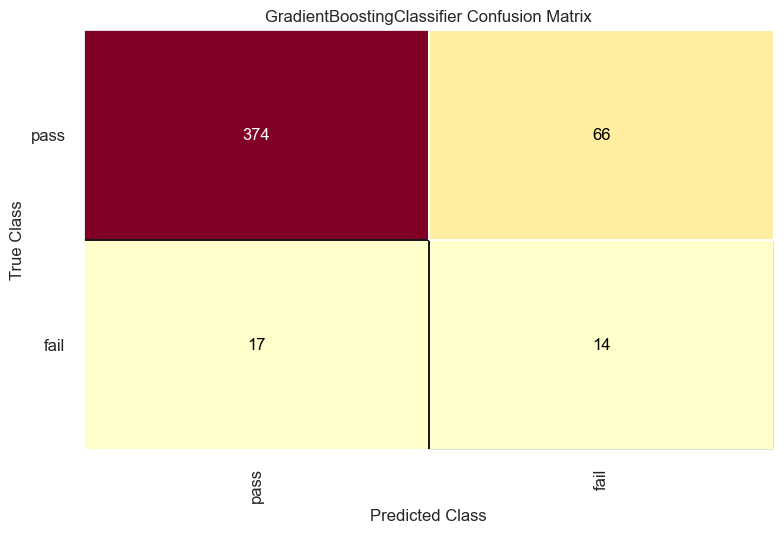

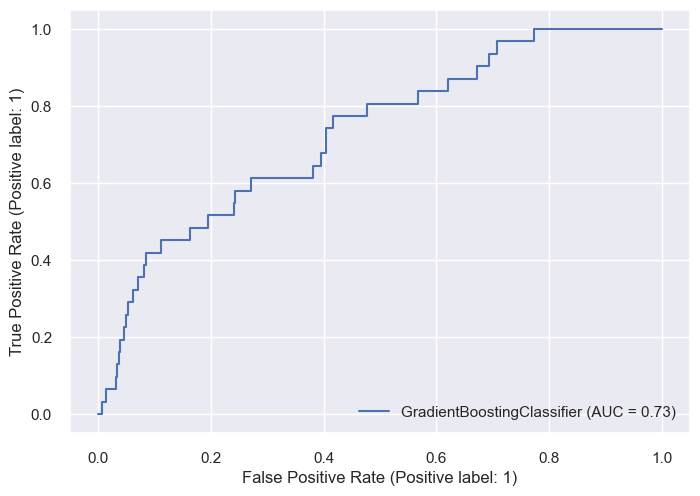

'Run time: 19.409926891326904, F1-score: 0.8237791932059448, MCC: 0.19916991132306502'

In [545]:
evaluate(X_train_rf1, X_test_rf1, y_train_balanced, y_test, 
         GradientBoostingClassifier(random_state=12, n_estimators=500, learning_rate=0.01, 
                                    min_samples_leaf = 10, max_depth=1))

##### AdaBoost hyperparameters

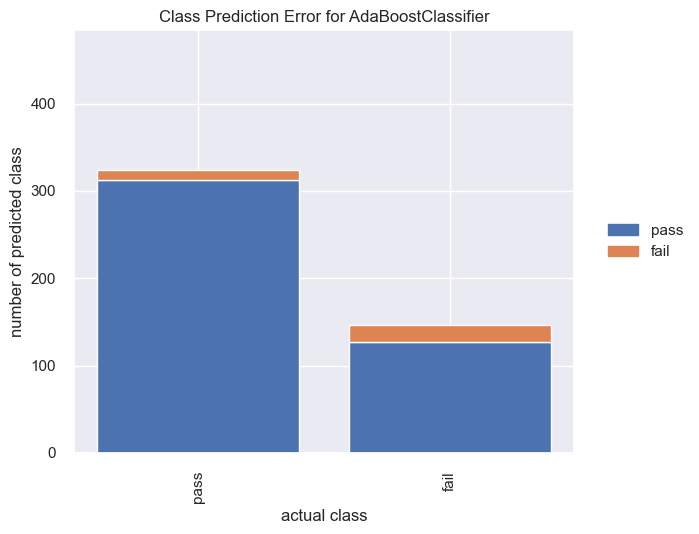

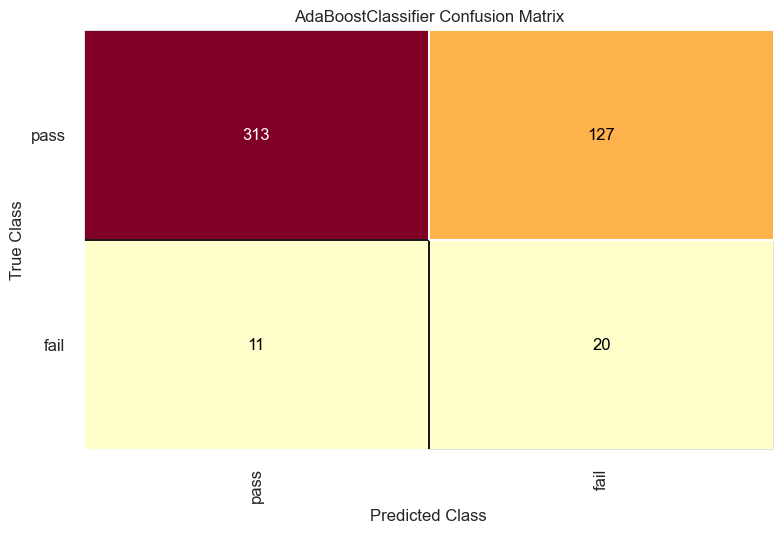

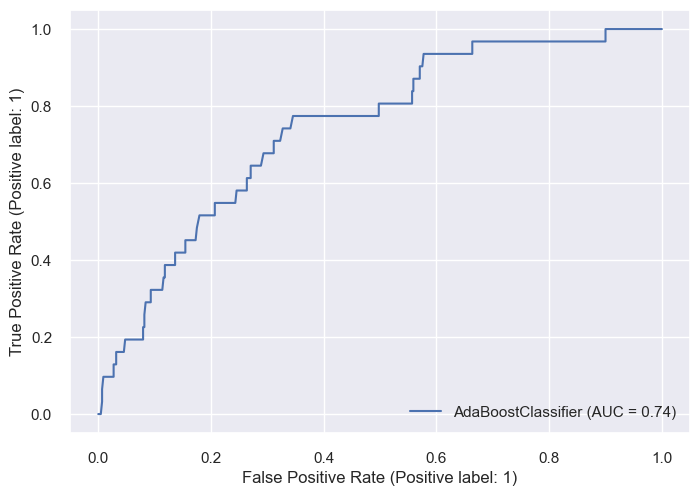

'Run time: 42.465986490249634, F1-score: 0.7070063694267515, MCC: 0.19079452667283667'

In [556]:
evaluate(X_train_rf1, X_test_rf1, y_train_balanced, y_test, 
         AdaBoostClassifier(random_state=12, n_estimators=1000, learning_rate=0.005, algorithm = 'SAMME'))

#### Ensemble method

Let as make an ensemble model using the `VotingClassifier`, with all 4 model types

In [568]:
clf1 = LogisticRegression(class_weight={0:1, 1:2})
clf2 =  RandomForestClassifier(class_weight={0:1, 1:15}, random_state=12, 
                                n_estimators=100, min_samples_leaf = 10, max_depth=16)
clf3 = GradientBoostingClassifier(random_state=12, n_estimators=500, learning_rate=0.01, 
                                    min_samples_leaf = 10, max_depth=1)
clf4 =  AdaBoostClassifier(random_state=12, n_estimators=1000, learning_rate=0.005, algorithm = 'SAMME')

In [561]:
def evaluate2(train_df, test_df, train_target, test_target, estimator):
    
    # first, we should scale our data so logistic regression works better
    
    # training the model
    start_time = time.time()
    method = SMOTE()
    train_df, train_target = method.fit_resample(train_df, train_target)
    estimator.fit(train_df, train_target)
    runtime = time.time() - start_time
    
    # evaluation and scoring
    y_pred = estimator.predict(test_df)
    y_true = test_target
    f1score = f1_score(y_true, y_pred, average='micro')
    mccscore=matthews_corrcoef(y_true, y_pred)
    
    # visualizations
    cre = ClassPredictionError(estimator, classes=['pass','fail'])
    cre.score(test_df, y_true)
    cre.show()
    cm = ConfusionMatrix(estimator, classes=['pass','fail'])
    cm.score(test_df, y_true)
    cm.show()
    
    return f'Run time: {runtime}, F1-score: {f1score}, MCC: {mccscore}' 

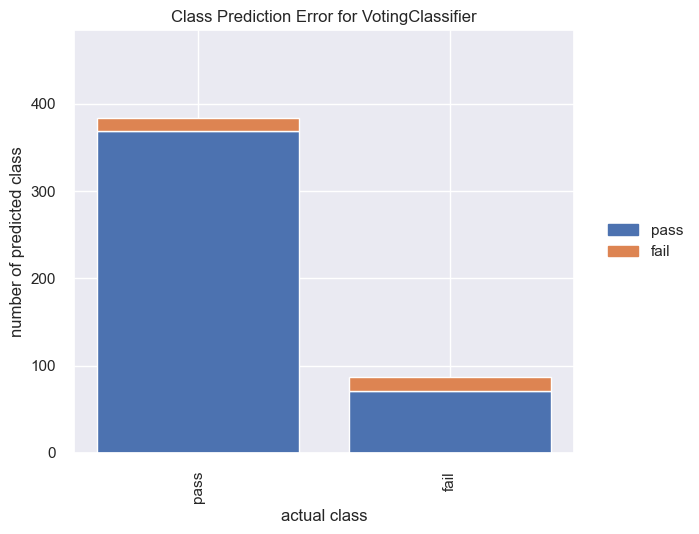

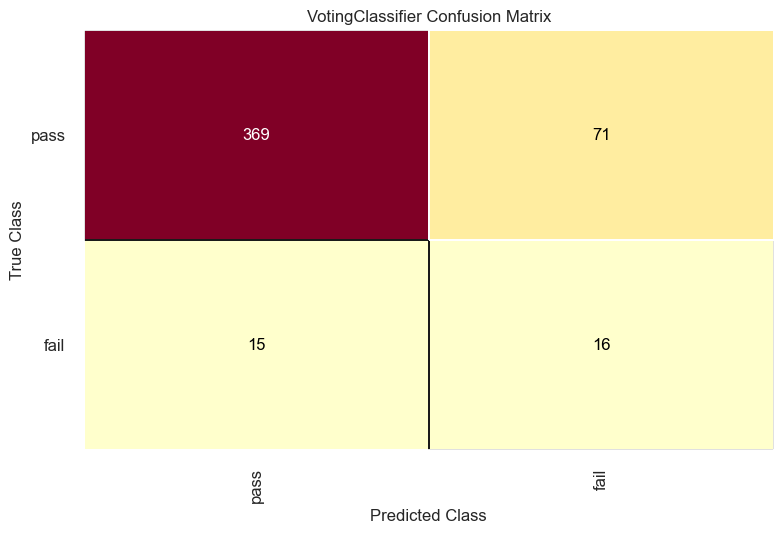

'Run time: 67.5789122581482, F1-score: 0.8174097664543525, MCC: 0.22668521668180983'

In [569]:
ensemble_model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gbm', clf3), ('ada', clf4)], voting='hard')
evaluate2(X_train_rf1, X_test_rf1, y_train_balanced, y_test, ensemble_model)

The result are pretty good in comparison to the individual models, however the % of correctly classified fails its still low. We know that the `LogisticRegression` and `AdaBoostClassifier` are the best at predicting fails. We can apply weights for these to models and see the result. 

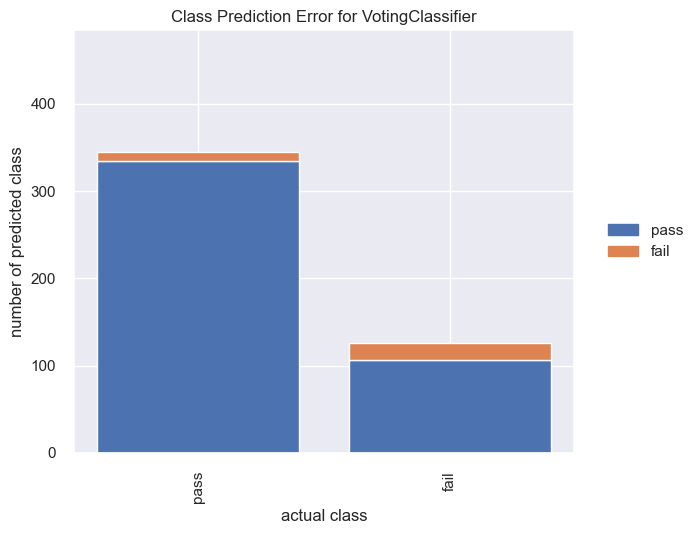

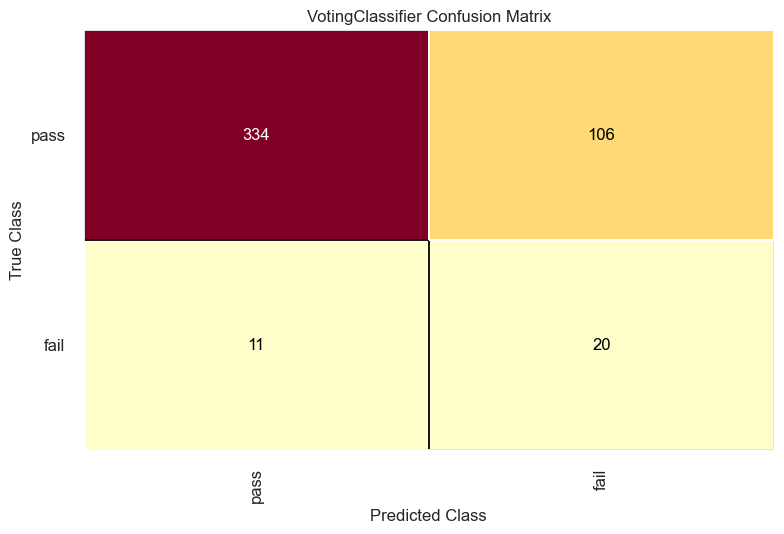

'Run time: 65.94760847091675, F1-score: 0.751592356687898, MCC: 0.2264460536615933'

In [572]:
ensemble_model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gbm', clf3), ('ada', clf4)], 
                                  voting='soft', weights=[1.5,1,1,1.5], flatten_transform=True)
evaluate2(X_train_rf1, X_test_rf1, y_train_balanced, y_test, ensemble_model)

Let us also have a look at how our `VotingClassifier` measures to the whole dataset

In [658]:
target = df['Pass/Fail']
df_imp = outlier_imputer(df, df, df.columns, 3)
df_imp = nan_imputer(df)
df_imp = df_imp.drop('Pass/Fail', axis=1)

df_rf1 = df_imp[(importance_df_filtered_1['Features'])]

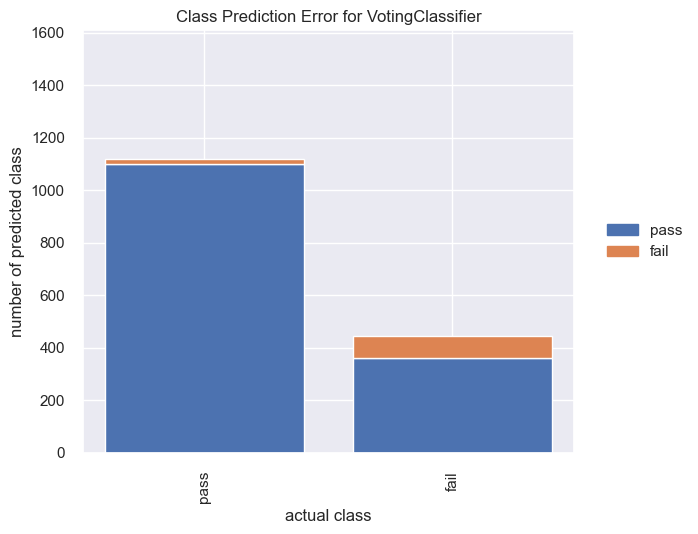

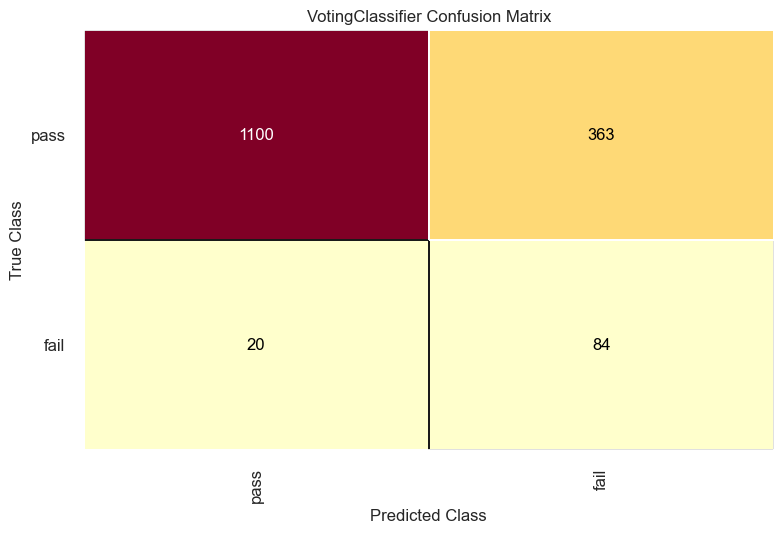

'Run time: 66.18787002563477, F1-score: 0.7555839183152521, MCC: 0.30848357142010957'

In [660]:
evaluate2(X_train_rf1, df_rf1, y_train_balanced, target, ensemble_model)

This is our final model, let us save it as a `.pkl` file in our environment

In [574]:
model = ensemble_model
model.fit(X_train_rf1, y_train_balanced)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(class_weight={0: 1, 1: 2})),
                             ('rf',
                              RandomForestClassifier(class_weight={0: 1, 1: 15},
                                                     max_depth=16,
                                                     min_samples_leaf=10,
                                                     random_state=12)),
                             ('gbm',
                              GradientBoostingClassifier(learning_rate=0.01,
                                                         max_depth=1,
                                                         min_samples_leaf=10,
                                                         n_estimators=500,
                                                         random_state=12)),
                             ('ada',
                              AdaBoostClassifier(algorithm='SAMME',
                                                 learning_rate=0.005,
                                                 n_estimators=1000,
                                                 random_state=12))],
                 voting='soft', weights=[1.5, 1, 1, 1.5])

In [ ]:
model_pkl_file = "uci_semiconductor_model.pkl"  

In [ ]:
with open(model_pkl_file, 'wb') as file:  
    pickle.dump(model, file)

In [ ]:
with open(self.model_name, 'rb') as file:  
    model = pickle.load(file)